# EDA for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 1. 데이터 설명


- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보


## 2. 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("ticks")
import matplotlib.ticker as ticker

from mplsoccer import Radar, FontManager, grid

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from datetime import datetime
from datetime import timedelta
import missingno as msno

from sklearn.preprocessing import StandardScaler


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings(action='ignore')

pd.set_option("display.max_columns", None)

plt.rc('font', family='Noto Sans KR')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
import plotly.io as pio

pio.renderers.default = "svg"

In [3]:
# 데이터 경로
path = "data/df_merged_total.csv"
df = pd.read_csv(path)

In [ ]:
df.head()

player_name_preprocessed  start_season  yellow_cards_preprocessed  \
0             Aarón Martín        2019.0                        2.0   
1        Abdelhamid Sabiri        2019.0                        6.0   
2            Achraf Hakimi        2019.0                        5.0   
3              Adam Bodzek        2019.0                       10.0   
4          Ademola Lookman        2019.0                        0.0   

   red_cards_preprocessed  goals  assists  minutes_played  total_apps  \
0                     0.0    0.0      0.0          1795.0        22.0   
1                     0.0    4.0      1.0          1035.0        24.0   
2                     0.0    5.0     10.0          2717.0        33.0   
3                     0.0    0.0      0.0          2018.0        28.0   
4                     0.0    0.0      0.0           300.0        11.0   

  competition_code  is_major_national_league date_of_birth  \
0       bundesliga                      True    1997-04-22   
1       bundesliga                      True    1996-11-28   
2       bundesliga                      True    1998-11-04   
3       bundesliga                      True    1985-09-07   
4       bundesliga                      True    1997-10-20   

  position_preprocessed    current_club_name  highest_market_value  \
0             Left-Back            Genoa CFC            20000000.0   
1    Attacking Midfield       ACF Fiorentina             4000000.0   
2            Right-Back  Paris Saint-Germain            70000000.0   
3    Defensive Midfield   Fortuna Düsseldorf             1750000.0   
4        Second Striker          Atalanta BC            40000000.0   

   market_value_per_season  country   foot  height_in_cm  \
0               10500000.0    Spain   left         178.0   
1                1700000.0  Morocco  right         186.0   
2               54000000.0  Morocco  right         181.0   
3                 325000.0   Poland  right         184.0   
4               13500000.0  Nigeria  right         174.0   

  player_name_normalized original_player_name first_name_preprocessed  \
0           Aaron Martin         Aarón Martín                   Aaron   
1      Abdelhamid Sabiri    Abdelhamid Sabiri              Abdelhamid   
2          Achraf Hakimi        Achraf Hakimi                  Achraf   
3            Adam Bodzek          Adam Bodzek                    Adam   
4        Ademola Lookman      Ademola Lookman                 Ademola   

  last_name_preprocessed      id player_name_league  games    time  \
0                 Martin  5133.0       Aarón Martín   22.0  1804.0   
1                 Sabiri  6296.0  Abdelhamid Sabiri   24.0  1028.0   
2                 Hakimi  5197.0      Achraf Hakimi   33.0  2709.0   
3                 Bodzek  7140.0        Adam Bodzek   28.0  2023.0   
4                Lookman  5556.0    Ademola Lookman   11.0   281.0   

   goals_season  xG_season  assists_season  xA_season  shots_season  \
0           0.0   0.294448             0.0   3.250888           9.0   
1           4.0   3.468877             1.0   0.232751          43.0   
2           5.0   5.067438            10.0   5.510969          38.0   
3           0.0   0.697913             0.0   0.270701           9.0   
4           0.0   1.185320             0.0   0.983638          11.0   

   key_passes_season  yellow_cards_league  red_cards_league position_league  \
0               32.0                  2.0               0.0           D M S   
1                7.0                  6.0               0.0             M S   
2               36.0                  5.0               0.0           D M S   
3                8.0                 10.0               0.0             M S   
4                7.0                  0.0               0.0             F S   

               team_title  npg_season  npxG_season    xGChain  xGBuildup  \
0                Mainz 05         0.0     0.294448   3.658402   2.195273   
1               Paderborn         3.0     2.711101   1.644770   0.8

In [5]:
# 데이터프레임에서 사용할 컬럼들만 필터링
cols = ['player_name_preprocessed', 'start_season', 'yellow_cards_preprocessed',
       'red_cards_preprocessed', 'goals', 'assists', 'minutes_played',
       'total_apps', 'competition_code', 'date_of_birth', 'position_preprocessed', 'current_club_name',
       'highest_market_value', 'market_value_per_season', 'country', 'foot',
       'height_in_cm', 'xG_season', 'xA_season', 'shots_season', 'key_passes_season',
       'npg_season', 'npxG_season', 'xGChain', 'xGBuildup']
df = df[cols]

# 컬럼명 변경
df.rename(columns={"player_name_preprocessed" : "player_name",
                   'yellow_cards_preprocessed' : "yellow_cards",
                   "red_cards_preprocessed" : "red_cards",
                   "position_preprocessed" : "position",
                   "xG_season" : "xG",
                   "xA_season" : "xA",
                   "shots_season" : "shots",
                   "key_passes_season" : "key_passes",
                   "npg_season" : "npg",
                   "npxG_season" : "npxG"}, 
                   inplace= True)

In [ ]:
df.head(3)

player_name  start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín        2019.0           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri        2019.0           6.0        0.0    4.0      1.0   
2      Achraf Hakimi        2019.0           5.0        0.0    5.0     10.0   

   minutes_played  total_apps competition_code date_of_birth  \
0          1795.0        22.0       bundesliga    1997-04-22   
1          1035.0        24.0       bundesliga    1996-11-28   
2          2717.0        33.0       bundesliga    1998-11-04   

             position    current_club_name  highest_market_value  \
0           Left-Back            Genoa CFC            20000000.0   
1  Attacking Midfield       ACF Fiorentina             4000000.0   
2          Right-Back  Paris Saint-Germain            70000000.0   

   market_value_per_season  country   foot  height_in_cm        xG        xA  \
0               10500000.0    Spain   left         178.0  0.294448  3.250888   
1                1700000.0  Morocco  right         186.0  3.468877  0.232751   
2               54000000.0  Morocco  right         181.0  5.067438  5.510969   

   shots  key_passes  npg      npxG    xGChain  xGBuildup  
0    9.0        32.0  0.0  0.294448   3.658402   2.195273  
1   43.0         7.0  3.0  2.711101   1.644770   0.885899  
2   38.0        36.0  5.0  5.067438  24.144373  16.293885

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11463 entries, 0 to 11462
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              11463 non-null  object 
 1   start_season             11463 non-null  float64
 2   yellow_cards             11463 non-null  float64
 3   red_cards                11463 non-null  float64
 4   goals                    11463 non-null  float64
 5   assists                  11463 non-null  float64
 6   minutes_played           11463 non-null  float64
 7   total_apps               11463 non-null  float64
 8   competition_code         11463 non-null  object 
 9   date_of_birth            11463 non-null  object 
 10  position                 11463 non-null  object 
 11  current_club_name        11463 non-null  object 
 12  highest_market_value     11463 non-null  float64
 13  market_value_per_season  11463 non-null  float64
 14  country               

In [8]:
# date_of_birth 컬럼 타입 datetime으로 변경
df["date_of_birth"] = pd.to_datetime(df["date_of_birth"], format='%Y-%m-%d')

In [9]:
# 시즌별 만 나이 구하는 함수 생성
def calculate_age(born_col, season_col):
    today = datetime.today()
    # 생일이 지나지 않았다면 현재 연도 - 태어난 연도 - 1년 더 빼준다
    age = today.year - born_col.year - ((today.month, today.day) < (born_col.month, born_col.day))
    # return age, season_col

    # 23-24 시즌
    if season_col == (today.year-1):
        return age
    # 22-23 시즌
    elif season_col == (today.year-2):
        return age-1
    # 21-22 시즌
    elif season_col == (today.year-3):
        return age-2
    # 20-21 시즌
    elif season_col == (today.year-4):
        return age-3
    # 19-20 시즌
    else :
        return age-4
    

In [10]:
# 시즌별 만 나이 구하는 함수 적용
df["age"] = df.apply(lambda row : calculate_age(row["date_of_birth"], row["start_season"]), axis=1)

In [11]:
# start_season 컬럼 타입 object로 변경
df["start_season"] = df["start_season"].astype(int).astype(str)

In [12]:
# 결측치 확인
df.isnull().sum()

player_name                0
start_season               0
yellow_cards               0
red_cards                  0
goals                      0
assists                    0
minutes_played             0
total_apps                 0
competition_code           0
date_of_birth              0
position                   0
current_club_name          0
highest_market_value       0
market_value_per_season    0
country                    0
foot                       0
height_in_cm               0
xG                         0
xA                         0
shots                      0
key_passes                 0
npg                        0
npxG                       0
xGChain                    0
xGBuildup                  0
age                        0
dtype: int64

In [13]:
# 450분 이상을 소화한 선수만 필터링
df = df[df["minutes_played"]>=450]

In [14]:
df.shape

(8511, 26)

In [15]:
# 중복값 확인
df[df.duplicated(subset=["player_name", "age", "position", "current_club_name"], keep=False)].sort_values(by="player_name").head(20)

player_name start_season  yellow_cards  red_cards  goals  \
2278   Alessandro Florenzi         2019           5.0        0.0    0.0   
6859   Alessandro Florenzi         2019           1.0        1.0    0.0   
10552       Angelo Fulgini         2022           0.0        0.0    1.0   
1381        Angelo Fulgini         2022           1.0        0.0    0.0   
7314      Antonio Sanabria         2020           2.0        0.0    3.0   
2552      Antonio Sanabria         2020           2.0        0.0    5.0   
8190      Benjamin Lecomte         2022           1.0        1.0    0.0   
10580     Benjamin Lecomte         2022           0.0        0.0    0.0   
5873     Benoît Badiashile         2022           2.0        0.0    1.0   
10582    Benoît Badiashile         2022           3.0        0.0    2.0   
10115      Bruno Guimarães         2021           2.0        0.0    0.0   
5409       Bruno Guimarães         2021           4.0        0.0    5.0   
6892          Carles Pérez         2019           0.0        0.0    1.0   
2315          Carles Pérez         2019           2.0        0.0    1.0   
10618       Dango Ouattara         2022           3.0        0.0    6.0   
5923        Dango Ouattara         2022           1.0        0.0    1.0   
1899    David Datro Fofana         2023           0.0        0.0    1.0   
6456    David Datro Fofana         2023           1.0        0.0    4.0   
2966      Dejan Kulusevski         2021           1.0        0.0    1.0   
5459      Dejan Kulusevski         2021           3.0        0.0    5.0   

       assists  minutes_played  total_apps competition_code date_of_birth  \
2278       1.0          1003.0        14.0          serie-a    1991-03-11   
6859       0.0           754.0        12.0           laliga    1991-03-11   
10552      1.0           864.0        17.0          ligue-1    1996-08-20   
1381       1.0           519.0        16.0       bundesliga    1996-08-20   
7314       0.0           935.0        16.0           laliga    1996-03-04   
2552       1.0           983.0        14.0          serie-a    1996-03-04   
8190       0.0           900.0        10.0           laliga    1991-04-26   
10580      0.0          1710.0        19.0          ligue-1    1991-04-26   
5873       0.0           904.0        11.0   premier-league    2001-03-26   
10582      0.0           839.0        11.0          ligue-1    2001-03-26   
10115      4.0          1640.0        20.0          ligue-1    1997-11-16   
5409       1.0          1034.0        17.0   premier-league    1997-11-16   
6892       3.0           473.0        10.0           laliga    1998-02-16   
2315       3.0           563.0        14.0          serie-a    1998-02-16   
10618      6.0          1553.0        18.0          ligue-1    2002-02-11   
5923       3.0          1245.0        19.0   premier-league    2002-02-11   
1899       0.0           688.0        12.0       bundesliga    2002-12-22   
6456       1.0           879.0        15.0   premier-league    2002-12-22   
2966       3.0           760.0        20.0          serie-a    2000-04-25   
5459       8.0          1267.0        18.0   premier-league    2000-04-25   

                 position  current_club_name  highest_market_value  \
2278           Right-Back           AC Milan            30000000.0   
6859           Right-Back           AC Milan            30000000.0   
10552  Attacking Midfield            RC Lens            12000000.0   
1381   Attacking Midfield            RC Lens            12000000.0   
7314       Centre-Forward          Torino FC            10000000.0   
2552       Centre-Forward          Torino FC            10000000.0   
8190           Goalkeeper    Montpellier HSC            17000000.0   
10580          Goalkeeper    Montpellier HSC            17000000.0   
5873          Centre-Back         Chelsea FC            40000000.0   
10582         Centre-Back         Chelsea FC            40000000.0   
10115  Defensive Midfield   Newcastle United       

In [16]:
# 합계를 계산할 컬럼들과 평균을 계산할 컬럼들을 정의
columns_to_sum = ['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', "total_apps",
                  'xG', 'xA', 'shots', 'key_passes', 'npg', 'npxG', 'xGChain', 'xGBuildup']
# columns_to_average = []

# 중복된 값을 확인하기 위해 키 컬럼들로 그룹화
grouped_df = df.groupby(['player_name', 'start_season', 'age', 'current_club_name'])

# 필요한 컬럼들을 합산하고 나머지 컬럼들은 평균을 계산
df_no_duplicate = grouped_df.agg({
    **{col: 'sum' for col in columns_to_sum},  # 필요한 컬럼들을 합산
    # **{col: lambda x: x.sum() / 2 for col in columns_to_average},  # 나머지 컬럼들은 합계 후 2로 나누어 평균 계산
    # 범주형 컬럼은 첫 번째 값을 유지
    'competition_code': 'first',
    'position' : 'first',
    'height_in_cm' : 'first',
    'highest_market_value' : 'first', 
    'market_value_per_season' : 'first'
}).reset_index()


In [17]:
df_no_duplicate.head(3)

player_name start_season  age       current_club_name  yellow_cards  \
0   Aaron Connolly         2019   20  Brighton & Hove Albion           0.0   
1   Aaron Connolly         2020   21  Brighton & Hove Albion           0.0   
2  Aaron Cresswell         2019   30         West Ham United           7.0   

   red_cards  goals  assists  minutes_played  total_apps        xG        xA  \
0        0.0    3.0      2.0          1261.0        24.0  4.553528  0.562017   
1        0.0    2.0      1.0           791.0        17.0  4.464138  0.160784   
2        0.0    3.0      0.0          2730.0        31.0  1.032539  3.006656   

   shots  key_passes  npg      npxG   xGChain  xGBuildup competition_code  \
0   36.0         6.0  3.0  4.553528  4.356781   0.354199   premier-league   
1   23.0         6.0  2.0  4.464138  4.783492   0.191225   premier-league   
2   18.0        26.0  3.0  1.032539  6.834942   4.891464   premier-league   

         position  height_in_cm  highest_market_value  market_value_per_season  
0  Centre-Forward         174.0             7000000.0                4000000.0  
1  Centre-Forward         174.0             7000000.0                7000000.0  
2       Left-Back         170.0            12000000.0                6500000.0

In [18]:
# df[df["player_name"]=="Gabriel Magalhães"]
# # df[df["player_name"]=="Koke"]
# # df[df["current_club_name"]=="Arsenal FC"].tail(50)


In [19]:
# # df_no_duplicate.sort_values(by="total_apps", ascending=False)
# df_no_duplicate.sort_values(by="shots", ascending=False).head(20)

In [20]:
# 중복 제거한 데이터프레임
df_no_duplicate.shape

(8456, 23)

### 2-1. `.describe()` 확인

In [21]:
df_no_duplicate.describe()

age  yellow_cards    red_cards        goals      assists  \
count  8456.000000   8456.000000  8456.000000  8456.000000  8456.000000   
mean     27.215587      3.571429     0.087748     2.410596     1.888600   
std       4.173046      2.726198     0.301953     3.707815     2.412589   
min      17.000000      0.000000     0.000000     0.000000     0.000000   
25%      24.000000      1.000000     0.000000     0.000000     0.000000   
50%      27.000000      3.000000     0.000000     1.000000     1.000000   
75%      30.000000      5.000000     0.000000     3.000000     3.000000   
max      44.000000     17.000000     3.000000    41.000000    22.000000   

       minutes_played   total_apps           xG           xA        shots  \
count     8456.000000  8456.000000  8456.000000  8456.000000  8456.000000   
mean      1747.973155    25.268448     2.547736     1.816064    21.870506   
std        787.660283     7.908440     3.531697     2.037307    21.671280   
min        450.000000     5.000000     0.000000     0.000000     0.000000   
25%       1077.750000    20.000000     0.426621     0.374160     7.000000   
50%       1708.500000    26.000000     1.288626     1.159634    15.000000   
75%       2381.250000    32.000000     3.135638     2.533883    30.000000   
max       3420.000000    38.000000    37.924069    20.620713   208.000000   

        key_passes          npg         npxG      xGChain    xGBuildup  \
count  8456.000000  8456.000000  8456.000000  8456.000000  8456.000000   
mean     16.412843     2.177507     2.326522     7.172224     4.364900   
std      16.079687     3.248009     3.093953     5.558641     3.485330   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       5.000000     0.000000     0.418758     3.180760     1.900765   
50%      12.000000     1.000000     1.237618     5.720378     3.460478   
75%      23.000000     3.000000     2.929404     9.587386     5.820865   
max     133.000000    33.000000    34.135185    41.541005    28.058833   

       height_in_cm  highest_market_value  market_value_per_season  
count   8456.000000          8.456000e+03             8.456000e+03  
mean     182.788434          2.302859e+07             1.343165e+07  
std        6.584092          2.557430e+07             1.784019e+07  
min      162.000000          3.000000e+05             1.000000e+05  
25%      178.000000          6.000000e+06             2.800000e+06  
50%      183.000000          1.500000e+07             7.000000e+06  
75%      188.000000          3.000000e+07             1.750000e+07  
max      202.000000          2.000000e+08             1.800000e+08

In [22]:
df_no_duplicate.describe(include="object")

player_name start_season current_club_name competition_code  \
count          8456         8456              8456             8456   
unique         3426            5               233                5   
top     Luis Suárez         2022  Newcastle United   premier-league   
freq              6         1813               124             1888   

           position  
count          8456  
unique           13  
top     Centre-Back  
freq           1693

### 2-2. 분포 확인

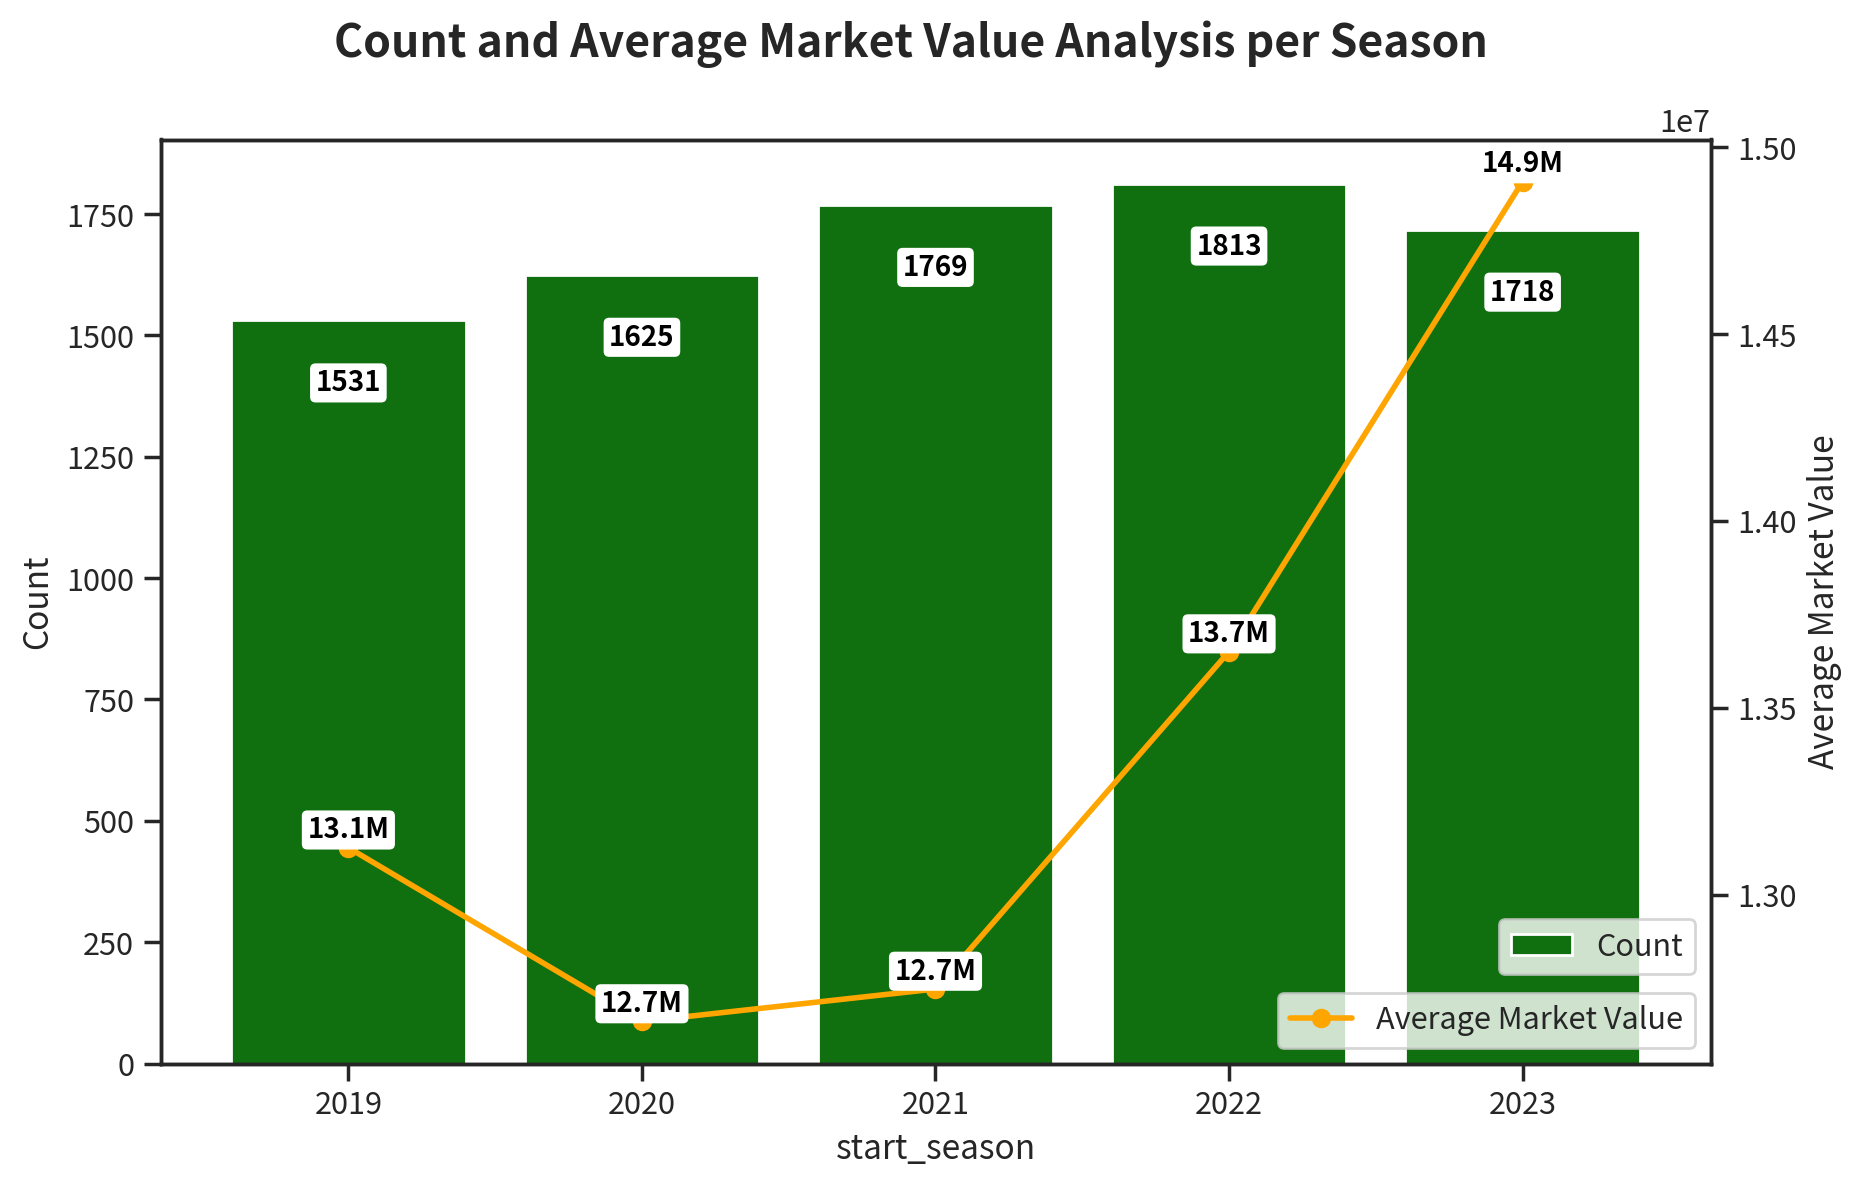

In [23]:
# start_season별 평균 몸값 계산
average_value_per_season = df_no_duplicate.groupby('start_season')['market_value_per_season'].mean()

# 기본 figure 설정
fig, ax1 = plt.subplots(figsize=(10, 6))

# 큰 제목 추가
plt.suptitle('Count and Average Market Value Analysis per Season', fontsize=16, fontweight='bold')

# 첫 번째 y축: countplot 생성 (hue를 제거하고 label 추가)
countplot = sns.countplot(data=df_no_duplicate, x="start_season", ax=ax1, color='green', label='Count')
ax1.set_ylabel('Count')
# ax1.set_title('Count and Average Market Value per Start Season')

# 각 countplot 막대에 값 표시 (밑으로 조금 내리기)
for p in countplot.patches:
    height = p.get_height()
    ax1.text(p.get_x() + p.get_width() / 2., height - 100, int(height), 
             ha='center', va='top', fontsize=10, fontweight='bold', color='black', 
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

# 두 번째 y축 설정
ax2 = ax1.twinx()
lineplot, = ax2.plot(average_value_per_season.index, average_value_per_season.values, 
                     marker='o', color='orange', linewidth=2, label='Average Market Value')
ax2.set_ylabel('Average Market Value')

# 각 lineplot에 값 표시 (위로 올리기)
for i, value in enumerate(average_value_per_season.values):
    ax2.text(average_value_per_season.index[i], value + 10000, f'{round(value/1000000, 1)}M', 
             color='black', ha='center', va='bottom', fontsize=10, fontweight='bold', 
             bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2'))

# 범례 추가
ax1.legend(loc='lower right', bbox_to_anchor=(1, 0.08))
ax2.legend(loc='lower right')

# 그래프 보여주기
plt.show()


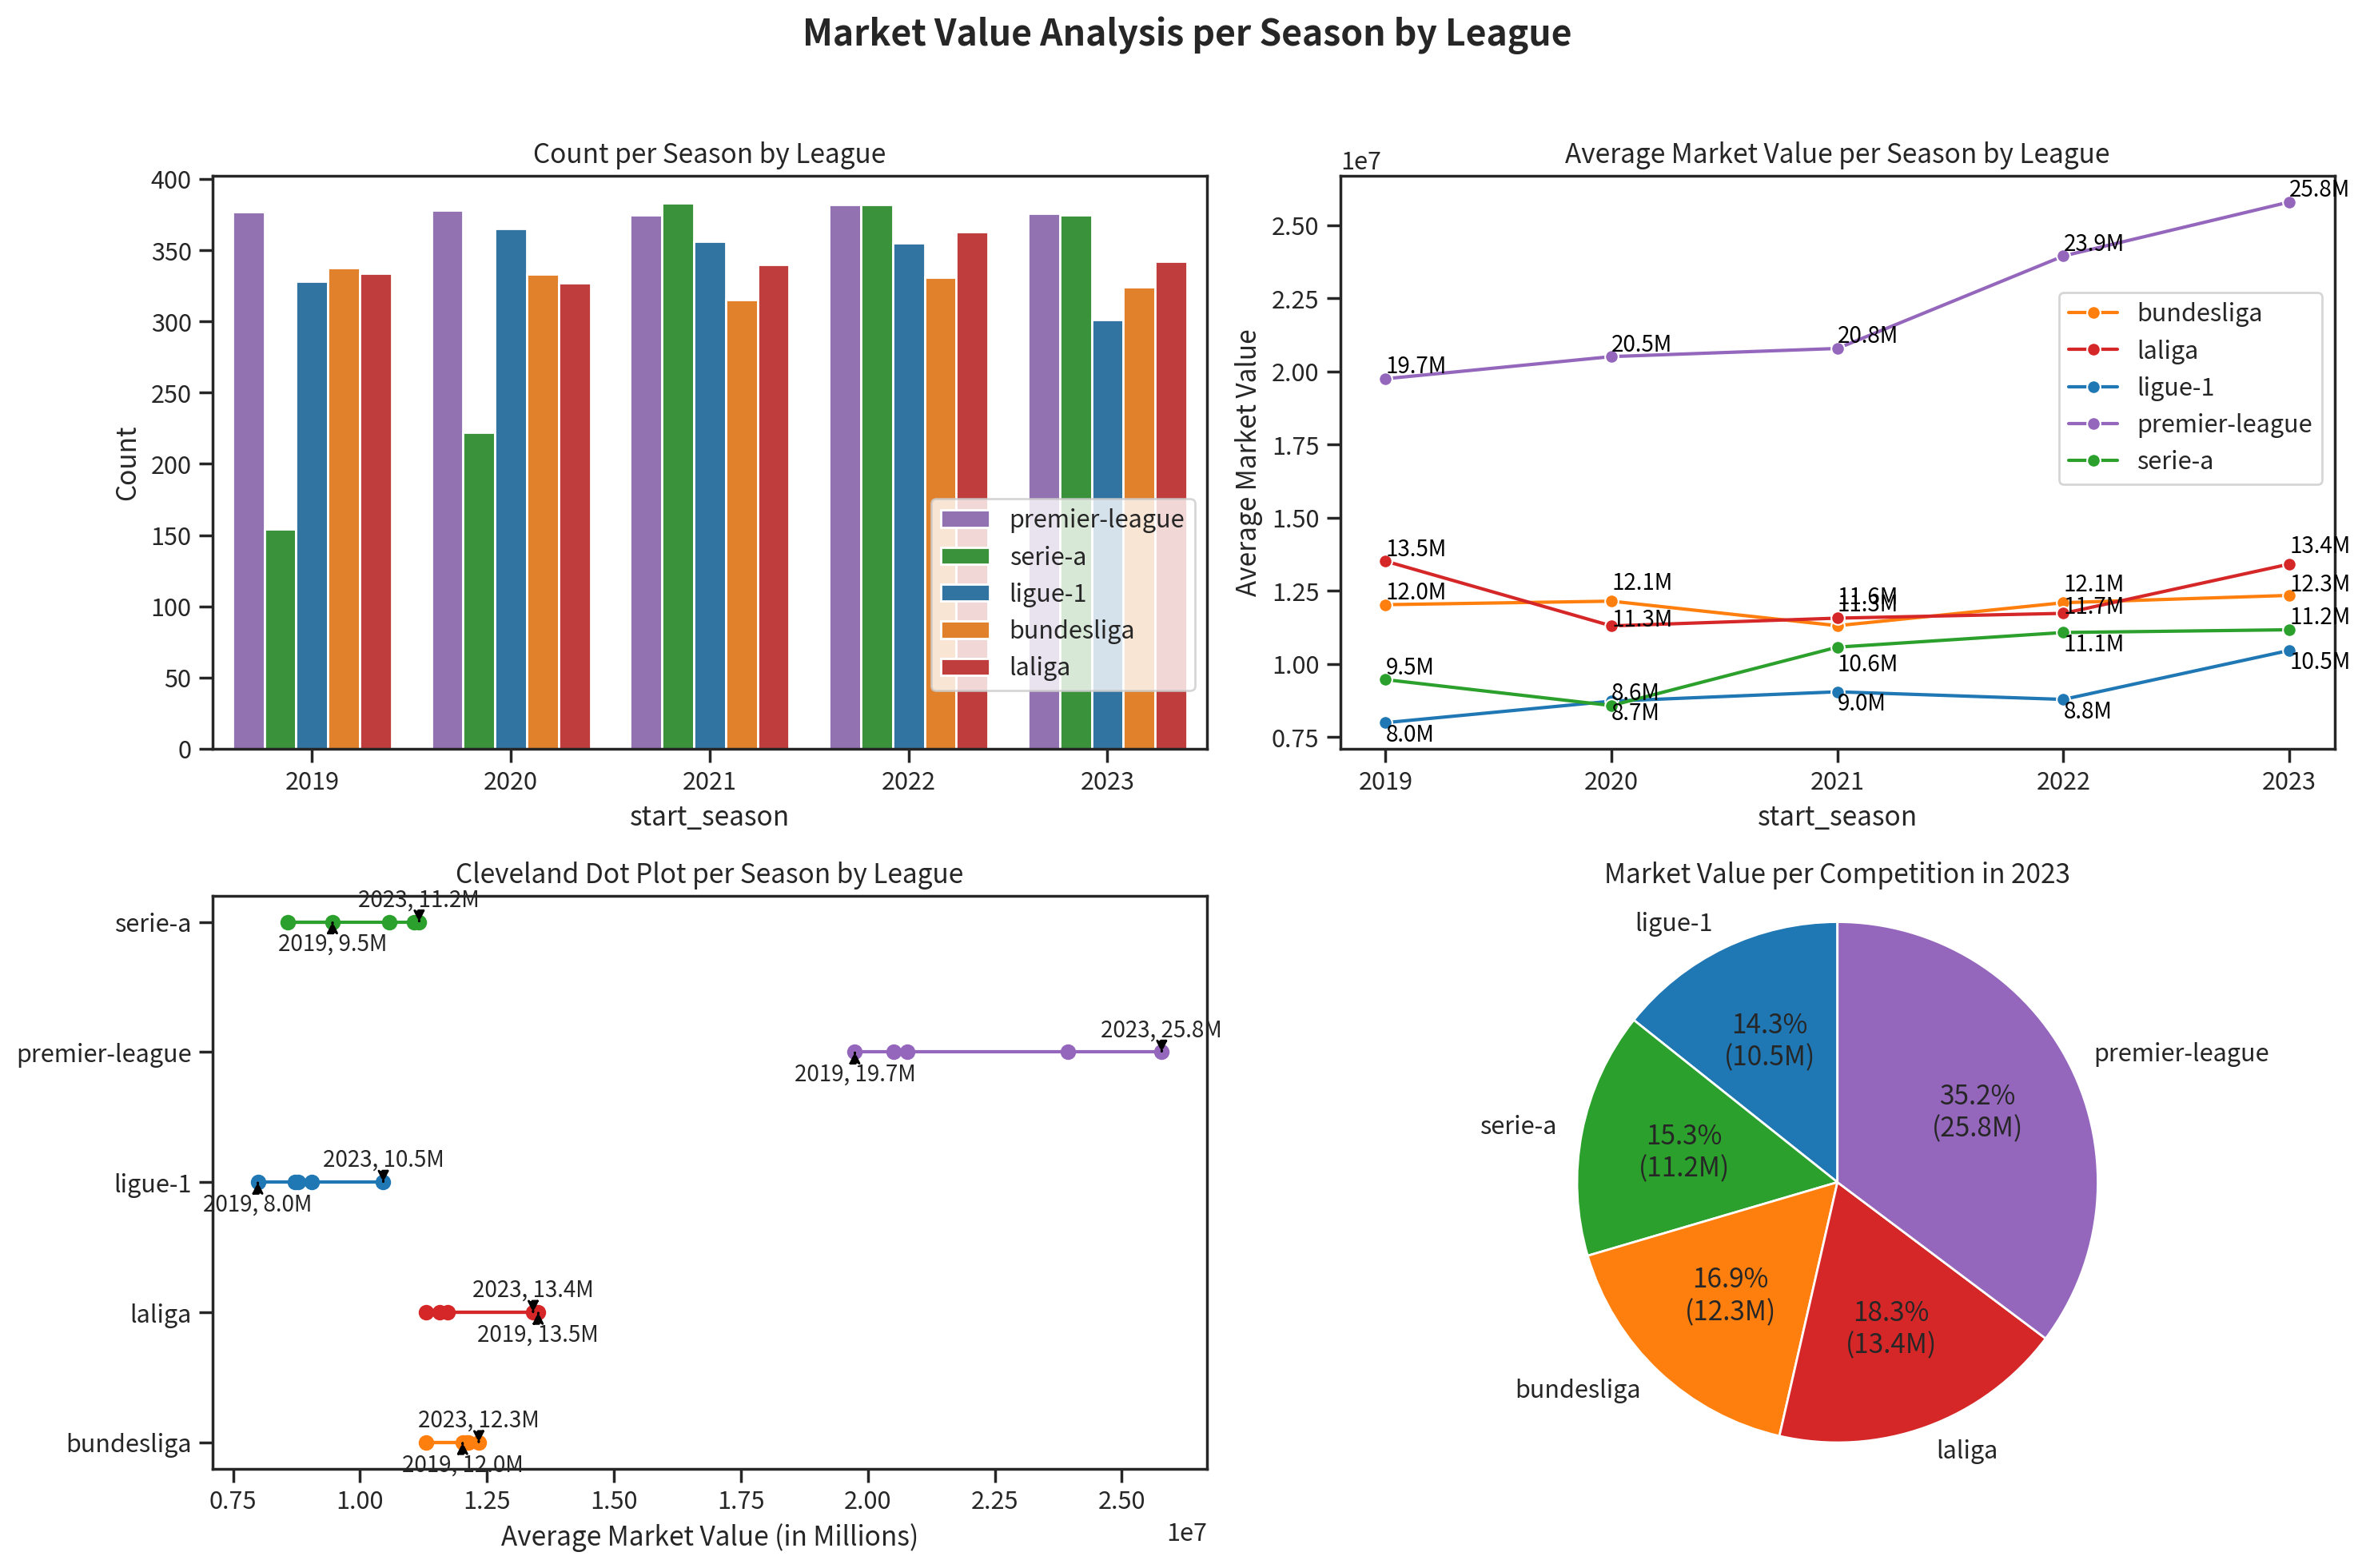

In [24]:
# 2x2 서브플롯으로 4개의 플롯을 표시하는 코드에 Cleveland dot plot 내용 추가

# 공통 색상 팔레트 정의
palette = {
    'laliga': '#d62728',
    'bundesliga': '#ff7f0e',
    'premier-league': '#9467bd', 
    'serie-a': '#2ca02c',
    'ligue-1': '#1f77b4',
    'liga-portugal-bwin': '#8c564b'
}

def autopct_with_values(pct, allvalues):
    absolute = int(pct / 100. * sum(allvalues))
    return f"{pct:.1f}%\n({absolute / 1000000:.1f}M)"

# figure 설정 (2x2 subplots)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.suptitle('Market Value Analysis per Season by League', fontsize=16, fontweight='bold')

# 첫 번째 plot: countplot
sns.countplot(data=df_no_duplicate, x="start_season", hue="competition_code", palette=palette, ax=axes[0, 0])
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Count per Season by League')

average_value_per_season = df_no_duplicate.groupby(['start_season', 'competition_code'])['market_value_per_season'].mean().reset_index()
# competition_code를 카테고리로 변환하여 순서대로 숫자 할당
average_value_per_season['competition_code_numeric'] = average_value_per_season['competition_code'].astype('category').cat.codes


# 두 번째 plot: lineplot (평균 몸값)
sns.lineplot(data=average_value_per_season, x="start_season", y="market_value_per_season", hue="competition_code", marker='o', palette=palette, ax=axes[0, 1])

# 데이터 포인트에 값 표시 (값이 가까울 때 위치 조정)
for i in range(average_value_per_season.shape[0]):
    start_season = average_value_per_season.loc[i, 'start_season']
    market_value = average_value_per_season.loc[i, 'market_value_per_season']
    competition = average_value_per_season.loc[i, 'competition_code']
    
    # 특정 조건에 따라 위치 조정
    verticalalignment = 'bottom'
    offset = 0
    if start_season in ["2020", "2022"]:
        if competition == 'bundesliga':
            offset = 200000  # Bundesliga 값을 위로 올림
        elif competition == 'laliga':
            offset = -200000  # LaLiga 값을 아래로 내림
    
    if (start_season == "2021"):
        if ((competition == "bundesliga") | (competition == "laliga")):
            offset = 300000
        elif competition == "serie-a": 
            offset = -1000000

    if ((start_season == "2022") & (competition == "serie-a")) | (competition == "ligue-1"):
        verticalalignment = 'top'

    if (start_season == "2023"):
        if (competition == "laliga"):
            offset = 200000
        elif (competition == "bundesliga"):
            offset = -50000

    adjusted_y = market_value + offset

    axes[0, 1].text(x=start_season, 
                 y=adjusted_y, 
                 s=f'{round(market_value / 1000000, 1)}M', 
                 color='black', 
                 fontsize=10, 
                 verticalalignment=verticalalignment)

axes[0, 1].set_ylabel('Average Market Value')
axes[0, 1].set_title('Average Market Value per Season by League')

# 세 번째 plot: Cleveland dot plot
for competition in average_value_per_season['competition_code'].unique():
    subset = average_value_per_season[average_value_per_season['competition_code'] == competition]
    axes[1, 0].plot(subset['market_value_per_season'], subset['competition_code_numeric'], 'o-', label=competition, color=palette[competition])
    # 연도별로 각 점에 레이블을 표시 (start_season)
    for i in range(subset.shape[0]):

        season_value = None
        y_offset = 0  # 기본 y_offset은 0으로 설정

        if i in [0, 4]:
            season_value = f"{subset['start_season'].iloc[i]}, {round(subset['market_value_per_season'].iloc[i] / 1000000, 1)}M"
            y_offset = -0.17 if i == 0 else 0.17  # 데이터 포인트 위/아래로 조정

        # 데이터 포인트와 텍스트를 연결하는 선 그리기
        axes[1, 0].annotate(
            season_value,
            xy=(subset['market_value_per_season'].iloc[i], subset['competition_code_numeric'].iloc[i]),
            xytext=(subset['market_value_per_season'].iloc[i], subset['competition_code_numeric'].iloc[i] + y_offset),
            fontsize=10,
            ha='center',
            va='center',
            arrowprops=dict(arrowstyle='-|>', color='black', lw=1, linestyle='--')
        )        

        
axes[1, 0].set_yticks(average_value_per_season['competition_code_numeric'].unique())
axes[1, 0].set_yticklabels(average_value_per_season['competition_code'].unique())
axes[1, 0].set_xlabel('Average Market Value (in Millions)')
axes[1, 0].set_title('Cleveland Dot Plot per Season by League')

# 네 번째 plot: pie chart
data_2023_sorted = average_value_per_season[average_value_per_season['start_season'] == "2023"].sort_values(by='market_value_per_season', ascending=True)
colors = [palette[comp] for comp in data_2023_sorted['competition_code']]
wedges, texts, autotexts = axes[1, 1].pie(data_2023_sorted['market_value_per_season'], 
               labels=data_2023_sorted['competition_code'], 
               autopct=lambda pct: autopct_with_values(pct, data_2023_sorted['market_value_per_season']), 
               startangle=90, 
               colors=colors)

# 글자 위치를 중심에서 바깥쪽으로 조정
# autotexts[0].set_position((1.35 * autotexts[0].get_position()[0], 1.35 * autotexts[0].get_position()[1]))

axes[1, 1].set_title('Market Value per Competition in 2023')
axes[1, 1].axis('equal')


# 범례 위치 조정
axes[0, 0].legend(loc='lower right', bbox_to_anchor=(1, 0.08))
axes[0, 1].legend(loc='lower right', bbox_to_anchor=(1, 0.44))

# 레이아웃 조정
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3. 이상치 확인
- `boxplot` 그려서 확인

In [25]:
# num_cols = df_no_duplicate.select_dtypes(include="number").columns.drop("last_season").tolist()
num_cols = df_no_duplicate.select_dtypes(include="number").columns.tolist()

print(num_cols)
print(len(num_cols))

['age', 'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played', 'total_apps', 'xG', 'xA', 'shots', 'key_passes', 'npg', 'npxG', 'xGChain', 'xGBuildup', 'height_in_cm', 'highest_market_value', 'market_value_per_season']
18


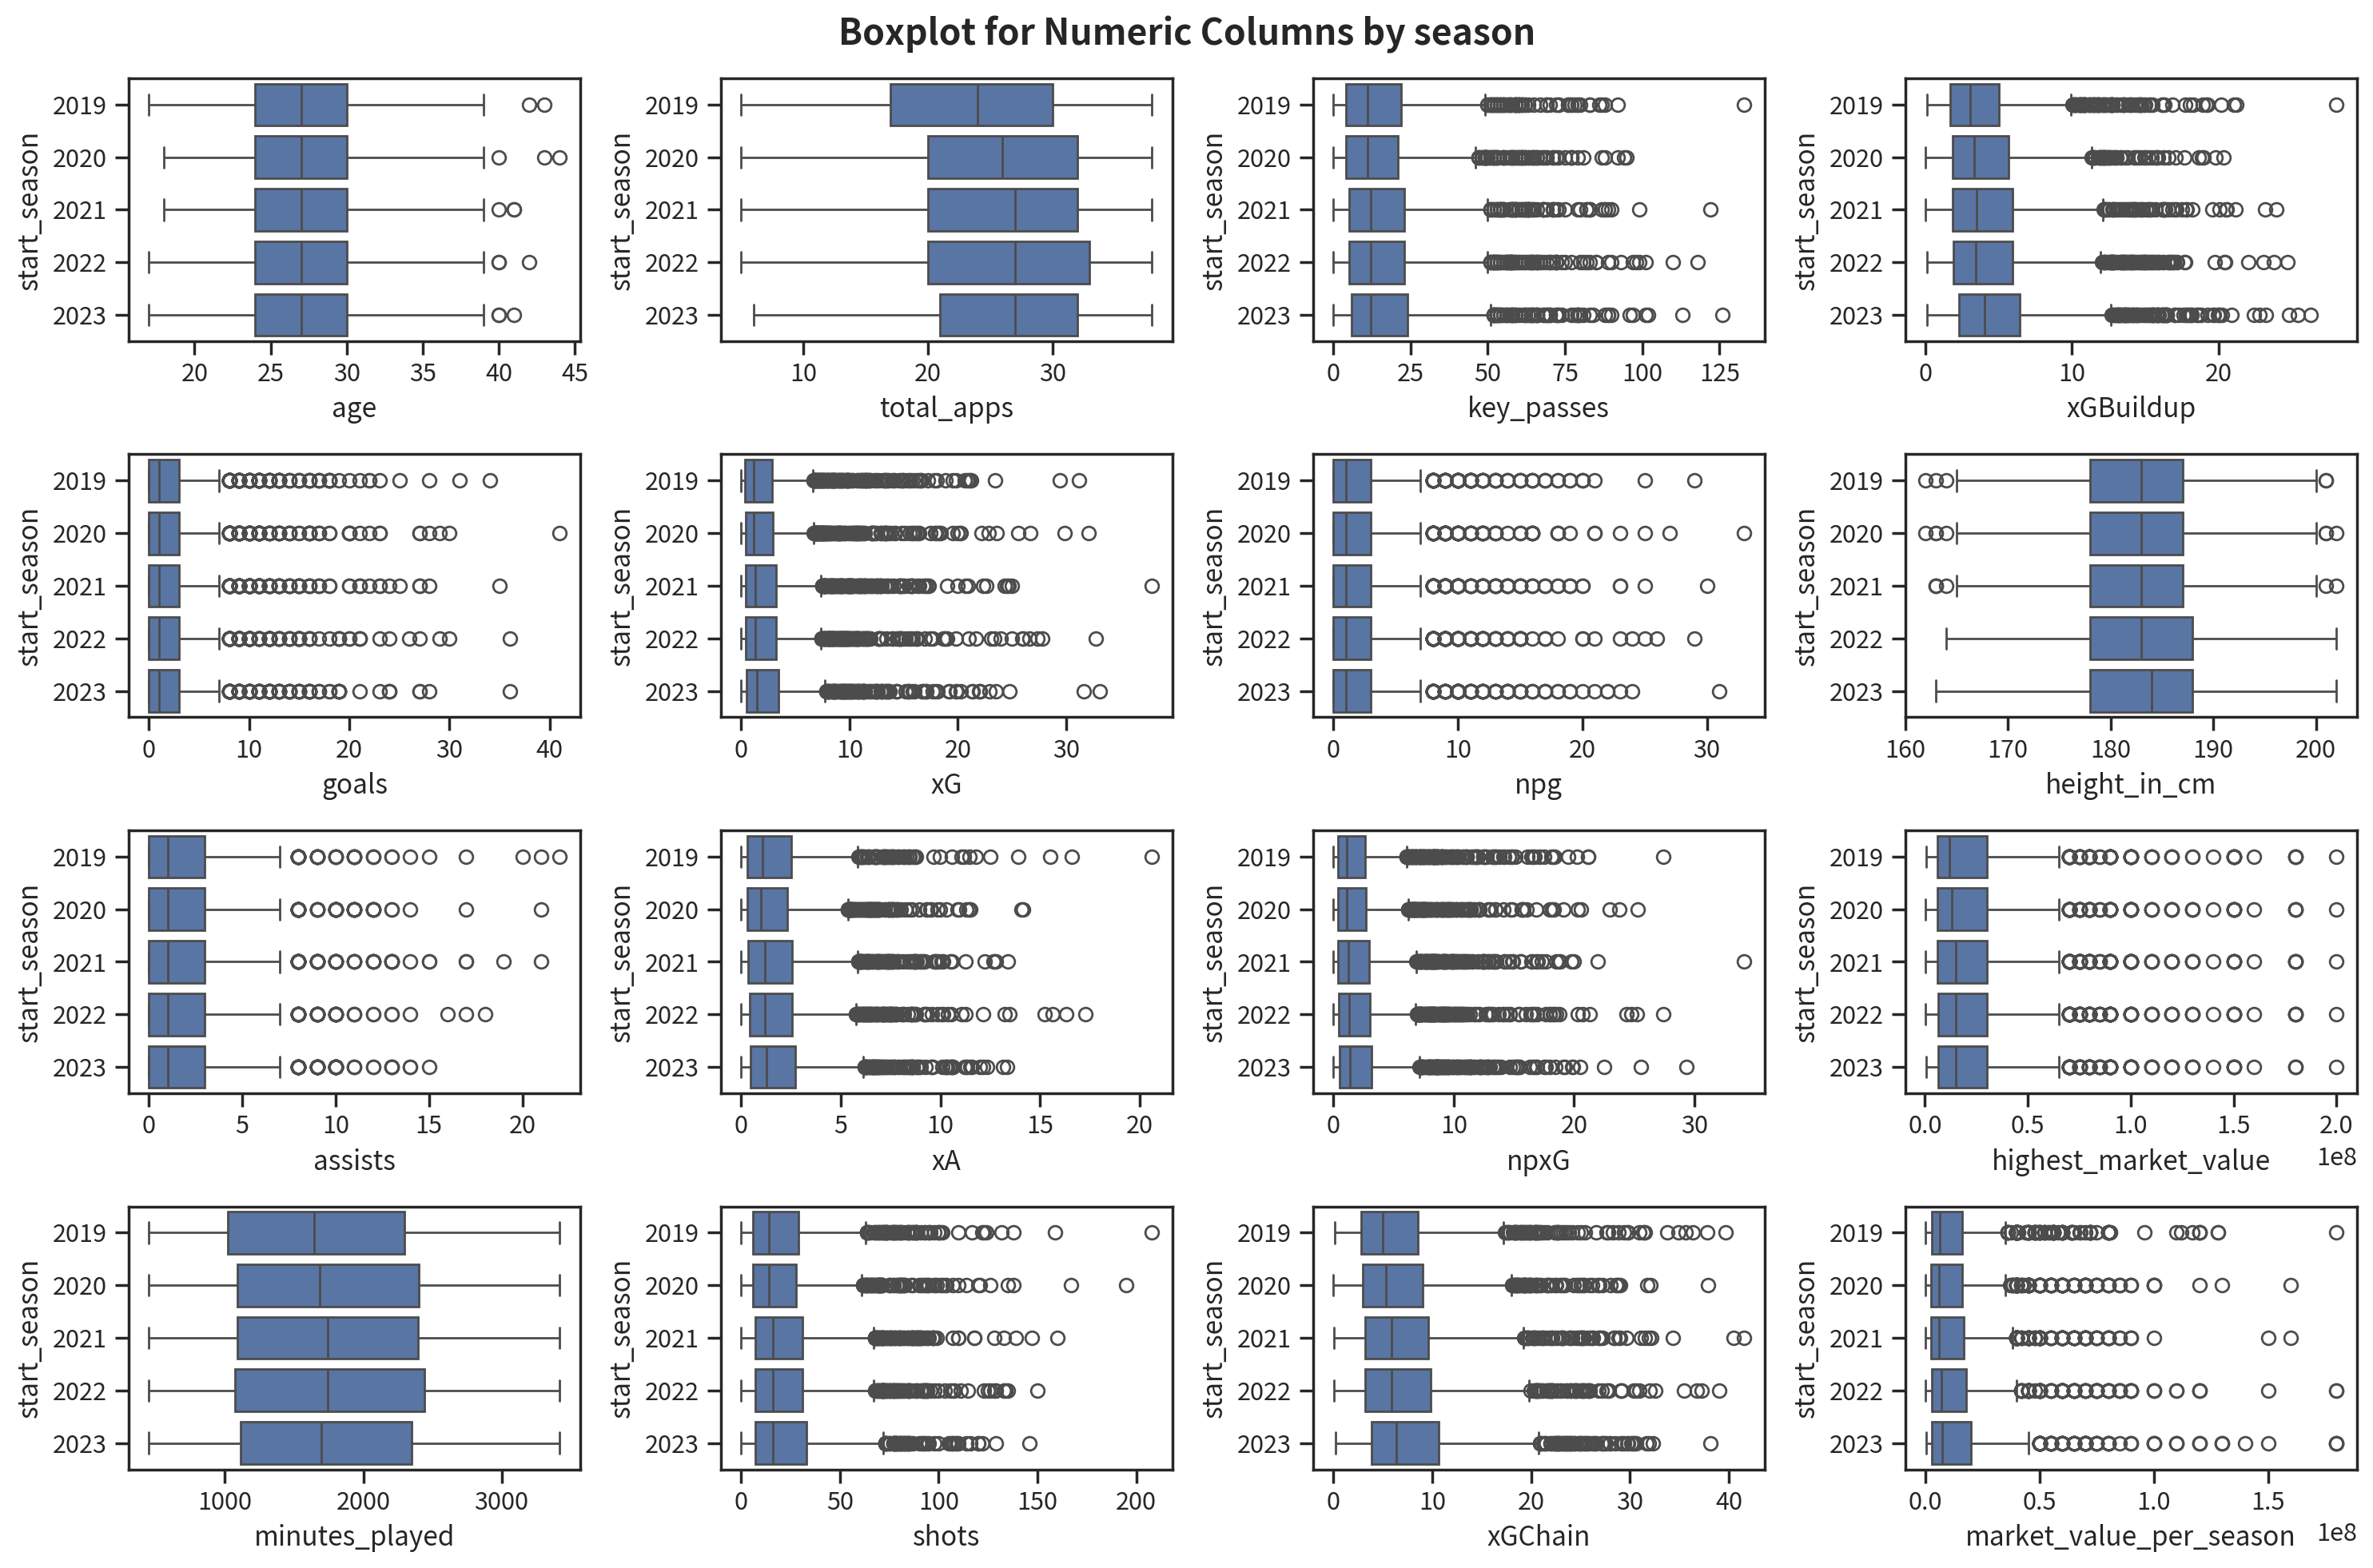

In [26]:
# num_cols에서 yellow_cards, red_cards 제거한 것 num_cols2에 선언
del num_cols[1:3]

# subplot 생성
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols, axes):
    sns.boxplot(data=df_no_duplicate, x=col, ax=ax, y="start_season")
    # sns.stripplot(data=df_no_duplicate, x=col, ax=ax, y="last_season", hue="foot")

plt.suptitle("Boxplot for Numeric Columns by season", fontsize=16, fontweight='bold')

fig.tight_layout()
plt.show()

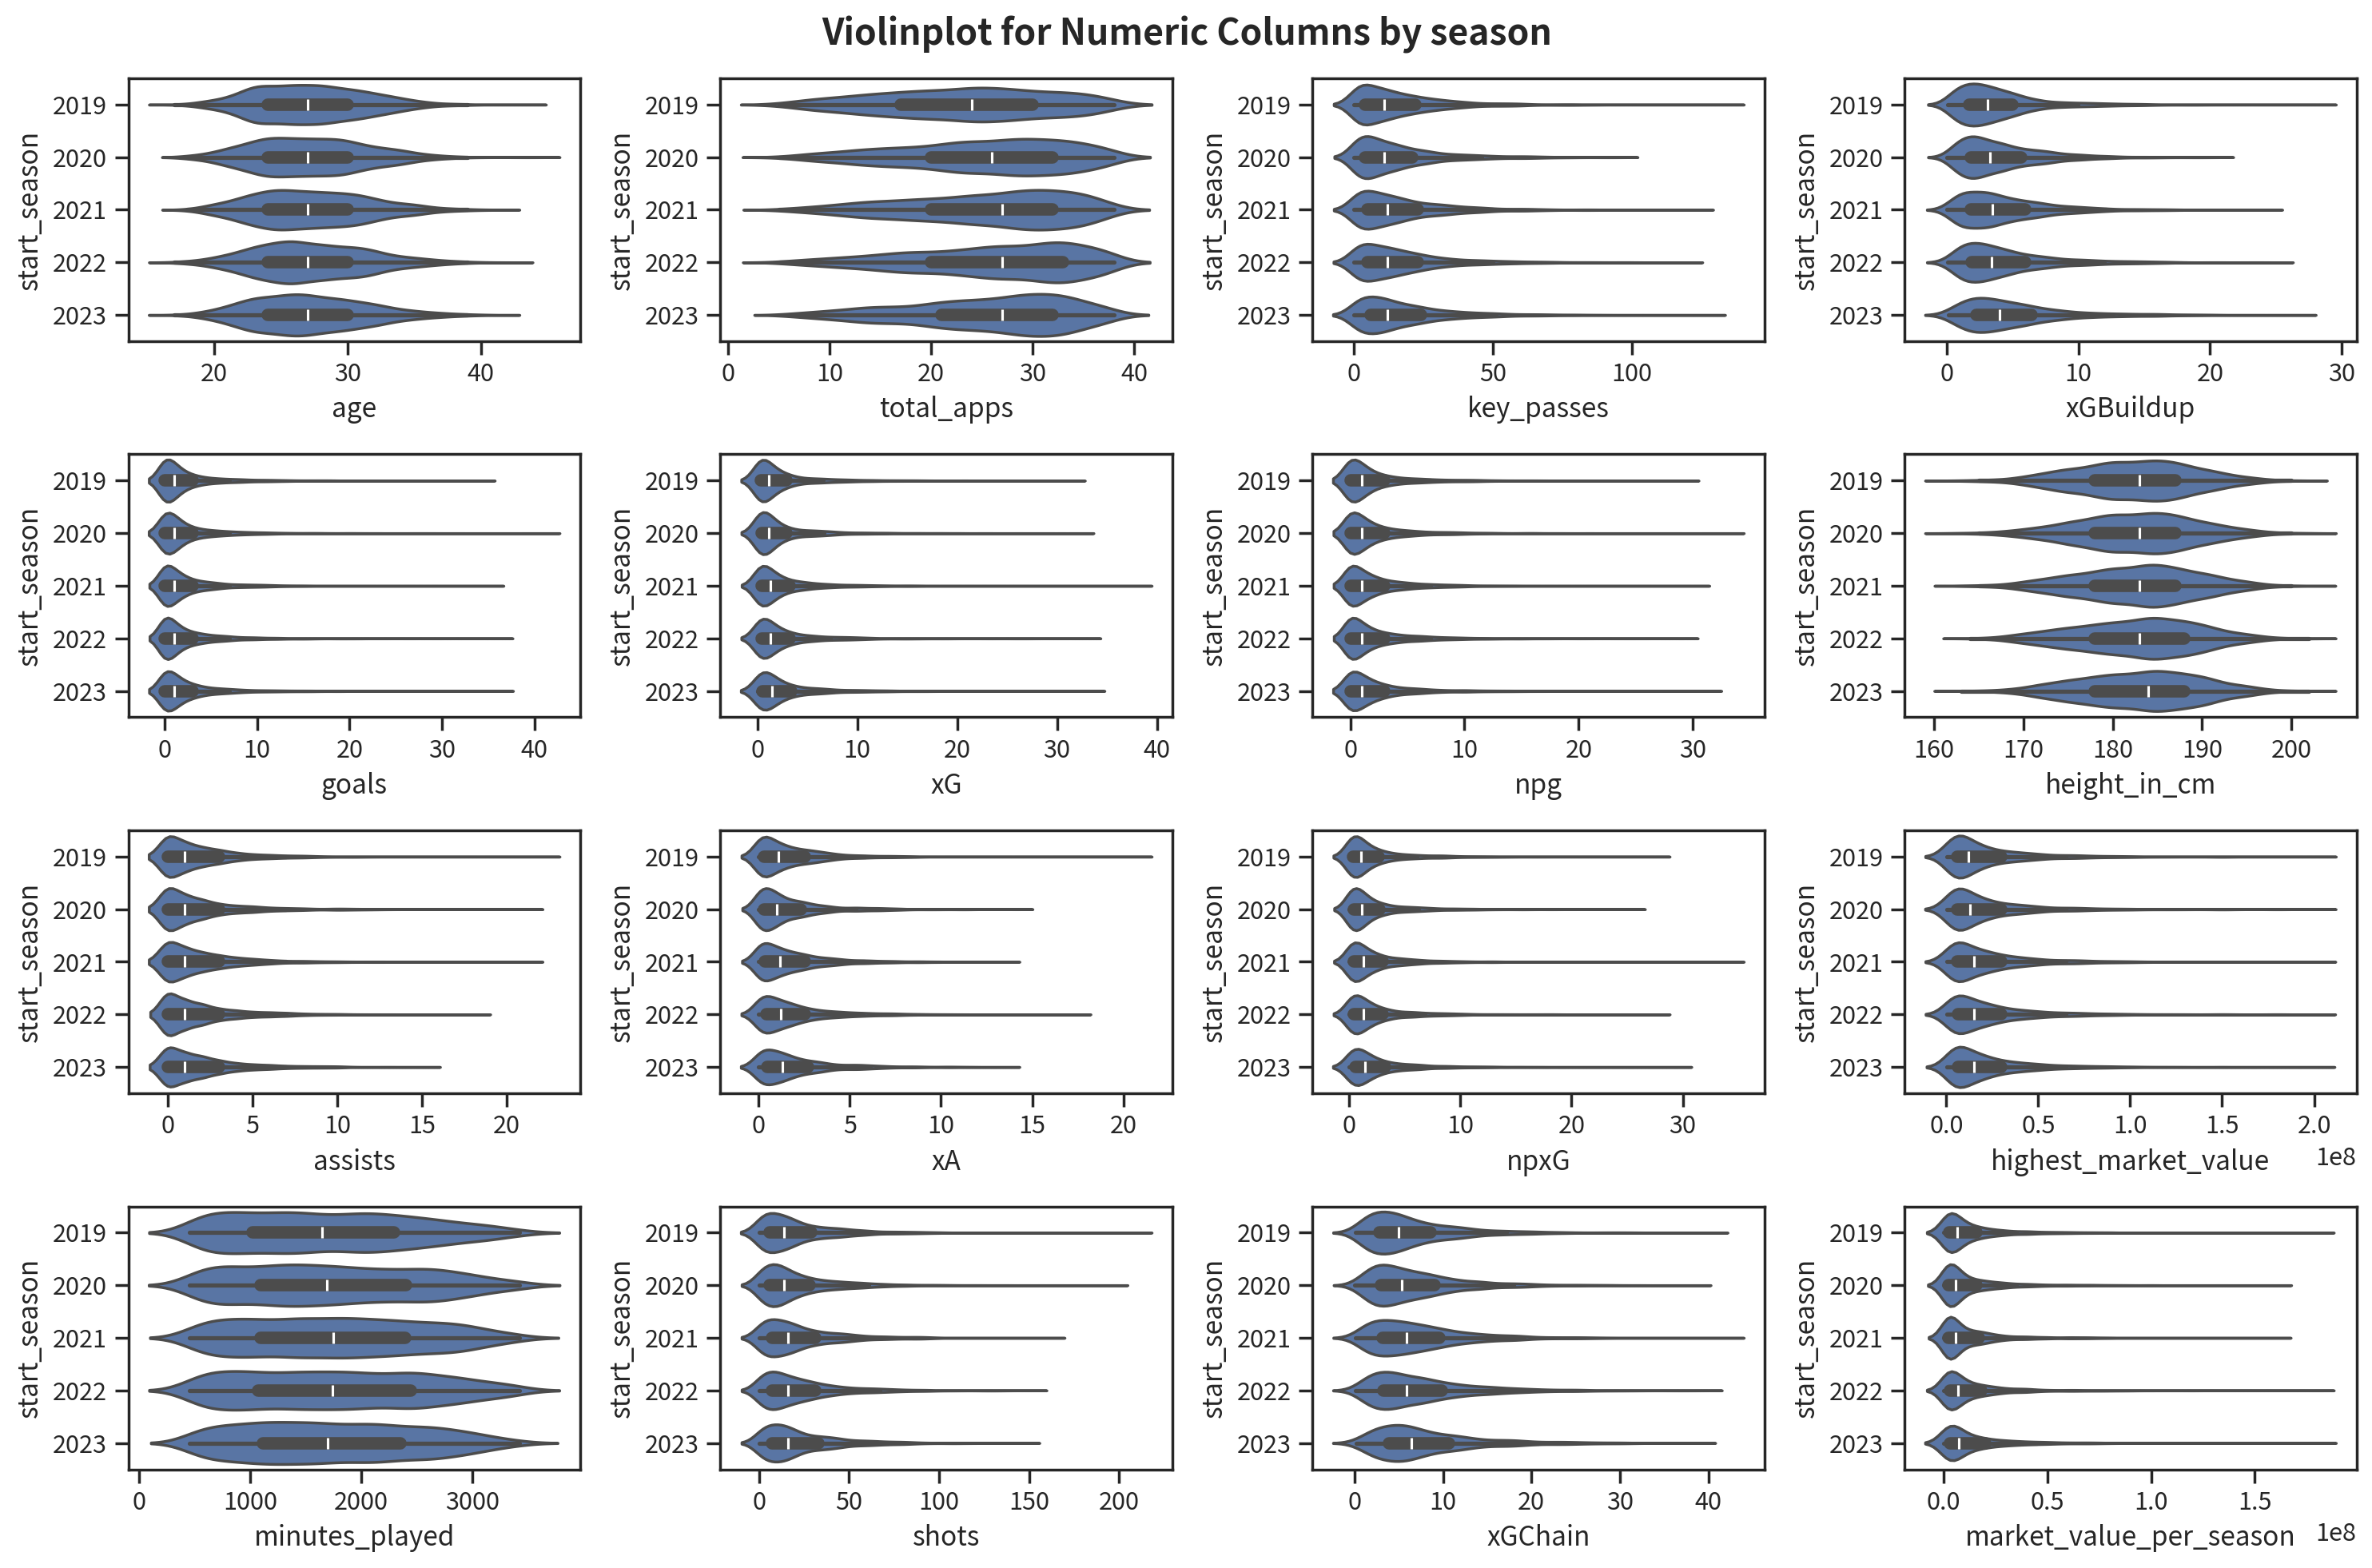

In [27]:
# subplot 생성
nrows, ncols = 4, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))

# flatten()을 통해 axes를 1차원 array로 펴줘야 한다
axes = axes.T.flatten()

for col, ax in zip(num_cols, axes):
    sns.violinplot(data=df_no_duplicate, x=col, ax=ax, y="start_season")
    # sns.stripplot(data=df_no_duplicate, x=col, ax=ax, y="last_season", hue="foot")

plt.suptitle("Violinplot for Numeric Columns by season", fontsize=16, fontweight='bold')

fig.tight_layout()
plt.show()

### 이상치 확인 결과
- 전반적으로 `start_season`에 따라 비슷한 결과

- `goals`, `assists`, `market_value` 등 다양한 곳에서 이상치 존재
    - 그러나 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라지게 나타난다
- 결론 : 이상치 따로 처리하지 않음

## 4. 상관관계 확인

In [28]:
num_cols = df.select_dtypes(include="number").columns.tolist()
df_corr = round(df[num_cols].corr(), 2)

df_corr.style.background_gradient()

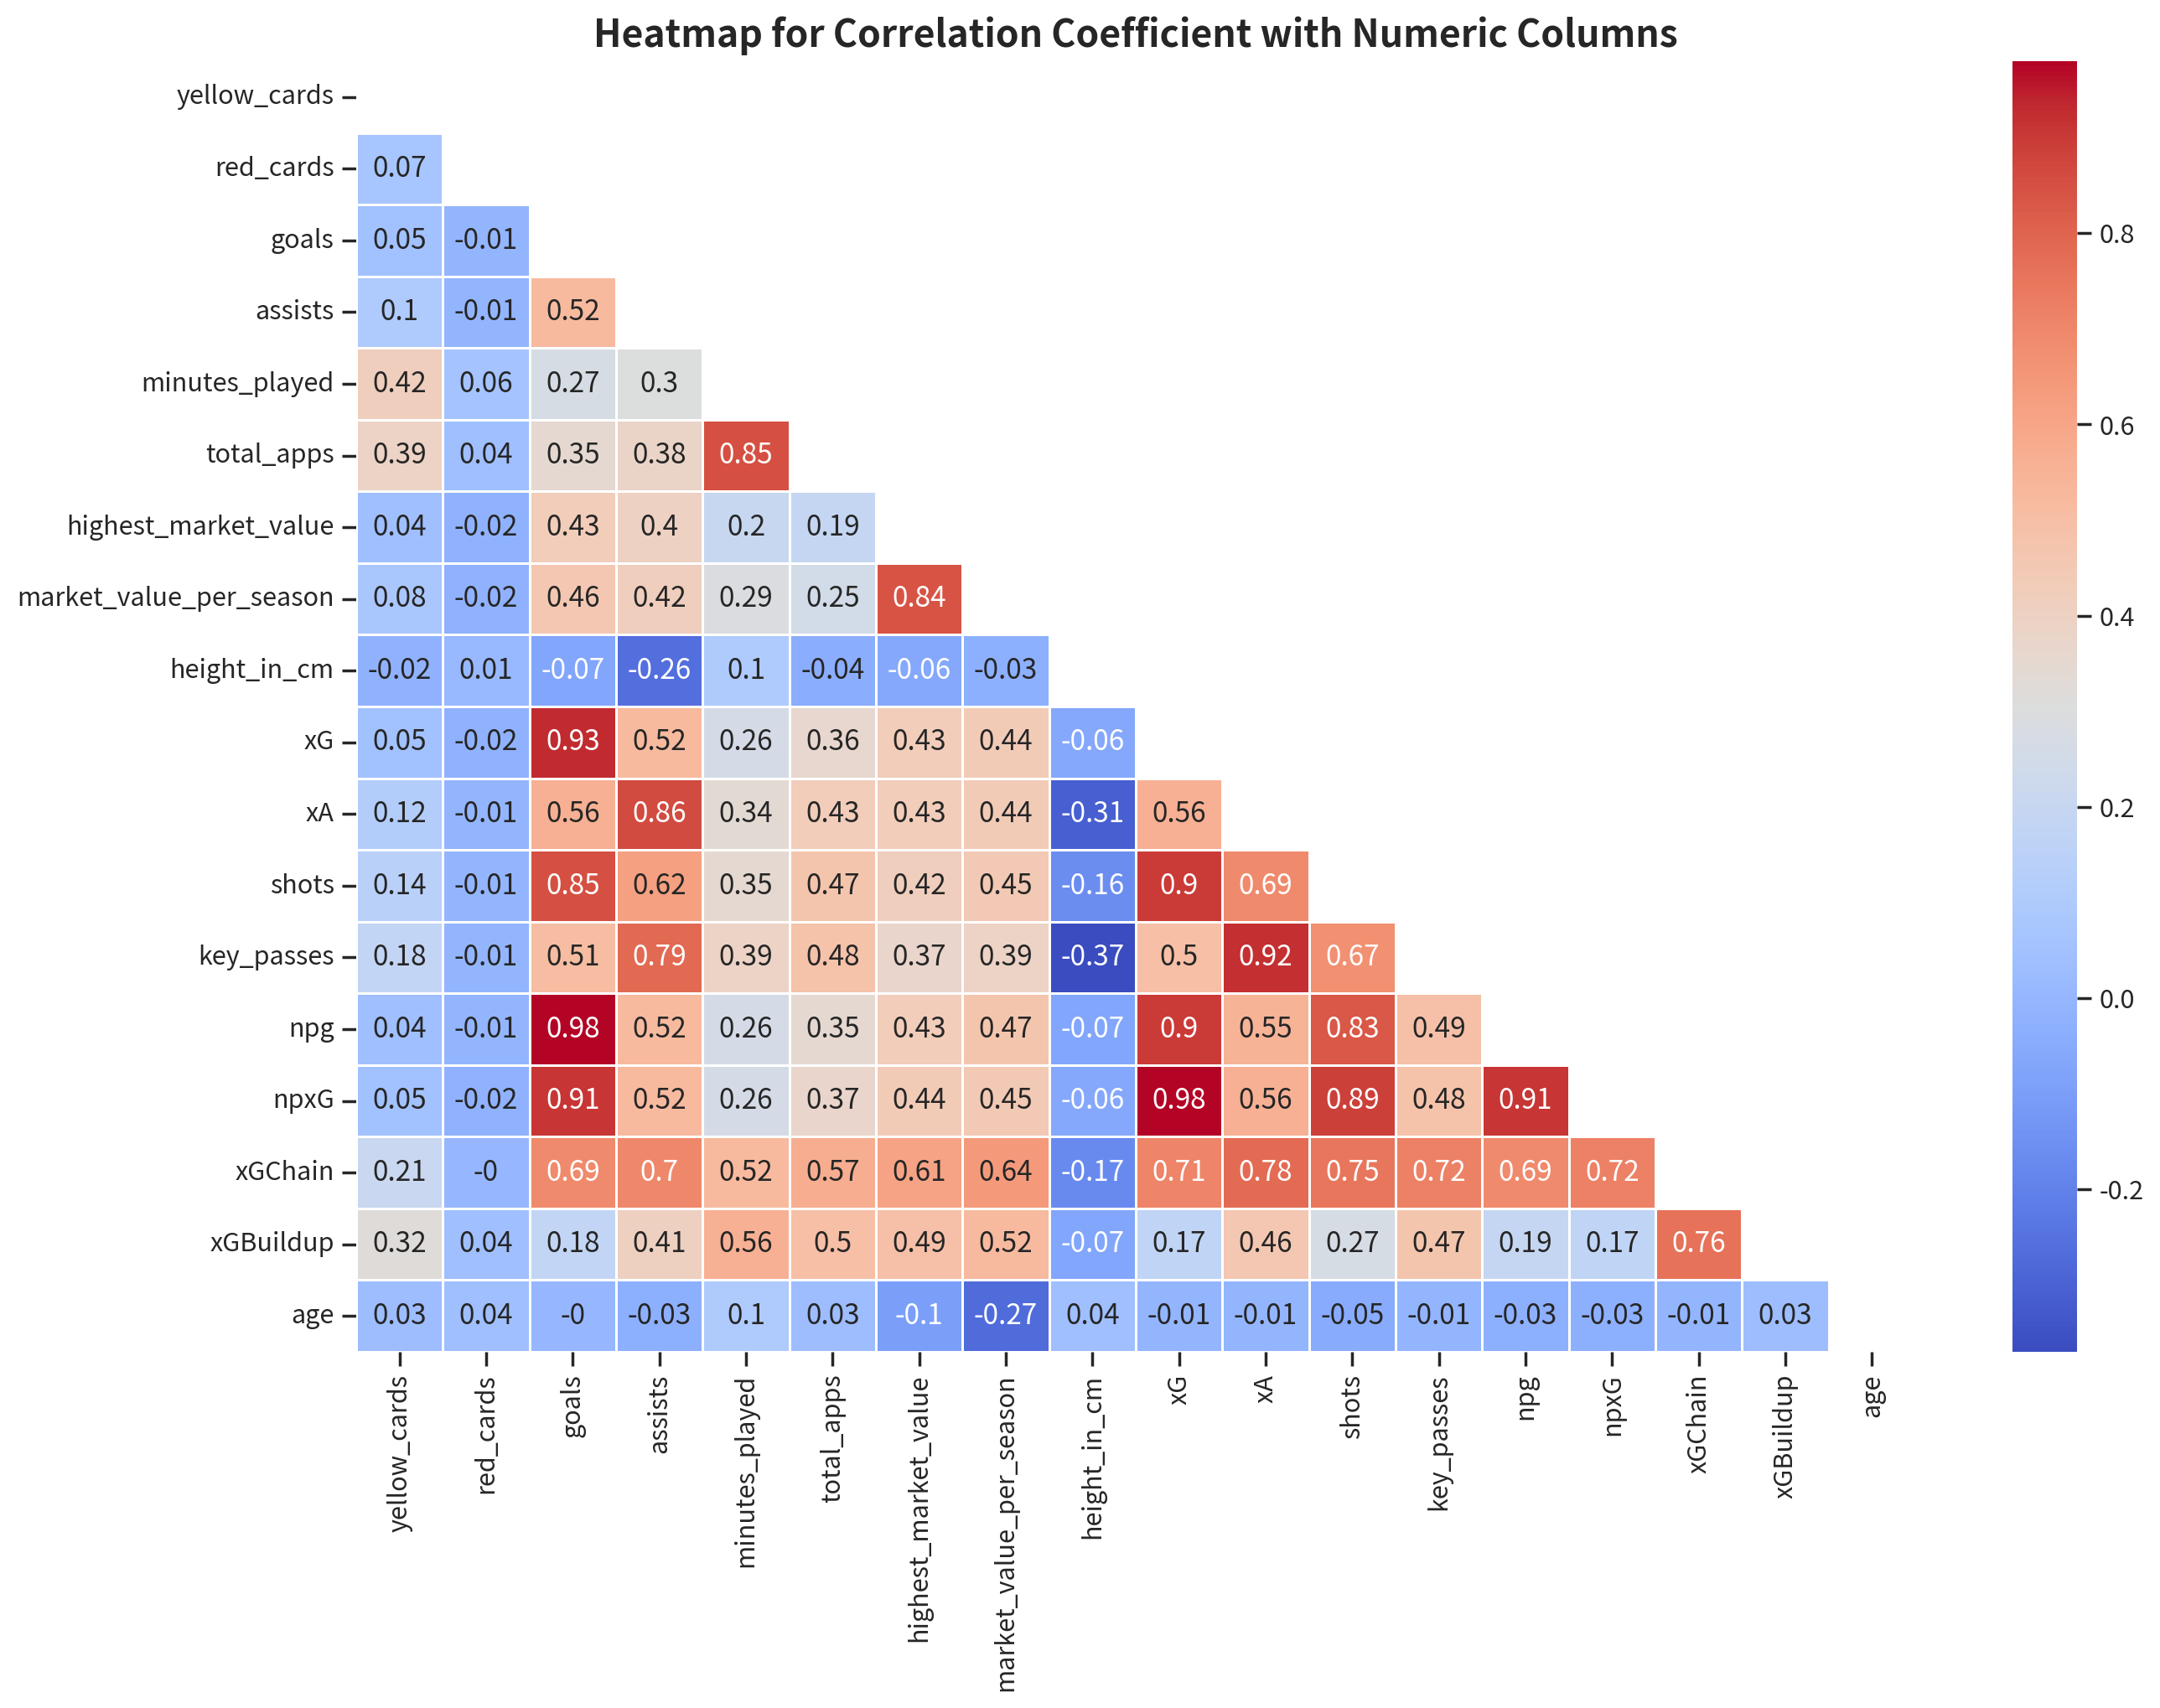

In [29]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

plt.title("Heatmap for Correlation Coefficient with Numeric Columns", fontsize=16, fontweight='bold')
plt.show()

### 4-1. 상관관계 결과
- 매우 강한 상관관계 (0.8 이상)
    - `npg` - `goals`
    - `xG` - `npxG`
    - `xG`- `goals`
    - `xA` - `key_passes`
    - `npxG` - `goals`
    - `goals` - `shots`
    - `xG` - `shots`
    - `shots` - `npxG`
    - `shots` - `npg`
    - `npg` - `npxG`
    - `assists` - `xA`
    - `minutes_played` - `total_apps`
    - `highest_market_value` - `market_value_per_season`
- 강한 상관관계 (0.6 ~ 0.8)
    - `assists` - `key_passes`
    - `xG` - `xGChain`
    - `xA` - `xGChain`
    - `shots` - `xGChain`
    - `key_passes` - `xGChaing`
    - `npxG` - `xGChain`
    - `xGChain` - `xGBuildup`
    - `assists` - `xGChain`
    - `goals` - `xGChain`
    - `market_value_per_season` - `xGChain`
    - `highest_market_value` - `xGChain`
    - `shots` - `key_passes`
    - `xA`- `shots`
- 음의 상관관계 (-0.2 ~ -0.4)
    - `key_passes` - `height_in_cm`
    - `xA` - `height_in_cm`
    - `assists` - `height_in_cm`
    - `age` - `market_value_per_season`

### 4-2. 상관관계 높은 변수들 분포 확인
- 상관관계가 높은 변수 관계 8가지 분포 시각화해본다

    - 매우 강한 상관관계 (0.8 이상)
        - `npg` - `goals`
        - `xG` - `npxG`
        - `xG`- `goals`
        - `xA` - `key_passes`
        - `npxG` - `goals`
        - `goals` - `shots`
        - `xG` - `shots`
        - `shots` - `npxG`

In [30]:
# 상관관계 높은 변수들끼리 짝지워 high_corr에 선언
high_corr = [("xG", "npxG"),
             ("npg", "goals"), 
             ("xG", "goals"), 
             ("xA", "key_passes"),
             ("npxG", "goals"),
             ("xG", "shots"),
             ("shots", "npxG"),
             ("goals", "shots"),
             ]
high_corr

[('xG', 'npxG'),
 ('npg', 'goals'),
 ('xG', 'goals'),
 ('xA', 'key_passes'),
 ('npxG', 'goals'),
 ('xG', 'shots'),
 ('shots', 'npxG'),
 ('goals', 'shots')]

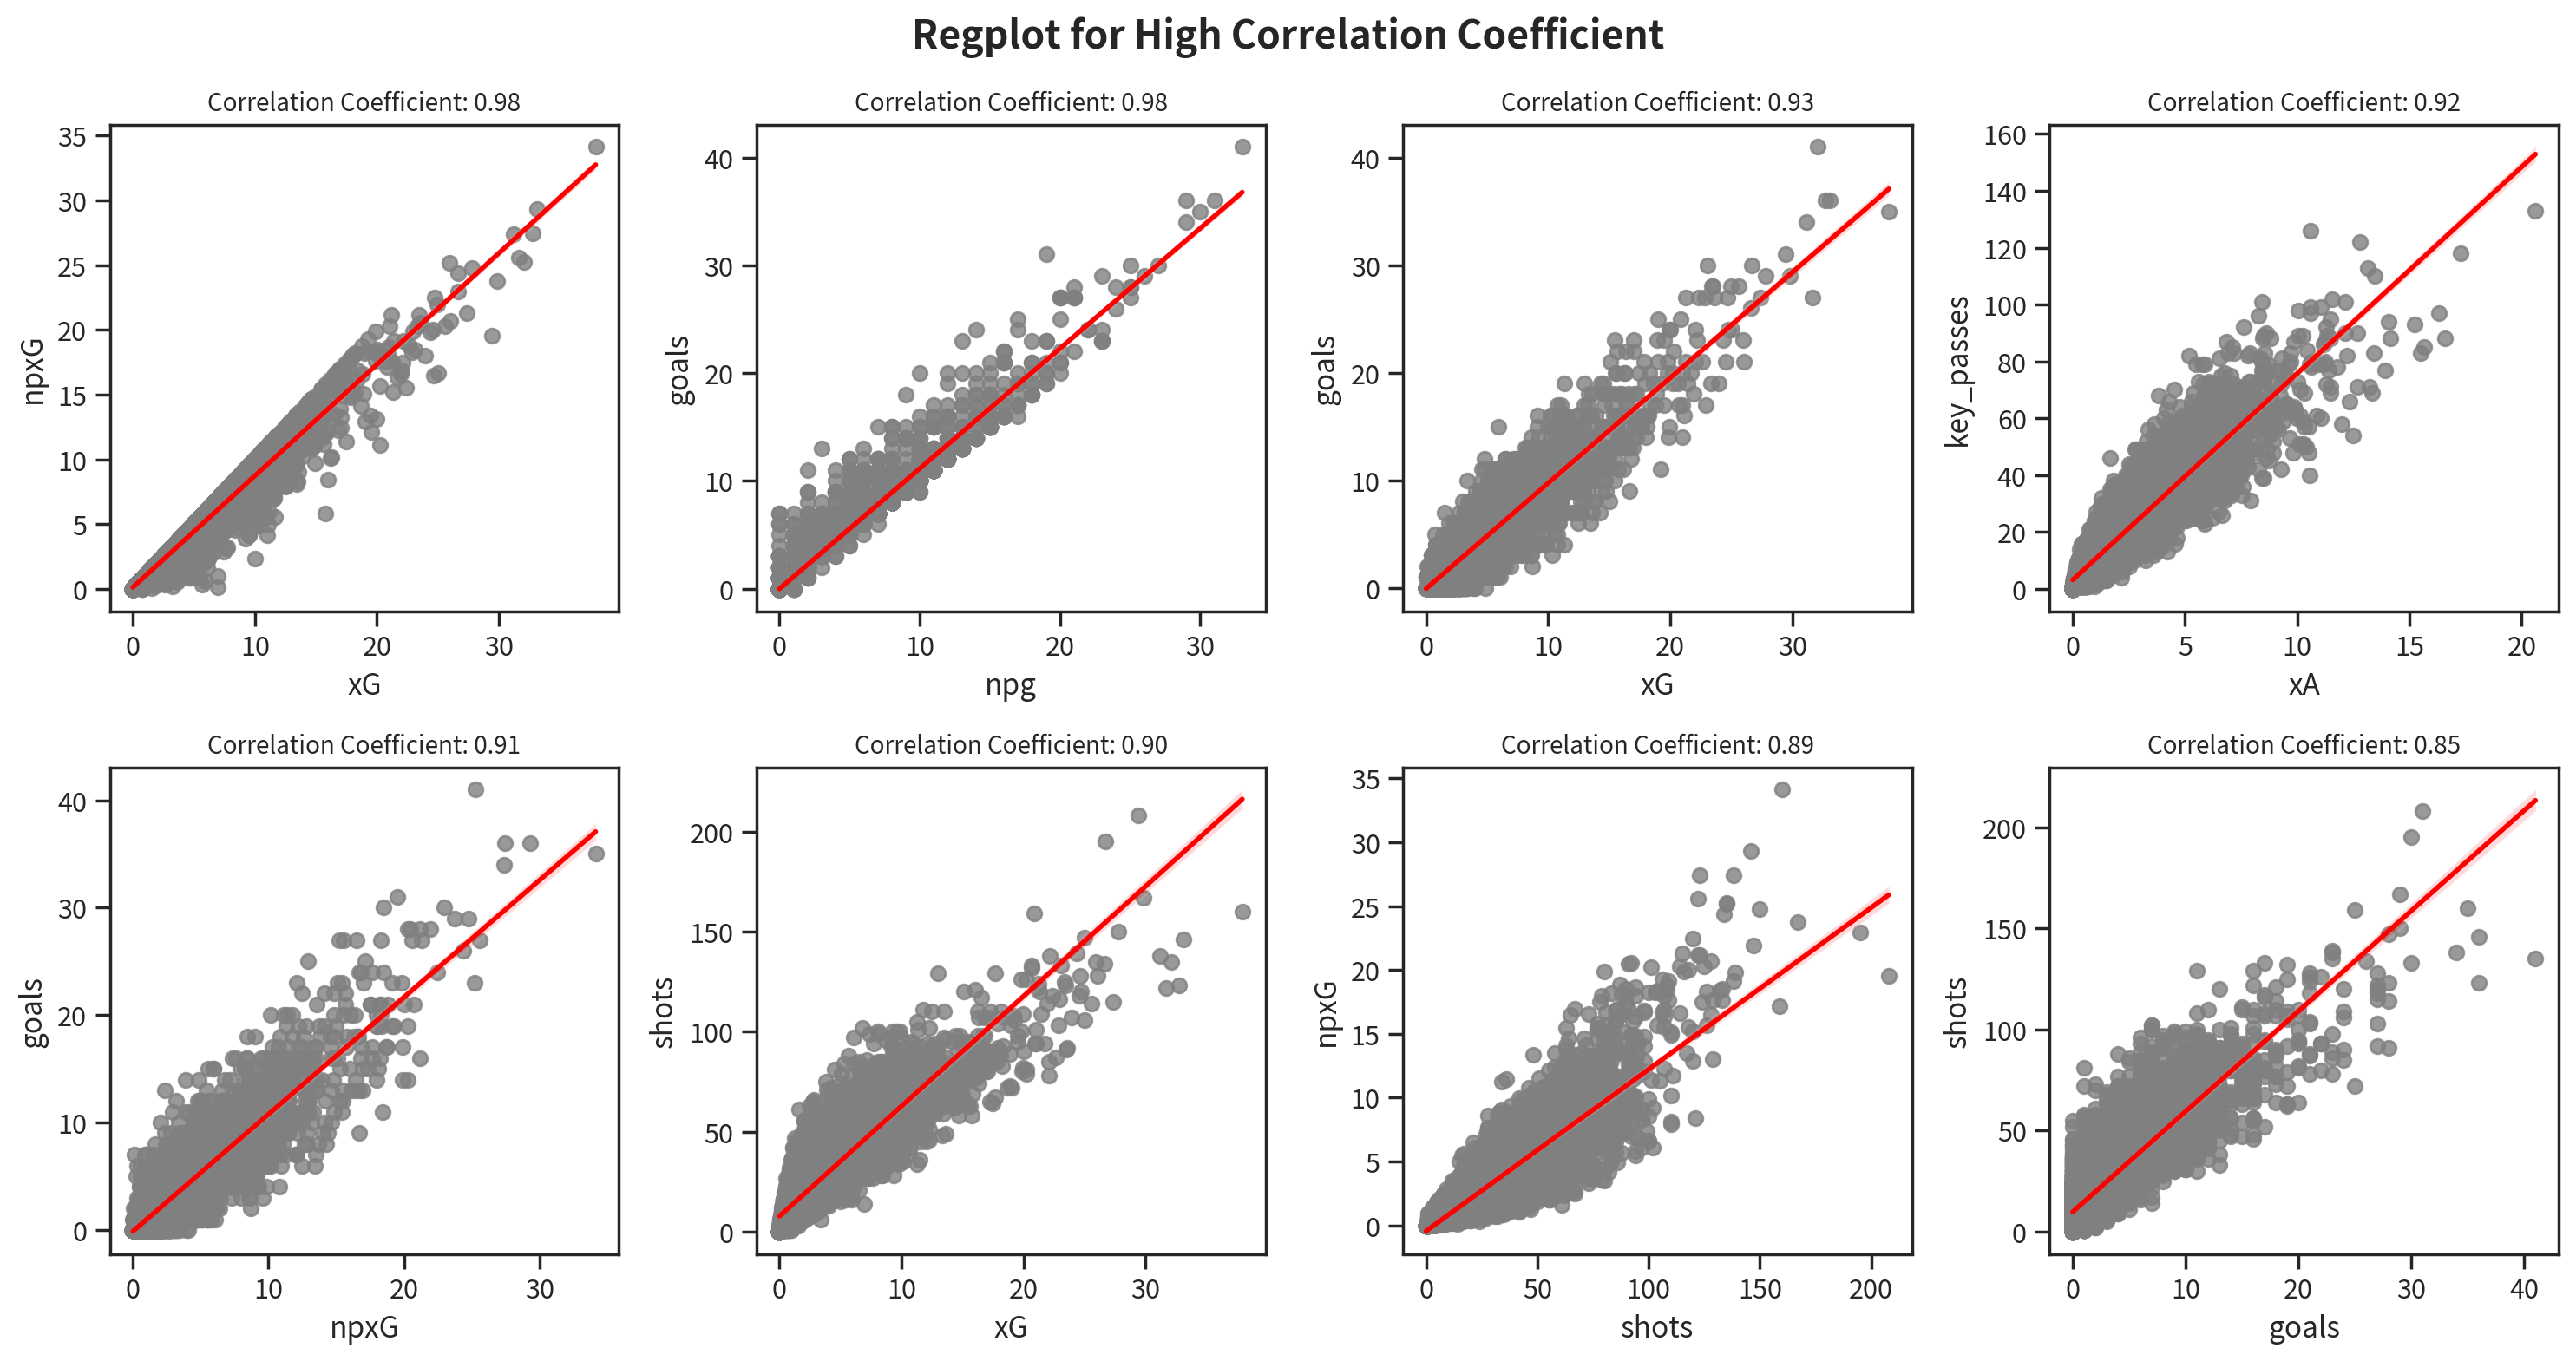

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# 상관관계 분포 시각화
# subplot 생성
nrows, ncols = 2, 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 8))

# flatten()을 통해 axes를 1차원 array로 펴준다
axes = axes.flatten()

# regplot 그려서 추세선과 상관관계 확인
for (x_var, y_var), ax in zip(high_corr, axes):
    sns.regplot(x=df[x_var],
                y=df[y_var],
                ax=ax,
                scatter_kws={"color": "gray"},
                line_kws={"color": "red", "lw": 2})
    
    # 상관계수 계산
    corr, _ = pearsonr(df[x_var], df[y_var])
    
    # 서브플롯 제목에 상관계수 추가
    ax.set_title(f'Correlation Coefficient: {corr:.2f}', fontsize=10)

# 전체 제목 설정
plt.suptitle('Regplot for High Correlation Coefficient', fontsize=16, fontweight='bold')

# 레이아웃 조정
# plt.tight_layout(rect=[0, 0, 1, 0.95])  # suptitle과 겹치지 않게 조정
plt.tight_layout()
plt.show()


## 5. 다중 공선성
- 하나의 독립 변수가 여러개의 독립 변수들로 잘 예측되는 경우를 의미한다
- 독립 변수들이 서로 독립이 아니라, 상호 상관관계가 강한 경우 발생
- 일반적으로 어떤 독립 변수의 영향력을 파악할 때, 확인하려는 변수의 영향력만을 판단하기 위해 다른 독립 변수들은 모두 일정하다고 가정한다.
- 그러나 만약 두 독립 변수가 서로에게 영향을 주고 있다면, 하나의 영향력을 검증할 때 다른 하나의 영향력을 완전히 통제할 수 없게 된다
    - 이러한 상황에서는 도출된 해석이 타당하다고 볼 수 없다
    
- 다중 공선성이 존재한다면 모델 구축 시 발생하는 상황
    - 계수 추정이 잘 되지 않거나, 불안정해져서 데이터가 약간만 바뀌어도 추정치 크게 달라짐
    - 계수가 통계적으로 유의미하지 않은 것처럼 도출
    - 과적합의 위험성
    - 특히 회귀 분석에 큰 영향 미친다 (분류는 영향 크게 미칠때도 있고 별로 상관 없을 때도 있음)
- References
    - https://dacon.io/codeshare/4443
    - https://datascienceschool.net/03%20machine%20learning/06.04%20%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EA%B3%BC%20%EB%B3%80%EC%88%98%20%EC%84%A0%ED%83%9D.html
    - https://dacon.io/forum/408387

### 5-1. 다중 공선성 진단
- 분산팽창계수 (VIF, Variance Inflation Factor)를 구한다
- 일반적으로 5 또는 10보다 크면 다중 공선성이 있다고 판단한다

- VIF : 독립변수를 다른 독립변수로 선형회귀한 성능을 나타낸 지표
    - 다른 변수에 의존적일 수록 VIF가 증가

In [32]:
# 출처 : https://aliencoder.tistory.com/17

def feature_engineering_XbyVIF(df):
    # NaN 값이 있는 경우 처리
    if df.isnull().values.any():
        raise ValueError("데이터프레임에 NaN 값이 포함되어 있습니다. NaN 값을 처리해 주세요.")
    
    # 스케일링 (VIF는 스케일에 민감하지 않으나 수렴 문제 방지를 위해 일반적으로 스케일링을 적용)
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]
    vif['Feature'] = df.columns
    
    return vif

vif = feature_engineering_XbyVIF(df[num_cols])
print(vif)

    VIF_Factor                  Feature
0     1.309686             yellow_cards
1     1.012130                red_cards
2   258.082897                    goals
3     3.819758                  assists
4     4.691653           minutes_played
5     4.507282               total_apps
6     3.892310     highest_market_value
7     4.668485  market_value_per_season
8     1.359275             height_in_cm
9   322.399442                       xG
10   13.367392                       xA
11    8.203132                    shots
12    8.309855               key_passes
13  202.342374                      npg
14  275.009506                     npxG
15   56.447219                  xGChain
16   21.309970                xGBuildup
17    1.272995                      age


### 5-2. 다중 공선성 해결 방법
- 다중 공선성을 갖는 독립 변수 중 하나 혹은 일부를 제거한다
    - 단 회귀 모형의 R-square 값을 유지 또는 개선시키는 방향으로만 수행해야 한다
- 변수를 변형시키거나 새로운 관측치를 이용한다
- 자료를 수집하는 현장의 상황을 보아 상관관계의 이유를 파악하여 해결한다
- 주성분 분석 (Principle Component Analysis, PCA)을 이용한 diagonal matrix의 형태로 공선성을 없애준다

- References
    - https://aliencoder.tistory.com/17

In [33]:
# num_cols

In [34]:
# 유사한 의미를 가진 컬럼 제거한 후 다중공선성 확인
# total_apps - minutes_played 유사
# highest_market_value - market_value_per_season 유사
# npg - goals 유사
# npxG - xG 유사

# total_apps, highest_market_value, npg, npxG 제거한 데이터프레임 다중 공선성 확인해본다
feature_engineering_XbyVIF(df[['yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played',
                              'market_value_per_season', 'height_in_cm', 'xG', 'xA', 'shots',
                              'key_passes', 'xGChain', 'xGBuildup', 'age']])

VIF_Factor                  Feature
0     1.301264             yellow_cards
1     1.011188                red_cards
2     7.975060                    goals
3     3.815649                  assists
4     1.878134           minutes_played
5     2.044122  market_value_per_season
6     1.326742             height_in_cm
7    20.486902                       xG
8    12.492796                       xA
9     7.831740                    shots
10    8.217321               key_passes
11   36.357331                  xGChain
12   14.573327                xGBuildup
13    1.195490                      age

### 5-3. 다중 공선성 결론
- VIF가 크더라도 분석에 꼭 필요한 Feature라면 살리는 것이 좋다
    - `goals`, `xG`, `xA`, `shots`, `key_passes`, `xGChain`, `xGBuildup` 등은 축구선수를 평가할 때 중요한 스탯
    - 일단 모델 생성해본 후, R-square 값을 개선시키는 방향으로 다중 공선성 다시 확인해 본다
- references
    - https://recipesds.tistory.com/entry/%EC%9C%A0%EC%9D%98%ED%95%98%EC%A7%80-%EC%95%8A%EC%9D%80-%EA%B3%84%EC%88%98%EB%A5%BC-%EC%96%B4%EC%A9%90%EB%8B%A4-%EA%B1%8D-%EB%B2%84%EB%A6%B4%EA%B9%8C-%EB%8B%A4%EC%A4%91%EA%B3%B5%EC%84%A0%EC%84%B1%EC%9D%80-%EC%95%85%EB%8B%B9%EC%9D%BC%EA%B9%8C-%EC%83%81%EA%B4%80%EC%9D%B4%EB%82%98-VIF%EB%86%92%EC%9C%BC%EB%A9%B4-%EB%8B%A4-%EC%97%86%EC%95%A8%EA%B9%8C
        

In [35]:
#  total_apps, highest_market_value  npg, npxG 제거한 데이터프레임을 df에 선언
df = df.drop(["total_apps", "highest_market_value", "npg", "npxG"], axis=1)
df.head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín         2019           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri         2019           6.0        0.0    4.0      1.0   
2      Achraf Hakimi         2019           5.0        0.0    5.0     10.0   

   minutes_played competition_code date_of_birth            position  \
0          1795.0       bundesliga    1997-04-22           Left-Back   
1          1035.0       bundesliga    1996-11-28  Attacking Midfield   
2          2717.0       bundesliga    1998-11-04          Right-Back   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
0            Genoa CFC               10500000.0    Spain   left         178.0   
1       ACF Fiorentina                1700000.0  Morocco  right         186.0   
2  Paris Saint-Germain               54000000.0  Morocco  right         181.0   

         xG        xA  shots  key_passes    xGChain  xGBuildup  age  
0  0.294448  3.250888    9.0        32.0   3.658402   2.195273   23  
1  3.468877  0.232751   43.0         7.0   1.644770   0.885899   23  
2  5.067438  5.510969   38.0        36.0  24.144373  16.293885   21

## 6. 파생 변수 생성

In [36]:
df_copy = df.copy()

# yellow card, red card 컬럼을 합쳐서 aggression 컬럼 생성
# yellow card를 2번 받으면 red card와 같기 때문에, 가중치 0.3, 0.7 각각 곱해준다
df_copy["aggression"] = (df_copy["yellow_cards"] * 0.3) + (df_copy["red_cards"] * 0.7)

# minutes_played를 90으로 나누어, 90분으로 환산했을 때 몇 경기 뛰었는지 확인해본다
df_copy["90s"] = round(df_copy["minutes_played"] / 90, 1)
# df_copy.drop(columns=["yellow_cards", "red_cards", "minutes_played"], inplace=True)

In [37]:
def divide_cols(df, col_list, denominator, denominator_name):
    # '90s' 값이 0인 경우를 NaN으로 대체해 나눗셈 시 inf가 발생하지 않도록 처리
    for col in col_list:
        col_name = f"{col}_{denominator_name}"
        df[col_name] = np.where(df["90s"] == 0, np.nan, round(df[col] / df[denominator], 2))

    df = df.fillna(0)
    return df

In [ ]:
# "goals", "assists", "aggression", "xG", "xA", "shots", "key_passes", "xGChain", "xGBuildup"을 90분당 몇개 기록했는지 확인
df_copy = divide_cols(df_copy, 
                     ["goals", "assists", "aggression", "xG", "xA", "shots", "key_passes", "xGChain", "xGBuildup"],
                     "90s", "90")
df_copy.head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín         2019           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri         2019           6.0        0.0    4.0      1.0   
2      Achraf Hakimi         2019           5.0        0.0    5.0     10.0   

   minutes_played competition_code date_of_birth            position  \
0          1795.0       bundesliga    1997-04-22           Left-Back   
1          1035.0       bundesliga    1996-11-28  Attacking Midfield   
2          2717.0       bundesliga    1998-11-04          Right-Back   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
0            Genoa CFC               10500000.0    Spain   left         178.0   
1       ACF Fiorentina                1700000.0  Morocco  right         186.0   
2  Paris Saint-Germain               54000000.0  Morocco  right         181.0   

         xG        xA  shots  key_passes    xGChain  xGBuildup  age  \
0  0.294448  3.250888    9.0        32.0   3.658402   2.195273   23   
1  3.468877  0.232751   43.0         7.0   1.644770   0.885899   23   
2  5.067438  5.510969   38.0        36.0  24.144373  16.293885   21   

   aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
0         0.6  19.9      0.00        0.00           0.03   0.01   0.16   
1         1.8  11.5      0.35        0.09           0.16   0.30   0.02   
2         1.5  30.2      0.17        0.33           0.05   0.17   0.18   

   shots_90  key_passes_90  xGChain_90  xGBuildup_90  
0      0.45           1.61        0.18          0.11  
1      3.74           0.61        0.14          0.08  
2      1.26           1.19        0.80          0.54

In [39]:
# xg per shot, goal_conv, goal_vs_xg 생성

# xg per shot
df_copy = divide_cols(df_copy, ["xG"], "shots", "shots")

# goal_conv 생성
df_copy = divide_cols(df_copy, ["goals"], "shots", "shots")

# column 명 변경
df_copy = df_copy.rename(columns={"xG_shots" : "xG_per_shot", "goals_shots" : "goal_conv"})

df_copy["xG_vs_goal"] = df_copy["xG"] - df_copy["goals"]

In [40]:
df_copy.sort_values(by="xGChain_90", ascending=False).head()

player_name start_season  yellow_cards  red_cards  goals  assists  \
9323  Kylian Mbappé         2019           0.0        0.0   18.0      7.0   
416   Thomas Müller         2019           5.0        0.0    8.0     21.0   
9417         Neymar         2019           4.0        0.0   13.0      6.0   
1784  Thomas Müller         2022           0.0        0.0    7.0      8.0   
394    Serge Gnabry         2019           0.0        0.0   12.0     11.0   

      minutes_played competition_code date_of_birth        position  \
9323          1515.0          ligue-1    1998-12-20  Centre-Forward   
416           2261.0       bundesliga    1989-09-13  Second Striker   
9417          1322.0          ligue-1    1992-02-05     Left Winger   
1784          1668.0       bundesliga    1989-09-13  Second Striker   
394           2203.0       bundesliga    1995-07-14    Right Winger   

        current_club_name  market_value_per_season  country   foot  \
9323  Paris Saint-Germain              180000000.0   France  right   
416         Bayern Munich               30000000.0  Germany  right   
9417  Paris Saint-Germain              128000000.0   Brazil  right   
1784        Bayern Munich               12000000.0  Germany  right   
394         Bayern Munich               72000000.0  Germany  right   

      height_in_cm         xG         xA  shots  key_passes    xGChain  \
9323         178.0  16.572055  10.575325   88.0        40.0  29.428358   
416          185.0   8.575405  15.506240   53.0        83.0  36.356539   
9417         175.0  14.725106   5.246025   70.0        38.0  21.302691   
1784         185.0   9.138496   8.518349   46.0        39.0  25.591876   
394          176.0  14.172484  12.498704   95.0        54.0  33.750423   

      xGBuildup  age  aggression   90s  goals_90  assists_90  aggression_90  \
9323   6.044631   21         0.0  16.8      1.07        0.42           0.00   
416   18.292041   31         1.5  25.1      0.32        0.84           0.06   
9417   7.206127   28         1.2  14.7      0.88        0.41           0.08   
1784  11.054752   34         0.0  18.5      0.38        0.43           0.00   
394   12.322838   25         0.0  24.5      0.49        0.45           0.00   

      xG_90  xA_90  shots_90  key_passes_90  xGChain_90  xGBuildup_90  \
9323   0.99   0.63      5.24           2.38        1.75          0.36   
416    0.34   0.62      2.11           3.31        1.45          0.73   
9417   1.00   0.36      4.76           2.59        1.45          0.49   
1784   0.49   0.46      2.49           2.11        1.38          0.60   
394    0.58   0.51      3.88           2.20        1.38          0.50   

      xG_per_shot  goal_conv  xG_vs_goal  
9323         0.19       0.20   -1.427945  
416          0.16       0.15    0.575405  
9417         0.21       0.19    1.725106  
1784         0.20       0.15    2.138496  
394          0.15       0.13    2.172484

In [41]:
# df_copy.drop(columns=["goals", "assists", "aggression", "90s"], inplace=True)

### 6-1. 파생변수 생성 후 상관관계 확인

In [42]:
# "total_apps", "highest_market_value", "npg", "npxG" 제거한 데이터프레임의 상관관계 확인
# 90으로 나눈 컬럼들 사용

# df_corr2 = df_copy[df_copy.select_dtypes(include=np.number).columns.tolist()].corr()
df_corr2 = df_copy[["age", "market_value_per_season", "height_in_cm",
                    "90s", "goals_90", "assists_90", "aggression_90", "xG_90", 
                    "xA_90", "shots_90", "key_passes_90", "xGChain_90", "xGBuildup_90",
                    "xG_per_shot", "goal_conv", "xG_vs_goal"
                    ]].corr()


df_corr2.style.background_gradient()

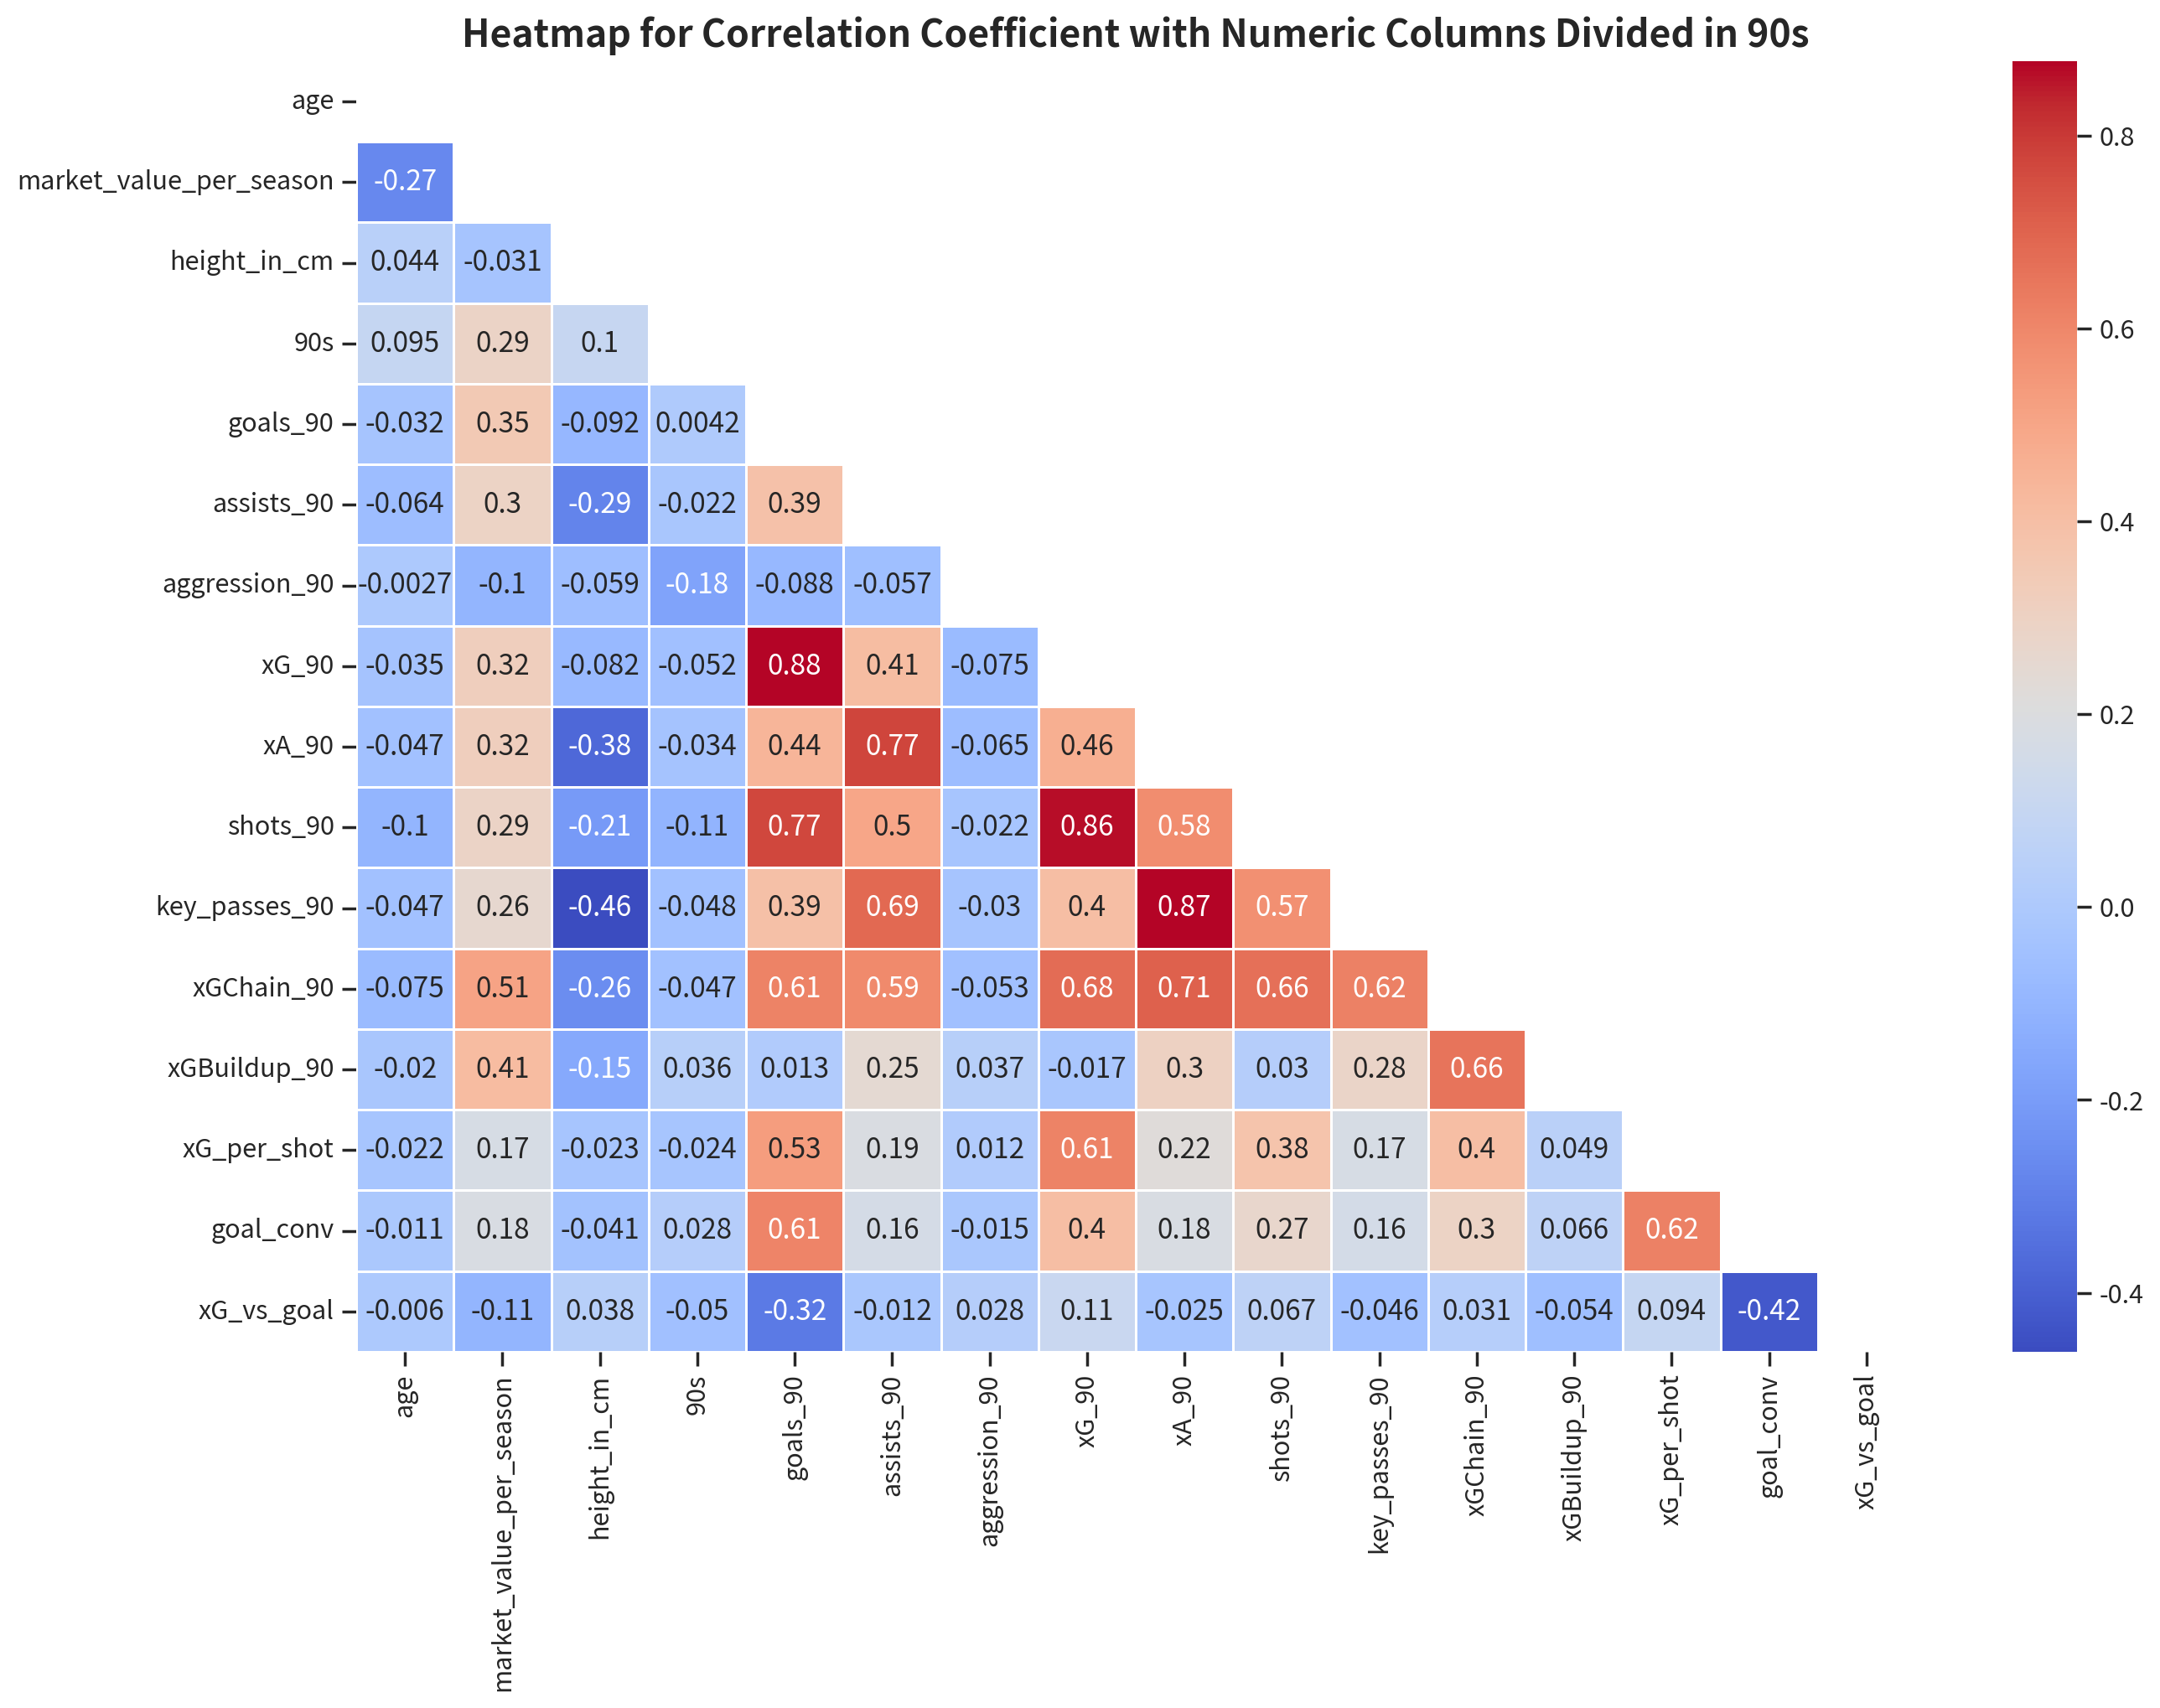

In [43]:
plt.figure(figsize=(15,10))

# 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False)
mask = np.zeros_like(df_corr2, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df_corr2,
            annot=True,         # 실제 값을 표시한다
            mask=mask,          # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,      # 경계면 실선으로 구분하기
            cmap='coolwarm')

plt.title("Heatmap for Correlation Coefficient with Numeric Columns Divided in 90s", fontsize=16, fontweight='bold')
plt.show()

In [44]:
# 변경한 데이터프레임 (df_copy) 다중공선성 확인
feature_engineering_XbyVIF(df_copy[["age", "market_value_per_season", "height_in_cm",
                    "90s", "goals_90", "assists_90", "aggression_90", "xG_90", 
                    "xA_90", "shots_90", "key_passes_90", "xGChain_90", "xGBuildup_90",
                    "xG_per_shot", "goal_conv",	"xG_vs_goal"]])

VIF_Factor                  Feature
0     1.203979                      age
1     1.867142  market_value_per_season
2     1.347309             height_in_cm
3     1.273492                      90s
4    22.352628                 goals_90
5     2.536482               assists_90
6     1.079894            aggression_90
7    34.574996                    xG_90
8     7.974137                    xA_90
9     6.324856                 shots_90
10    5.175980            key_passes_90
11   23.600883               xGChain_90
12    9.621651             xGBuildup_90
13    3.135389              xG_per_shot
14    3.068685                goal_conv
15    4.443157               xG_vs_goal

### 6-2. 상관관계, 다중 공선성 결과

- 매우 강한 상관관계 (0.8 이상)
    - `xG_90` - `goals_90`
    - `xA_90` - `key_passes_90`
    - `xG_90` - `shots_90`
- 강한 상관 관계 (0.6 ~ 0.8)
    - `goals_90` - `shots_90`
    - `assists_90` - `xA_90`
    - `assists_90` - `key_passes_90`
    - `xA_90` - `xGChain_90`
    - `xG_90` - `xGChain_90`
    - `shots_90` - `xGChain_90`
    - `xGBuildup_90` - `xGChain_90`
    - `goal_conv` - `xG_per_shot`
- 음의 상관관계 (-0.2 ~)
    - `height_in_cm` - `key_passes_90`
    - `height_in_cm` - `xA_90`
    - `goal_conv` - `xG_per_shot`
    - `goals_90` - `xG_vs_goal`

- 추후 머신러닝 모델링에 따라 컬럼 추가 제거 예정

- 다중 공선성 변화
    - `xG` - `xG_90` : 20 → 34
    - `goals` - `goals_90` : 8 → 22
    - `xA` - `xA_90` : 12 → 8
    - `xGChain` - `xGChain_90` : 36 → 22
    - `xGBuildup` - `xGBuildup_90` : 14 → 9
- `goals`를 활용한 파생변수를 다수 생성해서 증가한 것으로 보임

## 7. 가설 검정

### 7-1. 가설 1) 포지션별 평균 몸값은 동일할 것이다

In [45]:
# 포지션별 평균 몸값 구해본다
value_for_pos = df_copy.groupby(["position"])["market_value_per_season"].mean().to_frame().sort_values(by="market_value_per_season", ascending=False).reset_index()
value_for_pos

position  market_value_per_season
0       Second Striker             2.283556e+07
1          Left Winger             1.964591e+07
2   Attacking Midfield             1.906176e+07
3         Right Winger             1.773068e+07
4       Centre-Forward             1.505150e+07
5     Central Midfield             1.404247e+07
6   Defensive Midfield             1.284418e+07
7          Centre-Back             1.194572e+07
8            Left-Back             1.078206e+07
9           Right-Back             9.494374e+06
10          Goalkeeper             9.079274e+06
11       Left Midfield             8.163971e+06
12      Right Midfield             7.457407e+06

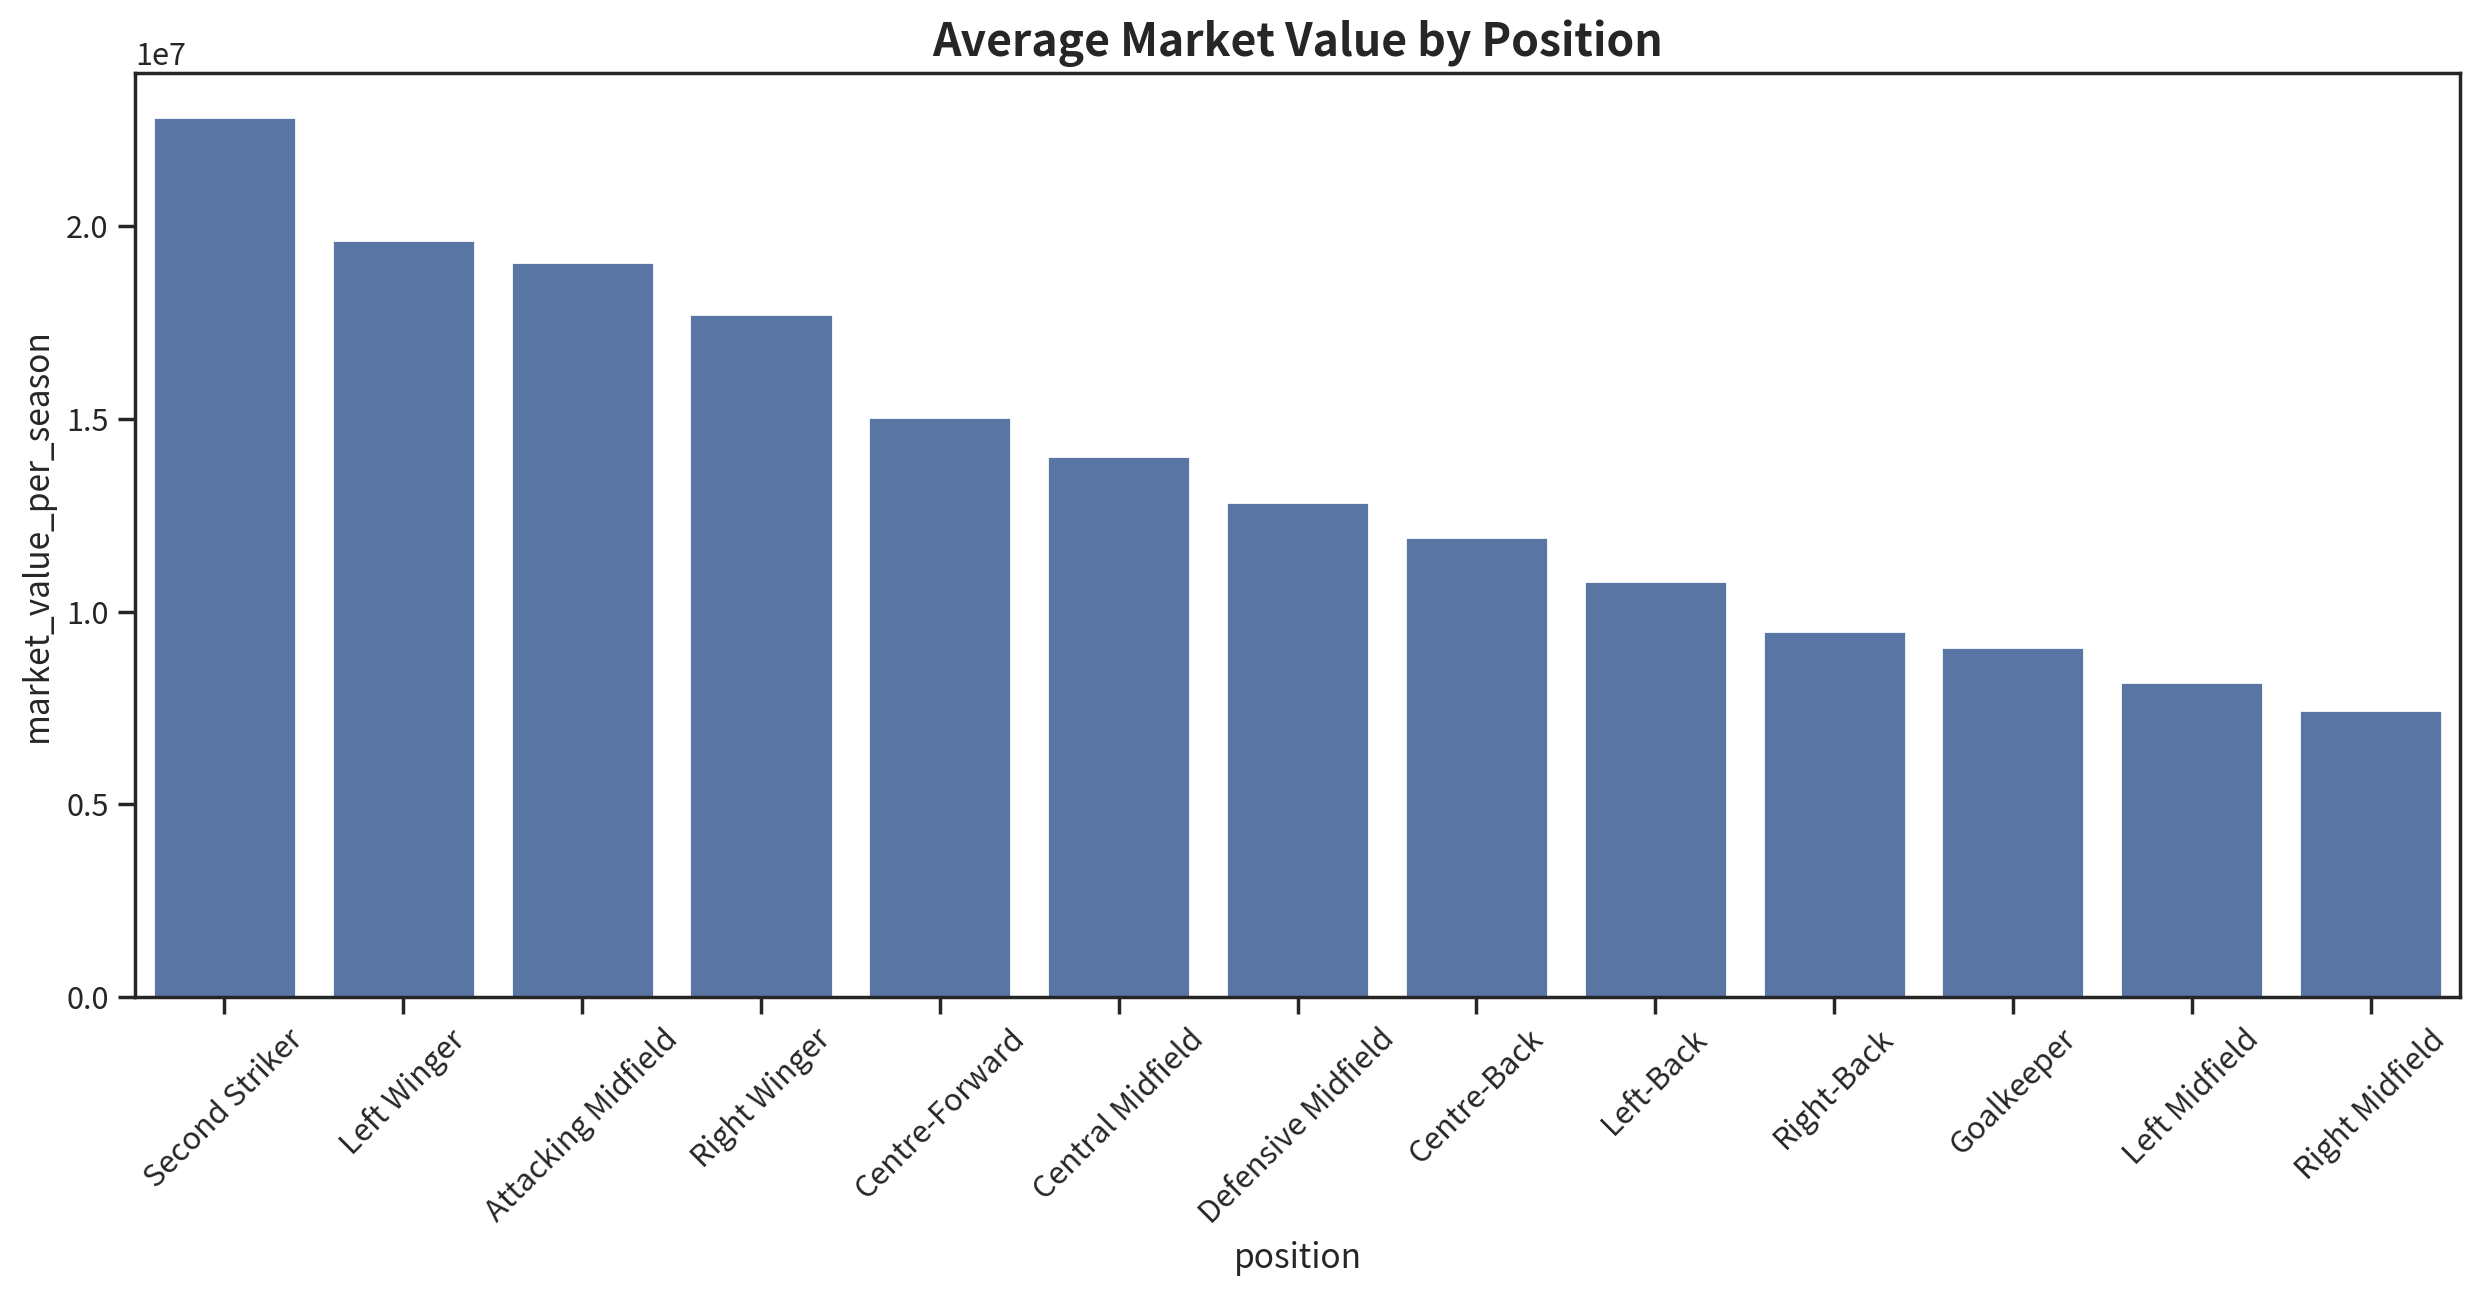

In [46]:
# fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
plt.figure(figsize=(15, 6))
sns.barplot(data=value_for_pos, x="position", y="market_value_per_season")
plt.xticks(rotation=45)  # x축의 글씨를 45도 기울임
plt.title("Average Market Value by Position", fontsize=16, fontweight="bold")
plt.show()

## 7. `column`별 분석

### 7-1. 나이에 따른 `goals`, `assists` 분석

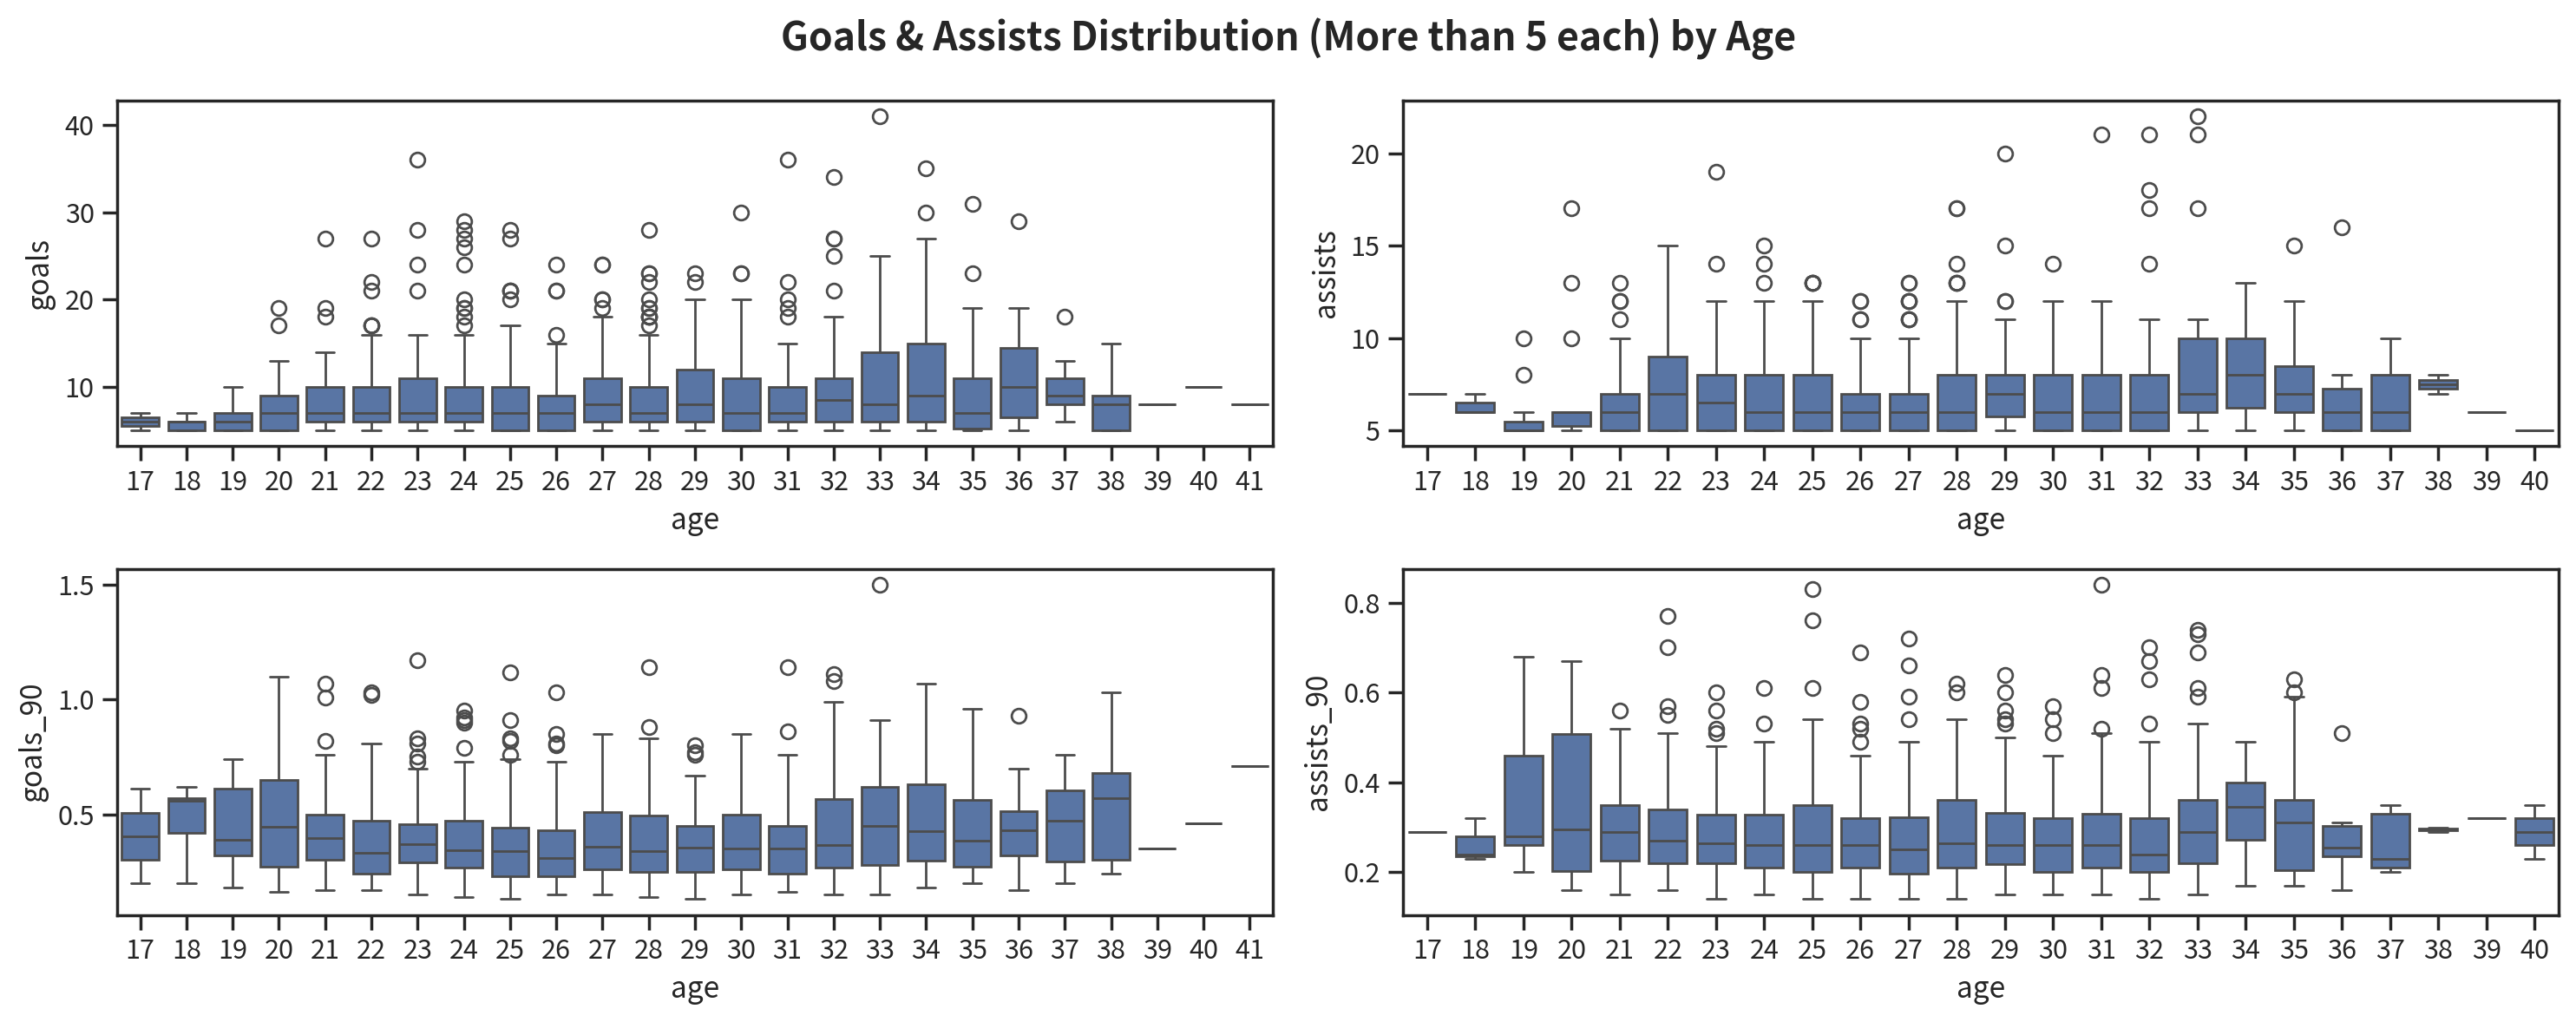

In [47]:
# boxplot 그려서 나이에 따른 골, 어시스트 확인
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 6))

# plt.figure(figsize=(15,8))
g1 = sns.boxplot(data=df_copy[df_copy["goals"]>=5], x="age", y="goals", ax=axes[0,0])
g2 = sns.boxplot(data=df_copy[df_copy["assists"]>=5], x="age", y="assists", ax=axes[0,1])

g3 = sns.boxplot(data=df_copy[df_copy["goals"]>=5], x="age", y="goals_90", ax=axes[1, 0])
g4 = sns.boxplot(data=df_copy[df_copy["assists"]>=5], x="age", y="assists_90", ax=axes[1, 1])

plt.suptitle("Goals & Assists Distribution (More than 5 each) by Age", fontsize=16, fontweight="bold")

fig.tight_layout()
plt.show()

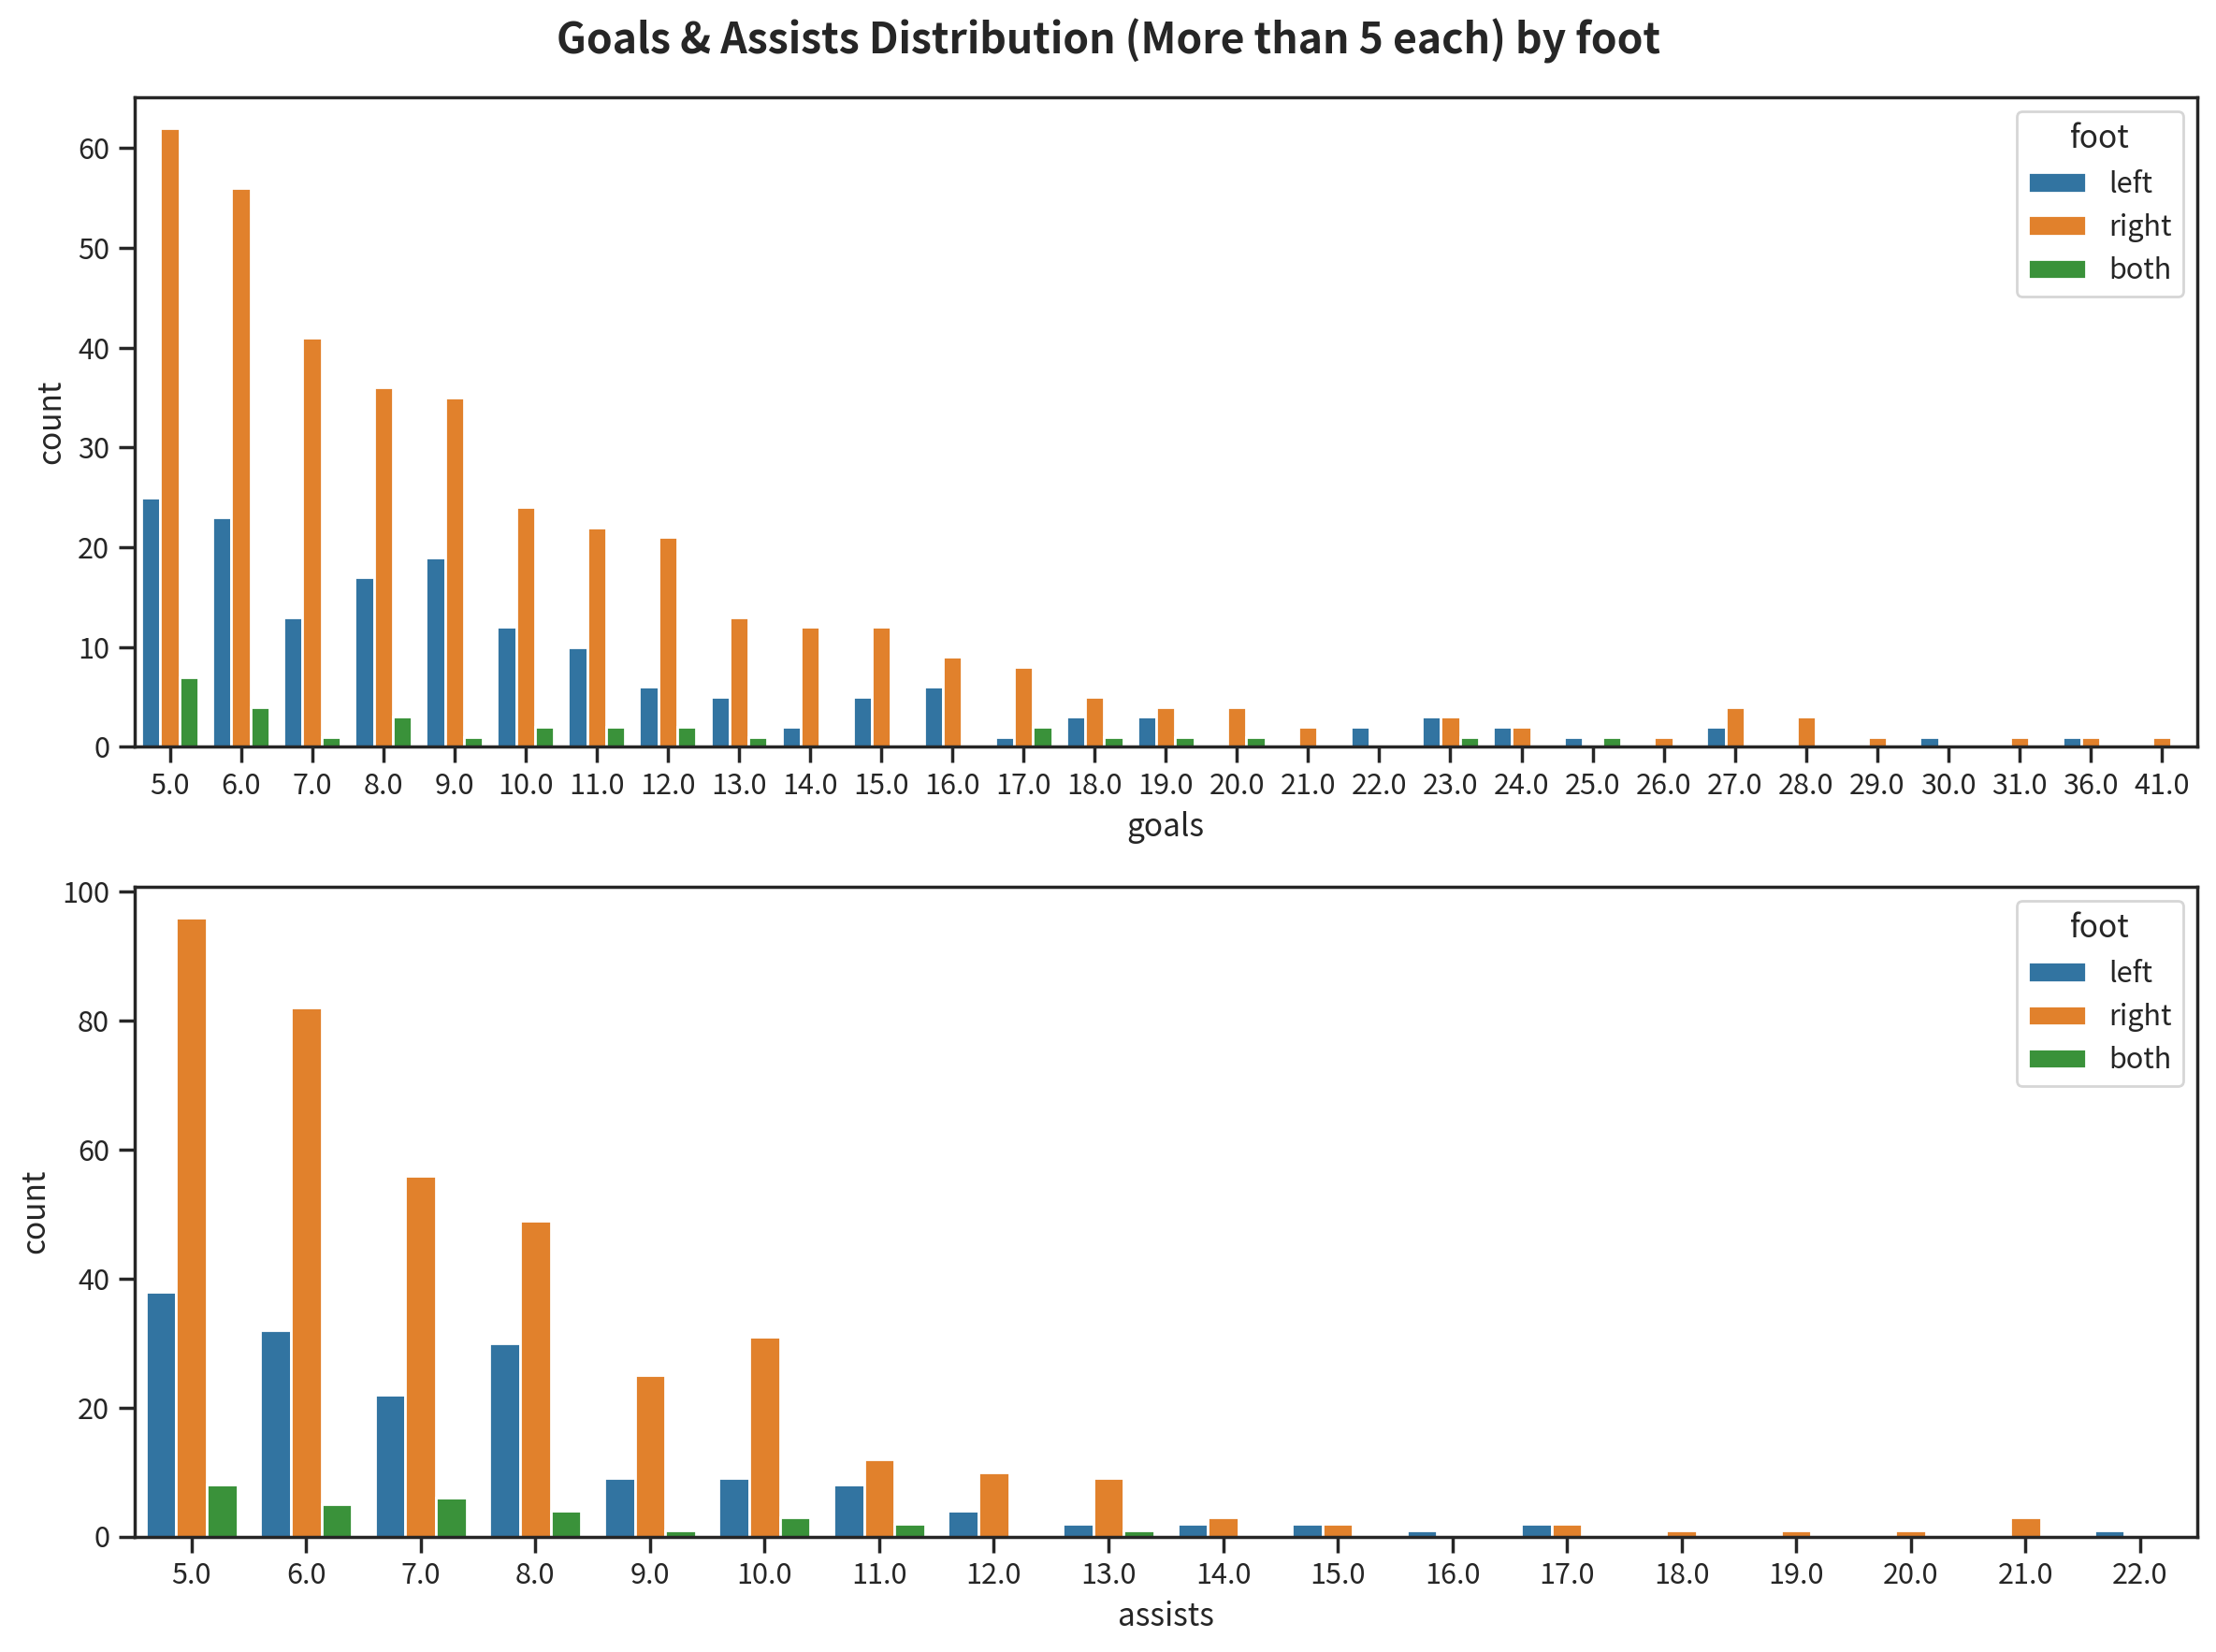

In [48]:
# countplot 그려서 골, 어시스트 숫자 확인
# 골, 어시스트 0인 선수 제외

goals_assists = ["goals", "assists"]
more_than_zero = (df_copy.goals >= 5) & (df_copy.assists >= 5)

# 'foot' 카테고리 값에 맞는 고정 색상 설정
hue_order = ['left', 'right', 'both']
fixed_palette = dict(zip(hue_order, sns.color_palette("tab10", len(hue_order))))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 9))

for col, ax in zip(goals_assists, axes):
    sns.countplot(data=df_copy[more_than_zero], x=col, ax=ax, hue="foot", palette=fixed_palette, hue_order=hue_order)

plt.suptitle("Goals & Assists Distribution (More than 5 each) by foot", fontsize=16, fontweight="bold")

fig.tight_layout()
plt.show()


In [49]:
# 41 득점한 선수 확인
df_copy[df_copy.goals==np.max(df_copy.goals)]

player_name start_season  yellow_cards  red_cards  goals  assists  \
828  Robert Lewandowski         2020           4.0        0.0   41.0      7.0   

     minutes_played competition_code date_of_birth        position  \
828          2463.0       bundesliga    1988-08-21  Centre-Forward   

    current_club_name  market_value_per_season country   foot  height_in_cm  \
828      FC Barcelona               60000000.0  Poland  right         185.0   

            xG       xA  shots  key_passes    xGChain  xGBuildup  age  \
828  32.077339  4.81555  135.0        32.0  31.740188   5.689343   33   

     aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
828         1.2  27.4       1.5        0.26           0.04   1.17   0.18   

     shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  \
828      4.93           1.17        1.16          0.21         0.24   

     goal_conv  xG_vs_goal  
828        0.3   -8.922661

In [50]:
# 90분당 득점 가장 높은 선수 확인
df_copy[df_copy.goals_90==np.max(df_copy["goals_90"])]

player_name start_season  yellow_cards  red_cards  goals  assists  \
828  Robert Lewandowski         2020           4.0        0.0   41.0      7.0   

     minutes_played competition_code date_of_birth        position  \
828          2463.0       bundesliga    1988-08-21  Centre-Forward   

    current_club_name  market_value_per_season country   foot  height_in_cm  \
828      FC Barcelona               60000000.0  Poland  right         185.0   

            xG       xA  shots  key_passes    xGChain  xGBuildup  age  \
828  32.077339  4.81555  135.0        32.0  31.740188   5.689343   33   

     aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
828         1.2  27.4       1.5        0.26           0.04   1.17   0.18   

     shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  \
828      4.93           1.17        1.16          0.21         0.24   

     goal_conv  xG_vs_goal  
828        0.3   -8.922661

In [51]:
# 22 어시스트한 선수 확인
df_copy[df_copy.assists==np.max(df_copy.assists)]

player_name start_season  yellow_cards  red_cards  goals  assists  \
7075  Lionel Messi         2019           4.0        0.0   25.0     22.0   

      minutes_played competition_code date_of_birth      position  \
7075          2880.0           laliga    1987-06-24  Right Winger   

        current_club_name  market_value_per_season    country  foot  \
7075  Paris Saint-Germain              112000000.0  Argentina  left   

      height_in_cm         xG         xA  shots  key_passes    xGChain  \
7075         170.0  20.849659  16.593372  159.0        88.0  34.923478   

      xGBuildup  age  aggression   90s  goals_90  assists_90  aggression_90  \
7075  13.537662   33         1.2  32.0      0.78        0.69           0.04   

      xG_90  xA_90  shots_90  key_passes_90  xGChain_90  xGBuildup_90  \
7075   0.65   0.52      4.97           2.75        1.09          0.42   

      xG_per_shot  goal_conv  xG_vs_goal  
7075         0.13       0.16   -4.150341

In [52]:
# 90분당 어시스트 가장 높은 선수 확인
df_copy[df_copy.assists_90==np.max(df_copy.assists_90)]

player_name start_season  yellow_cards  red_cards  goals  assists  \
416  Thomas Müller         2019           5.0        0.0    8.0     21.0   

     minutes_played competition_code date_of_birth        position  \
416          2261.0       bundesliga    1989-09-13  Second Striker   

    current_club_name  market_value_per_season  country   foot  height_in_cm  \
416     Bayern Munich               30000000.0  Germany  right         185.0   

           xG        xA  shots  key_passes    xGChain  xGBuildup  age  \
416  8.575405  15.50624   53.0        83.0  36.356539  18.292041   31   

     aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
416         1.5  25.1      0.32        0.84           0.06   0.34   0.62   

     shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  \
416      2.11           3.31        1.45          0.73         0.16   

     goal_conv  xG_vs_goal  
416       0.15    0.575405

In [ ]:
# 키 패스 가장 많이 한 선수
df_copy[df_copy.key_passes==np.max(df_copy.key_passes)]

player_name start_season  yellow_cards  red_cards  goals  assists  \
4648  Kevin De Bruyne         2019           3.0        0.0   13.0     20.0   

      minutes_played competition_code date_of_birth            position  \
4648          2800.0   premier-league    1991-06-28  Attacking Midfield   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
4648   Manchester City              120000000.0  Belgium  right         181.0   

            xG         xA  shots  key_passes    xGChain  xGBuildup  age  \
4648  8.106427  20.620713  100.0       133.0  37.798304  19.244827   29   

      aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
4648         0.9  31.1      0.42        0.64           0.03   0.26   0.66   

      shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  \
4648      3.22           4.28        1.22          0.62         0.08   

      goal_conv  xG_vs_goal  
4648       0.13   -4.893573

In [54]:
# 90분당 키 패스 가장 많이 한 선수
df_copy[df_copy.key_passes_90==np.max(df_copy.key_passes_90)]

player_name start_season  yellow_cards  red_cards  goals  assists  \
4648  Kevin De Bruyne         2019           3.0        0.0   13.0     20.0   

      minutes_played competition_code date_of_birth            position  \
4648          2800.0   premier-league    1991-06-28  Attacking Midfield   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
4648   Manchester City              120000000.0  Belgium  right         181.0   

            xG         xA  shots  key_passes    xGChain  xGBuildup  age  \
4648  8.106427  20.620713  100.0       133.0  37.798304  19.244827   29   

      aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
4648         0.9  31.1      0.42        0.64           0.03   0.26   0.66   

      shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  \
4648      3.22           4.28        1.22          0.62         0.08   

      goal_conv  xG_vs_goal  
4648       0.13   -4.893573

### 7-2. 시즌별 Goals, Assists Top 5 확인

In [55]:
# func1 : 골 Top 5로 정렬
func1 = lambda x: x.sort_values(by="goals", ascending=False)[:5]

# func2 : 어시스트 Top 5로 정렬 
func2 = lambda x: x.sort_values(by="assists", ascending=False)[:5]

In [56]:
# 골 Top 5로 정렬
goal_top5 = df_copy.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_top5.head()

player_name  goals  assists
start_season                                         
2019         369   Robert Lewandowski   34.0      4.0
             2318   Cristiano Ronaldo   31.0      6.0
             422          Timo Werner   28.0      8.0
             7075        Lionel Messi   25.0     22.0
             4594         Jamie Vardy   23.0      5.0

In [57]:
# 어시스트 Top 5로 정렬 
assist_top5 = df_copy.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_top5.head()

player_name  goals  assists
start_season                                         
2019         7075        Lionel Messi   25.0     22.0
             416        Thomas Müller    8.0     21.0
             4648     Kevin De Bruyne   13.0     20.0
             147         Jadon Sancho   17.0     17.0
             63    Christopher Nkunku    5.0     15.0

In [58]:
# goal_top5와 assist_top5를 합쳐 시즌별 골, 어시스트 top 5를 넣은 데이터프레임 생성
goals_assists_top5 = pd.concat([goal_top5, assist_top5]).reset_index()
goals_assists_top5.drop_duplicates(inplace=True)
goals_assists_top5

start_season  level_1          player_name  goals  assists
0          2019      369   Robert Lewandowski   34.0      4.0
1          2019     2318    Cristiano Ronaldo   31.0      6.0
2          2019      422          Timo Werner   28.0      8.0
3          2019     7075         Lionel Messi   25.0     22.0
4          2019     4594          Jamie Vardy   23.0      5.0
5          2020      828   Robert Lewandowski   41.0      7.0
6          2020     7504         Lionel Messi   30.0     11.0
7          2020     2578    Cristiano Ronaldo   29.0      2.0
8          2020      479          André Silva   28.0      8.0
9          2020      558       Erling Haaland   27.0      8.0
10         2021     1274   Robert Lewandowski   35.0      4.0
11         2021    10303        Kylian Mbappé   28.0     19.0
12         2021     7921        Karim Benzema   27.0     12.0
13         2021     2941        Ciro Immobile   27.0      3.0
14         2021    10493    Wissam Ben Yedder   25.0      5.0
15         2022     5972       Erling Haaland   36.0      8.0
16         2022     6001           Harry Kane   30.0      3.0
17         2022    10785        Kylian Mbappé   29.0      6.0
18         2022    10537  Alexandre Lacazette   27.0      5.0
19         2022     3832       Victor Osimhen   26.0      5.0
20         2023     1974           Harry Kane   36.0      8.0
21         2023     2221      Serhou Guirassy   28.0      2.0
22         2023     6490       Erling Haaland   27.0      5.0
23         2023    11256        Kylian Mbappé   27.0      7.0
24         2023     4106     Lautaro Martínez   24.0      6.0
26         2019      416        Thomas Müller    8.0     21.0
27         2019     4648      Kevin De Bruyne   13.0     20.0
28         2019      147         Jadon Sancho   17.0     17.0
29         2019       63   Christopher Nkunku    5.0     15.0
30         2020      876        Thomas Müller   11.0     21.0
31         2020      570         Filip Kostić    4.0     17.0
32         2020     5025           Harry Kane   23.0     14.0
33         2020     7416           Iago Aspas   14.0     13.0
34         2020      517        Daichi Kamada    5.0     13.0
35         2021     1322        Thomas Müller    8.0     21.0
37         2021     2980     Domenico Berardi   15.0     17.0
38         2021     1176           Marco Reus    9.0     17.0
39         2021    10311         Lionel Messi    6.0     15.0
40         2022     6097      Kevin De Bruyne    7.0     18.0
41         2022     8170    Antoine Griezmann   15.0     17.0
42         2022    10794         Lionel Messi   16.0     16.0
43         2022     1727    Randal Kolo Muani   15.0     14.0
44         2022     1513        Jamal Musiala   12.0     13.0
45         2023     1828   Alejandro Grimaldo   10.0     15.0
46         2023     8958        Nico Williams    5.0     14.0
47         2023     9078           Álex Baena    2.0     14.0
48         2023     4155        Marcus Thuram   13.0     13.0
49         2023     6724        Ollie Watkins   19.0     13.0

#### 7-2-1. 시각화 (`plotly`)

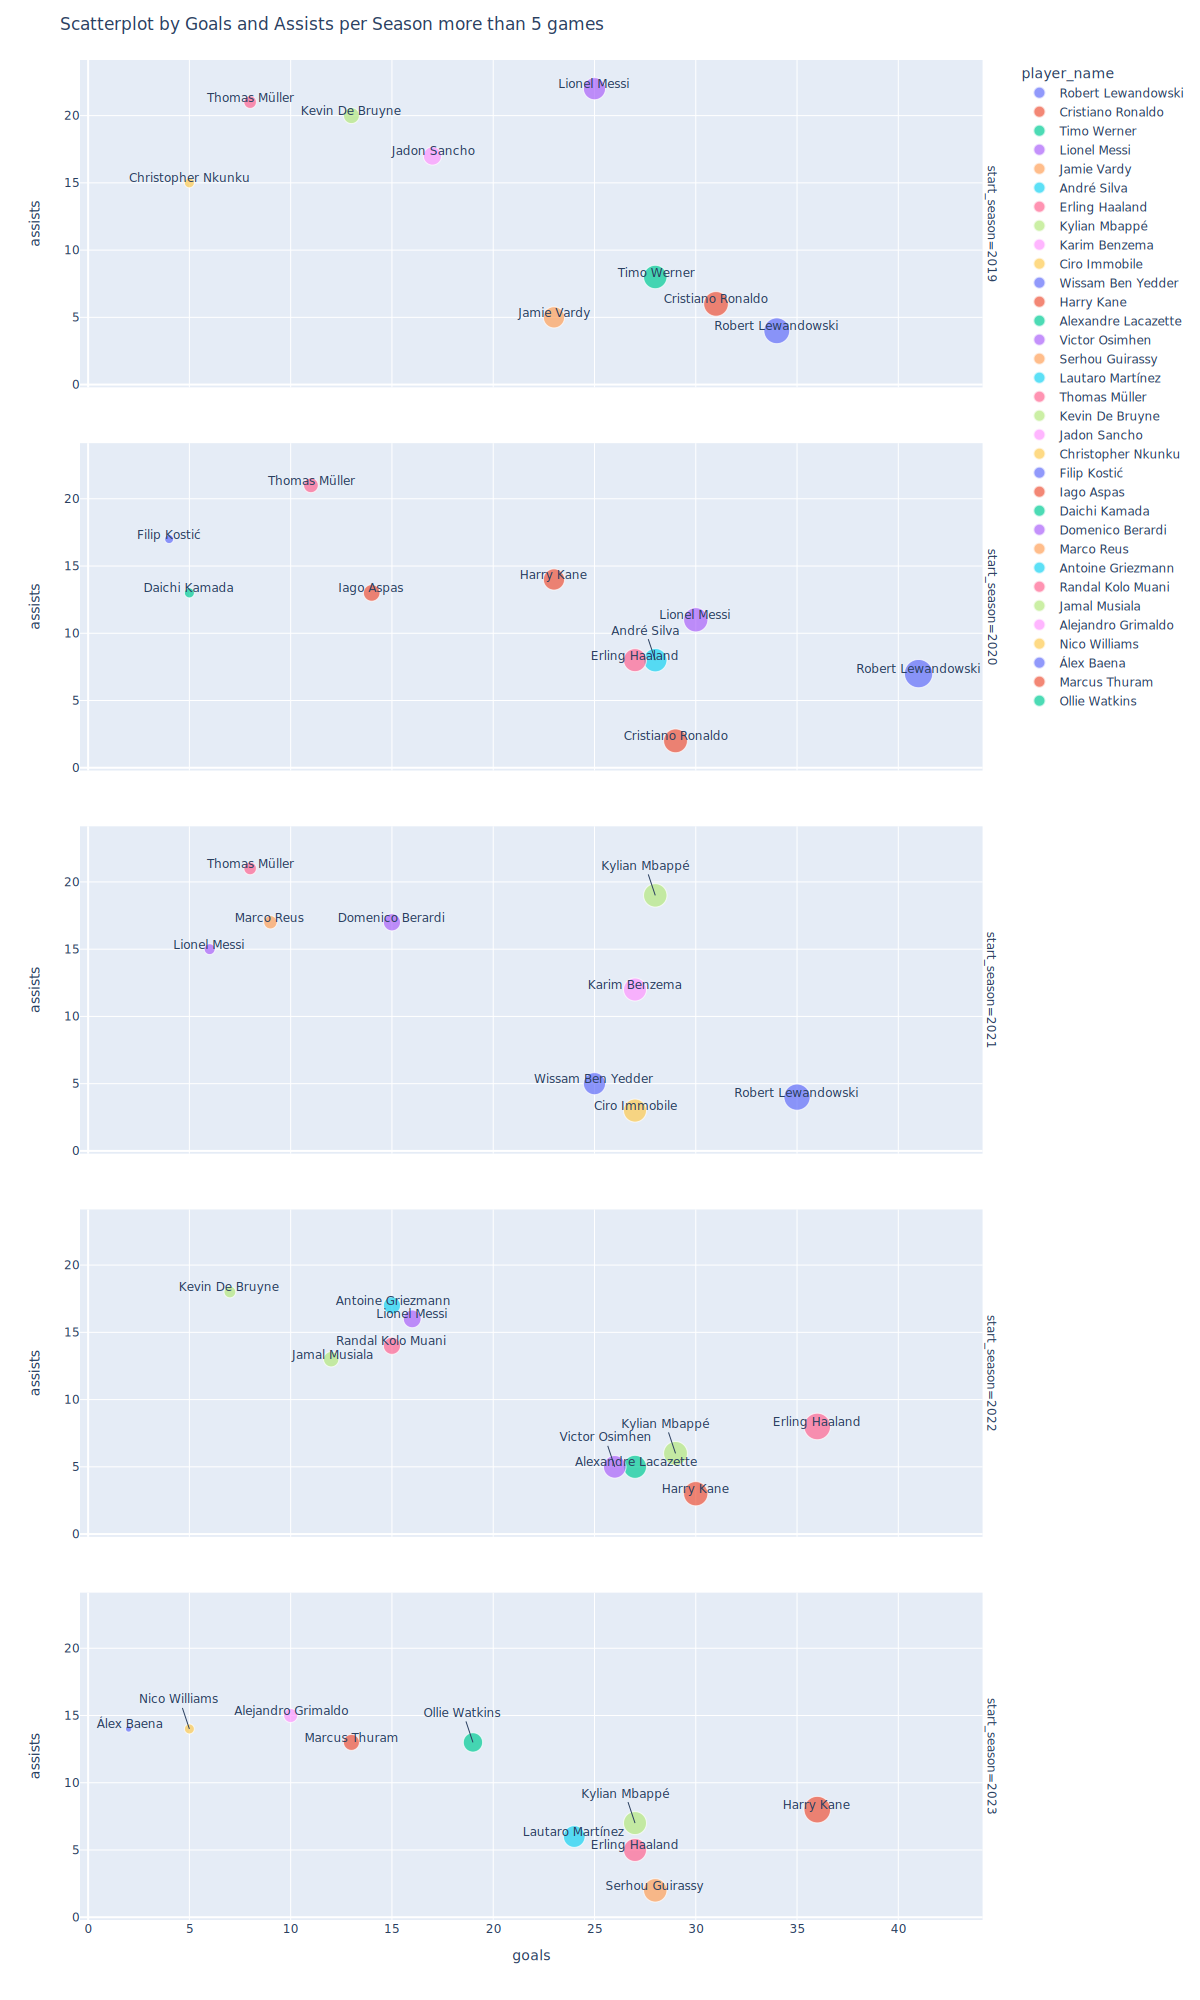

In [59]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_top5, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season", 
                 width=1200, height=2000)

overlapped_names = ["André Silva", "Rafa", "Victor Osimhen", "Ollie Watkins", "Nico Williams",
                    "Leroy Sané", "Jan-Niklas Beste", "Viktor Gyökeres", "Kylian Mbappé"]

for i, season in enumerate(goals_assists_top5["start_season"].unique()):
    seasonal = goals_assists_top5[goals_assists_top5["start_season"] == season].reset_index(drop=True)
    
    i = (-1)*(i-5)

    for j in range(seasonal.shape[0]):
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            else:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 5 games")

fig.show()

#### 7-2-2. 10경기 이상 뛴 선수들로 시즌별 Goals, Assists Top 5 확인

In [60]:
# 10경기라 900분 이상으로 필터링
df_over_10_games = df_copy[df_copy.minutes_played>=900]
df_over_10_games.head()

player_name start_season  yellow_cards  red_cards  goals  assists  \
0       Aarón Martín         2019           2.0        0.0    0.0      0.0   
1  Abdelhamid Sabiri         2019           6.0        0.0    4.0      1.0   
2      Achraf Hakimi         2019           5.0        0.0    5.0     10.0   
3        Adam Bodzek         2019          10.0        0.0    0.0      0.0   
5      Admir Mehmedi         2019           0.0        0.0    2.0      2.0   

   minutes_played competition_code date_of_birth            position  \
0          1795.0       bundesliga    1997-04-22           Left-Back   
1          1035.0       bundesliga    1996-11-28  Attacking Midfield   
2          2717.0       bundesliga    1998-11-04          Right-Back   
3          2018.0       bundesliga    1985-09-07  Defensive Midfield   
5          1205.0       bundesliga    1991-03-16      Second Striker   

     current_club_name  market_value_per_season      country   foot  \
0            Genoa CFC               10500000.0        Spain   left   
1       ACF Fiorentina                1700000.0      Morocco  right   
2  Paris Saint-Germain               54000000.0      Morocco  right   
3   Fortuna Düsseldorf                 325000.0       Poland  right   
5          Antalyaspor                8000000.0  Switzerland  right   

   height_in_cm        xG        xA  shots  key_passes    xGChain  xGBuildup  \
0         178.0  0.294448  3.250888    9.0        32.0   3.658402   2.195273   
1         186.0  3.468877  0.232751   43.0         7.0   1.644770   0.885899   
2         181.0  5.067438  5.510969   38.0        36.0  24.144373  16.293885   
3         184.0  0.697913  0.270701    9.0         8.0   2.535295   1.791962   
5         183.0  1.536662  2.166826   22.0        19.0   6.112824   3.069346   

   age  aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
0   23         0.6  19.9      0.00        0.00           0.03   0.01   0.16   
1   23         1.8  11.5      0.35        0.09           0.16   0.30   0.02   
2   21         1.5  30.2      0.17        0.33           0.05   0.17   0.18   
3   35         3.0  22.4      0.00        0.00           0.13   0.03   0.01   
5   29         0.0  13.4      0.15        0.15           0.00   0.11   0.16   

   shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  goal_conv  \
0      0.45           1.61        0.18          0.11         0.03       0.00   
1      3.74           0.61        0.14          0.08         0.08       0.09   
2      1.26           1.19        0.80          0.54         0.13       0.13   
3      0.40           0.36        0.11          0.08         0.08       0.00   
5      1.64           1.42        0.46          0.23         0.07       0.09   

   xG_vs_goal  
0    0.294448  
1   -0.531123  
2    0.067438  
3    0.697913  
5   -0.463338

In [61]:
df_over_10_games.shape

(6952, 36)

In [62]:
goal_10_games_top5= df_over_10_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func1)
goal_10_games_top5.head()

player_name  goals  assists
start_season                                         
2019         369   Robert Lewandowski   34.0      4.0
             2318   Cristiano Ronaldo   31.0      6.0
             422          Timo Werner   28.0      8.0
             7075        Lionel Messi   25.0     22.0
             4594         Jamie Vardy   23.0      5.0

In [63]:
assist_10_games_top5 = df_over_10_games.groupby("start_season")[["player_name", "goals", "assists"]].apply(func2)
assist_10_games_top5.head()

player_name  goals  assists
start_season                                         
2019         7075        Lionel Messi   25.0     22.0
             416        Thomas Müller    8.0     21.0
             4648     Kevin De Bruyne   13.0     20.0
             147         Jadon Sancho   17.0     17.0
             63    Christopher Nkunku    5.0     15.0

In [64]:
goals_assists_10_games_top5 = pd.concat([goal_10_games_top5, assist_10_games_top5]).reset_index()
goals_assists_10_games_top5.drop_duplicates(inplace=True)
goals_assists_10_games_top5.sort_values(by=["start_season", "assists"], ascending=[True, False], inplace=True)

In [65]:
# 10경기 이상 뛴 선수 중 시즌별 골, 어시스트 top 5를 넣은 데이터프레임 생성
goals_assists_10_games_top5.reset_index(drop=True, inplace=True)

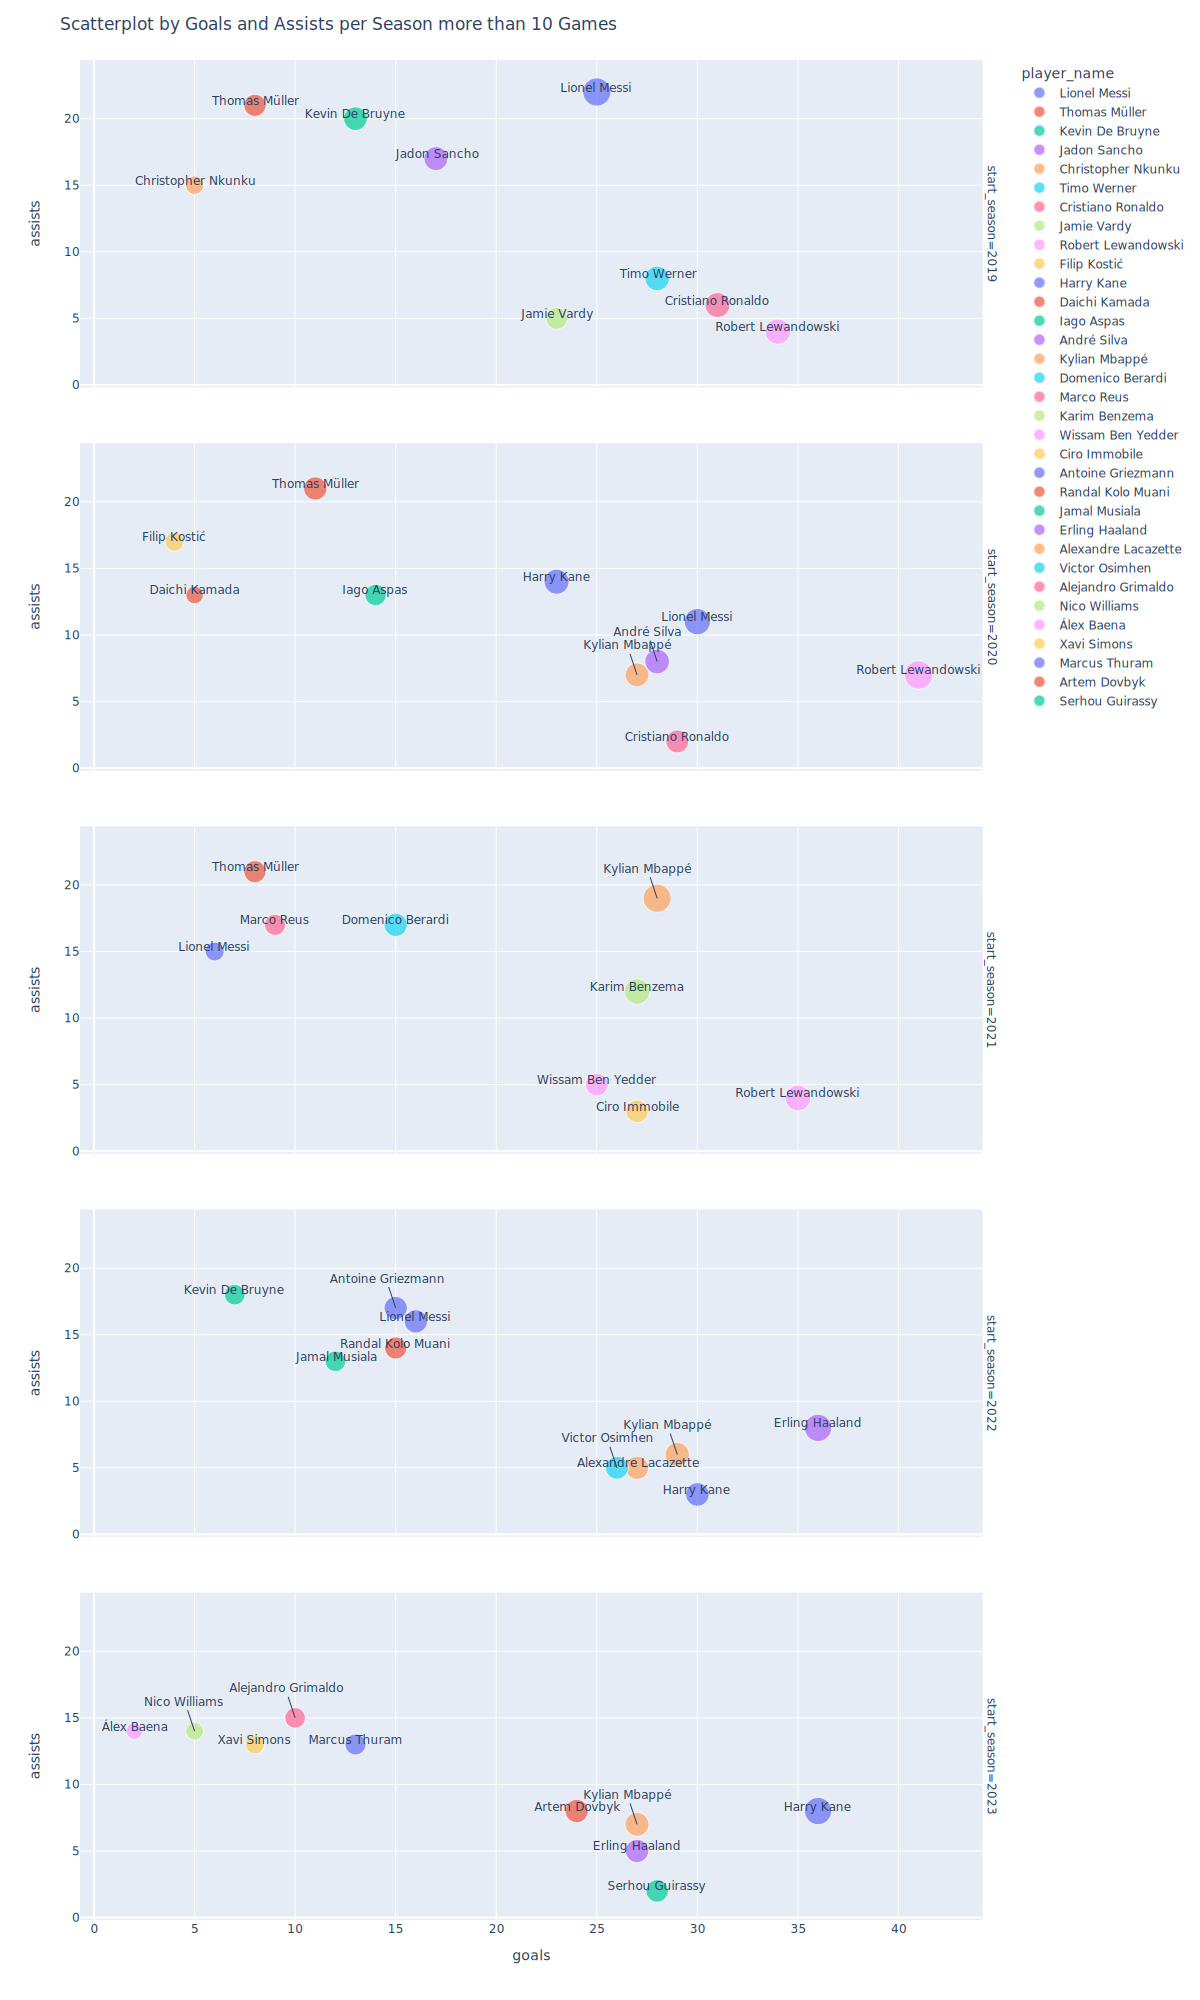

In [66]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=goals_assists_10_games_top5, x="goals", y="assists", color="player_name", 
                 size=goals_assists_10_games_top5["goals"]+goals_assists_10_games_top5["assists"], 
                 facet_row=goals_assists_10_games_top5["start_season"], 
                #  text=goals_assists_10_games_top5["player_name"],
                 width=1200, height=2000)


fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 10 Games")


overlapped_names = ["André Silva", "Rafa", "Victor Osimhen", "Alejandro Grimaldo", "Nico Williams",
                    "Leroy Sané", "Jan-Niklas Beste", "Viktor Gyökeres", "Kylian Mbappé", "Antoine Griezmann"]

for i, season in enumerate(goals_assists_10_games_top5["start_season"].unique()):
    seasonal = goals_assists_10_games_top5[goals_assists_10_games_top5["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-5)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            else:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.show()


### 7-3. `market_value_per_season` 분석

#### 7-3-1. 시즌별 나이에 따른 평균 선수 몸값 변화 

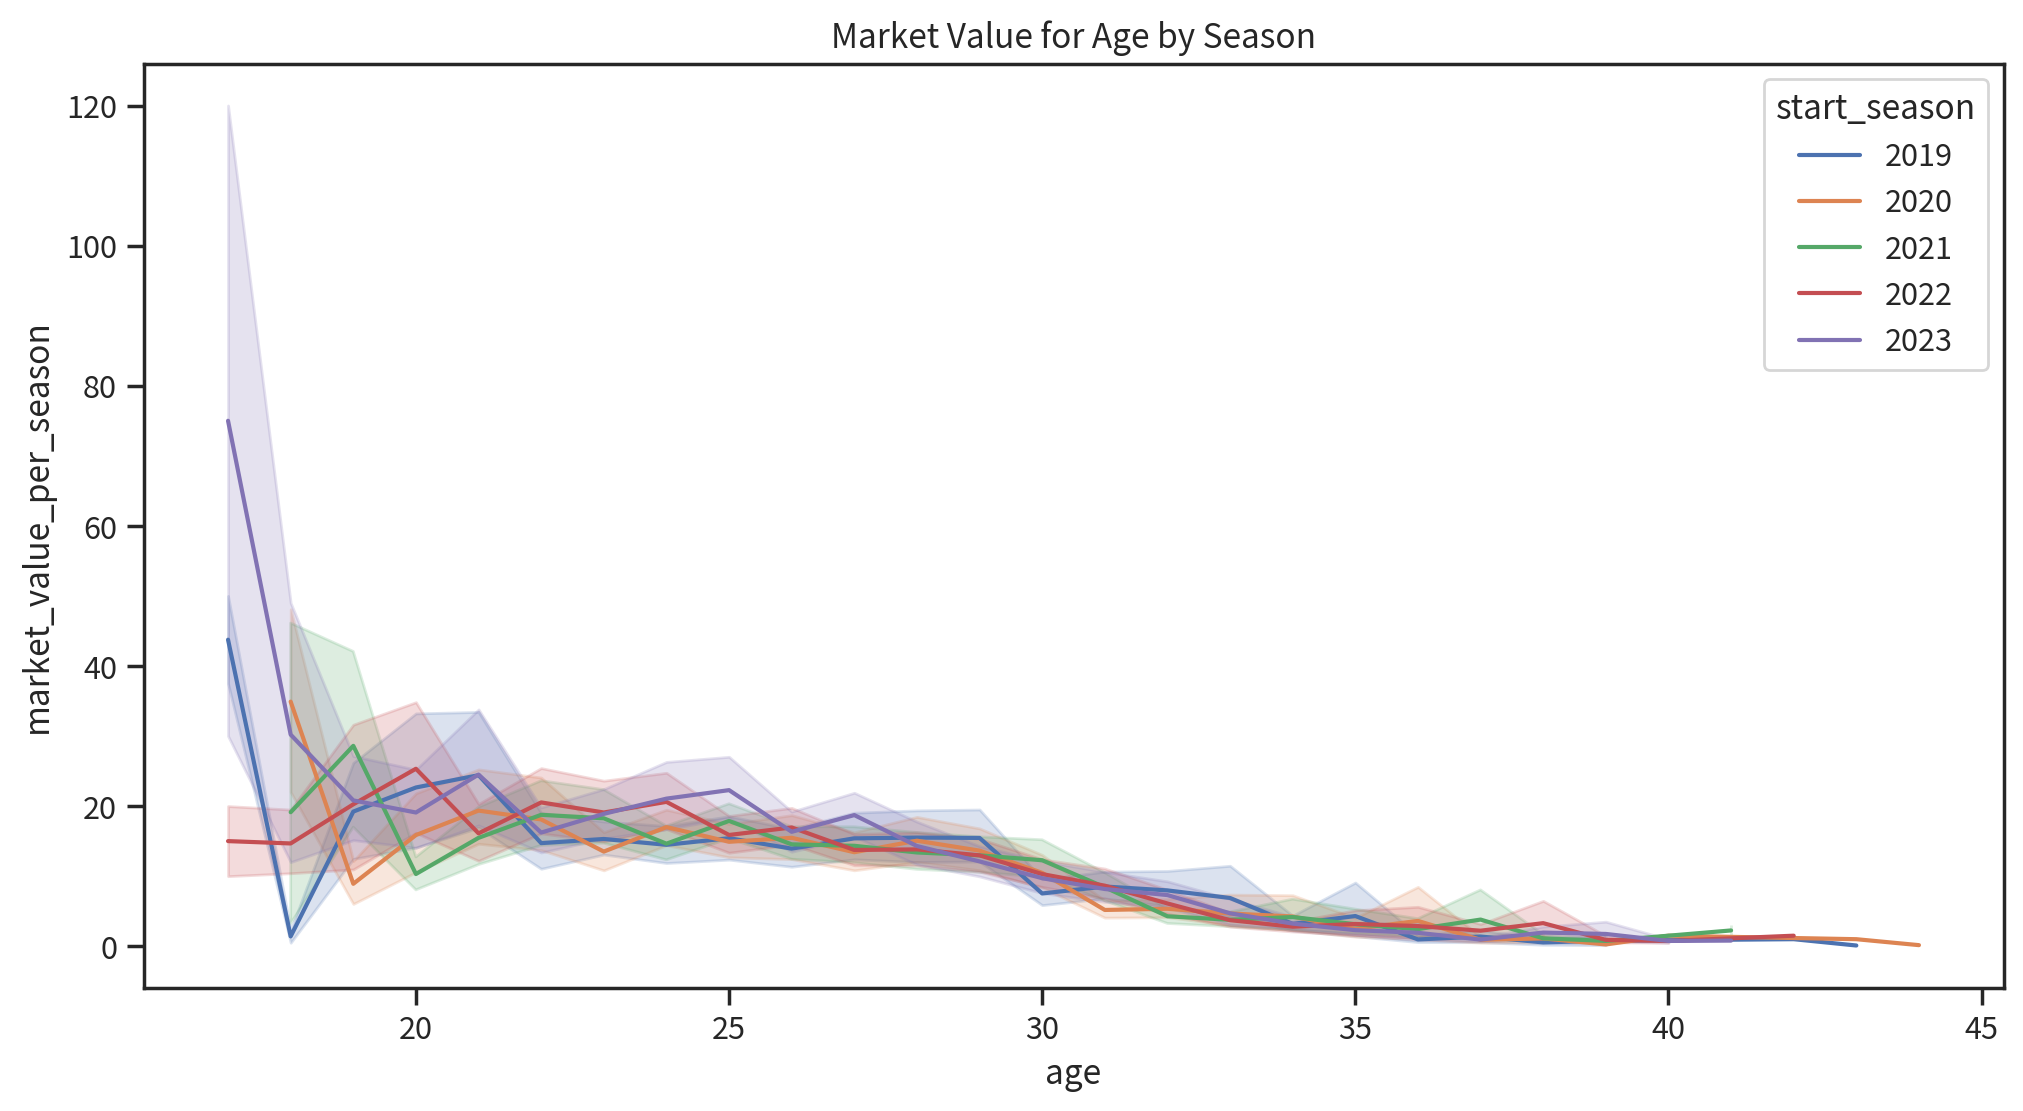

In [67]:
# 시즌, 연령에 따른 선수 몸값 변화

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_copy, x=df_copy["age"], y=df_copy["market_value_per_season"]/1000000, hue="start_season", estimator="mean")
plt.title("Market Value for Age by Season")
plt.show()

In [68]:
# 23-24 시즌 기준, 17세의 Market Value 그래프가 유독 높게 솟아 있다 (보라색 lineplot)
# 23-24 시즌 기준, 17세 이하 중 가장 높은 몸값 자랑하는 선수 확인 → Lamine Yamal (120M)

df_copy[(df_copy["age"]<=17) & (df_copy["start_season"]=="2023")].sort_values("market_value_per_season", ascending=False).head(10)

player_name start_season  yellow_cards  red_cards  goals  assists  \
8885  Lamine Yamal         2023           3.0        0.0    5.0      7.0   
8971   Pau Cubarsí         2023           4.0        0.0    0.0      0.0   

      minutes_played competition_code date_of_birth      position  \
8885          2196.0           laliga    2007-07-13  Right Winger   
8971          1562.0           laliga    2007-01-22   Centre-Back   

     current_club_name  market_value_per_season country   foot  height_in_cm  \
8885      FC Barcelona              120000000.0   Spain   left         180.0   
8971      FC Barcelona               30000000.0   Spain  right         184.0   

            xG        xA  shots  key_passes    xGChain  xGBuildup  age  \
8885  5.792876  6.701532   58.0        39.0  22.475352  12.034276   17   
8971  0.084843  0.503294    3.0         5.0   8.706845   8.553267   17   

      aggression   90s  goals_90  assists_90  aggression_90  xG_90  xA_90  \
8885         0.9  24.4       0.2        0.29           0.04   0.24   0.27   
8971         1.2  17.4       0.0        0.00           0.07   0.00   0.03   

      shots_90  key_passes_90  xGChain_90  xGBuildup_90  xG_per_shot  \
8885      2.38           1.60        0.92          0.49         0.10   
8971      0.17           0.29        0.50          0.49         0.03   

      goal_conv  xG_vs_goal  
8885       0.09    0.792876  
8971       0.00    0.084843

#### 7-3-2. 23-24 시즌 연령별 최고 몸값 선수

In [72]:
# pos_category 함수 수정: row를 파라미터로 받아서 처리
def pos_category(row, col):
    if row[col] in ["Second Striker", "Centre-Forward", "Left Winger", "Right Winger"]:
        return "Forward"
    elif row[col] in ["Attacking Midfield", "Central Midfield", "Defensive Midfield", "Left Midfield", "Right Midfield"]:
        return "Midfielder"
    elif row[col] in ["Goalkeeper"]:
        return "Goalkeeper"
    else:
        return "Defender"

# df_copy에 새 컬럼 추가: 'position_category'
# df_copy['position_category'] = df_copy.apply(lambda row: pos_category(row, "position"), axis=1)
df_copy['position_category'] = df_copy.apply(lambda row: pos_category(row, "position"), axis=1)

In [73]:
df_copy_23 = df_copy[df_copy["start_season"]=="2023"]

# 각 나이별로 market_value_per_season가 가장 높은 선수의 정보 추출
idx = df_copy_23.groupby("age")["market_value_per_season"].idxmax()

# 해당 인덱스를 기반으로 player_name과 market_value_per_season를 선택
df_max_value_per_age = df_copy_23.loc[idx, ["age", "position_category", "player_name", "market_value_per_season"]]
df_max_value_per_age

age position_category         player_name  market_value_per_season
8885    17           Forward        Lamine Yamal              120000000.0
11439   18        Midfielder  Warren Zaïre-Emery               60000000.0
6617    19        Midfielder       Kobbie Mainoo               55000000.0
8778    20        Midfielder                Gavi               90000000.0
8869    21        Midfielder     Jude Bellingham              180000000.0
6595    22          Defender      Josko Gvardiol               75000000.0
6411    23           Forward         Bukayo Saka              140000000.0
6490    24           Forward      Erling Haaland              180000000.0
11256   25           Forward       Kylian Mbappé              180000000.0
8764    26        Midfielder   Federico Valverde              120000000.0
4106    27           Forward    Lautaro Martínez              110000000.0
6761    28        Midfielder               Rodri              130000000.0
6536    29           Forward       Jack Grealish               60000000.0
6398    30        Midfielder      Bernardo Silva               70000000.0
1974    31           Forward          Harry Kane              100000000.0
6691    32           Forward       Mohamed Salah               55000000.0
6613    33        Midfielder     Kevin De Bruyne               50000000.0
6622    34          Defender         Kyle Walker               13000000.0
2238    35           Forward       Thomas Müller                8000000.0
8993    36           Forward  Robert Lewandowski               15000000.0
8798    37           Forward          Iago Aspas                3000000.0
2080    38        Goalkeeper        Manuel Neuer                4000000.0
8899    39        Midfielder         Luka Modric                6000000.0
6800    40          Defender        Thiago Silva                1000000.0
8712    41        Goalkeeper       Claudio Bravo                 800000.0

In [74]:
df_copy_23 = df_copy[df_copy["start_season"]=="2023"]

# 각 나이별로 market_value_per_season가 가장 높은 선수의 정보 추출
idx = df_copy_23.groupby("position")["market_value_per_season"].idxmax()

# 해당 인덱스를 기반으로 player_name과 market_value_per_season를 선택
df_max_value_per_position = df_copy_23.loc[idx, ["position", "position_category", "player_name", "market_value_per_season"]]
df_max_value_per_position = df_max_value_per_position.sort_values(by="market_value_per_season", ascending=True)
df_max_value_per_position

position position_category             player_name  \
3917       Left Midfield        Midfielder          Carlos Augusto   
3952      Right Midfield        Midfielder         Denzel Dumfries   
3853      Second Striker           Forward         Ademola Lookman   
8782          Goalkeeper        Goalkeeper    Giorgi Mamardashvili   
6817          Right-Back          Defender  Trent Alexander-Arnold   
6595           Left-Back          Defender          Josko Gvardiol   
6771         Centre-Back          Defender              Rúben Dias   
8764    Central Midfield        Midfielder       Federico Valverde   
6761  Defensive Midfield        Midfielder                   Rodri   
6740        Right Winger           Forward              Phil Foden   
8869  Attacking Midfield        Midfielder         Jude Bellingham   
6490      Centre-Forward           Forward          Erling Haaland   
9059         Left Winger           Forward         Vinicius Junior   

      market_value_per_season  
3917               22000000.0  
3952               24000000.0  
3853               40000000.0  
8782               45000000.0  
6817               70000000.0  
6595               75000000.0  
6771               80000000.0  
8764              120000000.0  
6761              130000000.0  
6740              150000000.0  
8869              180000000.0  
6490              180000000.0  
9059              180000000.0

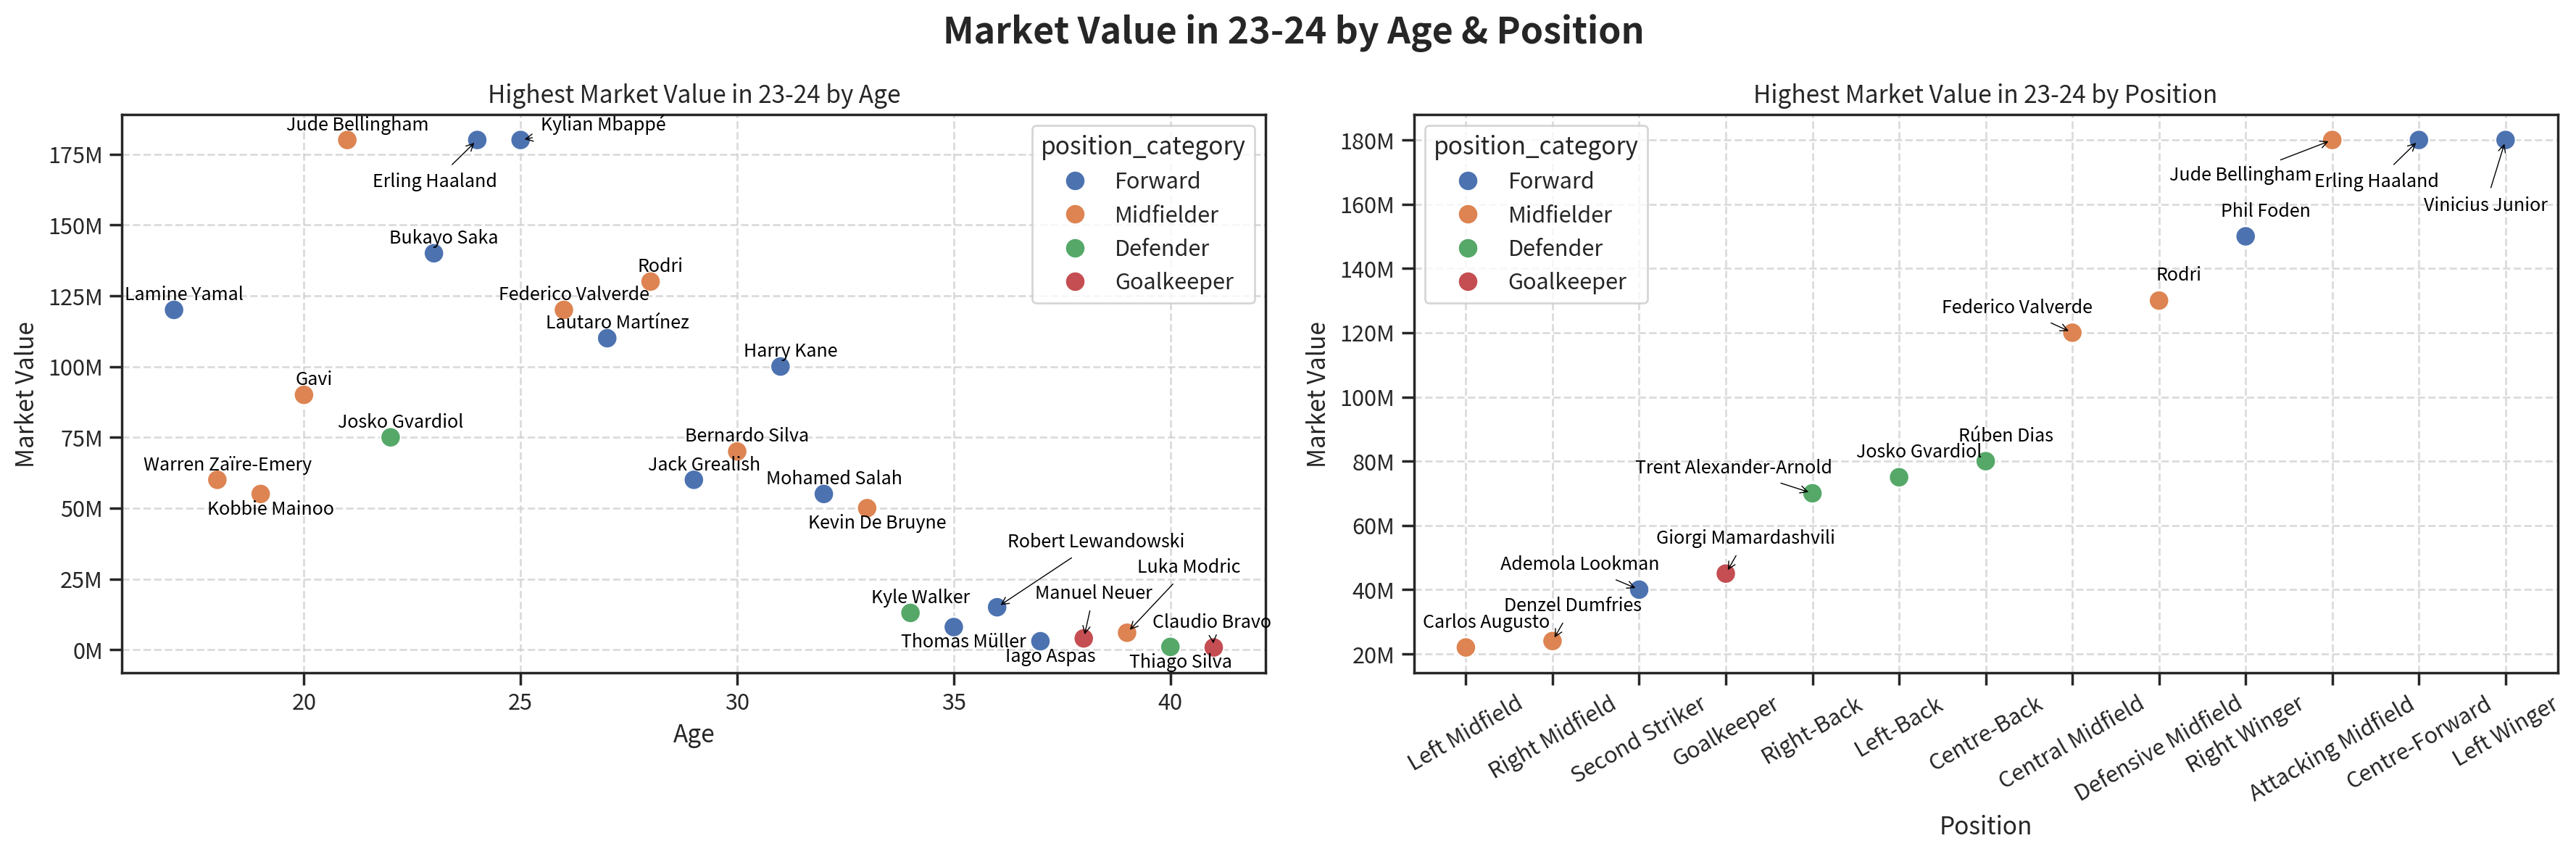

In [76]:
# Subplot 생성 (1*2)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# y축을 M 단위로 표시하기 위한 포맷터 함수
def millions(x, pos):
    '1,000,000 단위로 나누어 M을 추가'
    return '%1.0fM' % (x * 1e-6)

hue_order = ["Forward", "Midfielder", "Defender", "Goalkeeper"]

# 1번 subplot: age vs market_value_per_season
ax1 = axes[0]
sns.scatterplot(data=df_max_value_per_age, x="age", y="market_value_per_season", 
                hue="position_category", hue_order=hue_order,
                s=100, color='b', ax=ax1)

# 각 포인트에 player_name 추가 (annotate)
for i in range(df_max_value_per_age.shape[0]):
    player_name = df_max_value_per_age["player_name"].iloc[i]
    x = df_max_value_per_age["age"].iloc[i]
    y = df_max_value_per_age["market_value_per_season"].iloc[i]

    # 특정 선수의 경우에는 텍스트를 포인트 아래에 위치시킴
    if player_name in ["Iago Aspas", "Thiago Silva", "Thomas Müller", "Kevin De Bruyne", "Kobbie Mainoo"]:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(5, -10), ha='center', fontsize=9, color='black')
    elif player_name in ["Erling Haaland"]:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(10, -23), ha='right', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Kylian Mbappé"]:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(10, 5), ha='left', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Robert Lewandowski", "Luka Modric"]:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(5, 30), ha='left', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Manuel Neuer"]:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(5, 20), ha='center', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Claudio Bravo"]:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(-1, 10), ha='center', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    else:
        ax1.annotate(player_name, (x, y), textcoords="offset points", xytext=(5, 5), ha='center', fontsize=9, color='black')

# y축 포맷 설정
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# 그래프 꾸미기 (타이틀, 축 레이블 등 추가)
ax1.set_title("Highest Market Value in 23-24 by Age", fontsize=12)
ax1.set_xlabel("Age", fontsize=12)
ax1.set_ylabel("Market Value", fontsize=12)
ax1.grid(True, linestyle='--', alpha=0.7)

# 2번 subplot: position vs market_value_per_season
ax2 = axes[1]
sns.scatterplot(data=df_max_value_per_position, x="position", y="market_value_per_season", 
                hue="position_category", hue_order=hue_order,
                s=100, color='b', ax=ax2)

# 각 포인트에 player_name 추가 (annotate)
for i in range(df_max_value_per_position.shape[0]):
    player_name = df_max_value_per_position["player_name"].iloc[i]
    x = df_max_value_per_position["position"].iloc[i]
    y = df_max_value_per_position["market_value_per_season"].iloc[i]

    # 특정 선수의 경우에는 텍스트를 포인트 아래에 위치시킴
    if player_name in ["Erling Haaland"]:
        ax2.annotate(player_name, (x, y), textcoords="offset points", xytext=(10, -23), ha='right', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Jude Bellingham"]:
        ax2.annotate(player_name, (x, y), textcoords="offset points", xytext=(-10, -20), ha='right', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Denzel Dumfries", "Giorgi Mamardashvili"]:
        ax2.annotate(player_name, (x, y), textcoords="offset points", xytext=(10, 15), ha='center', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Vinicius Junior"]:
        ax2.annotate(player_name, (x, y), textcoords="offset points", xytext=(-10, -35), ha='center', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    elif player_name in ["Ademola Lookman", "Trent Alexander-Arnold", "Federico Valverde"]:
        ax2.annotate(player_name, (x, y), textcoords="offset points", xytext=(10, 10), ha='right', fontsize=9, color='black', arrowprops=dict(arrowstyle="->", color='black', lw=0.5))
    else:
        ax2.annotate(player_name, (x, y), textcoords="offset points", xytext=(10, 10), ha='center', fontsize=9, color='black')

# y축 포맷 설정
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# 그래프 꾸미기 (타이틀, 축 레이블 등 추가)
ax2.set_title("Highest Market Value in 23-24 by Position", fontsize=12)
ax2.set_xlabel("Position", fontsize=12)
ax2.set_ylabel("Market Value", fontsize=12)
ax2.grid(True, linestyle='--', alpha=0.7)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=30)

# 레이아웃 조정 및 그래프 보여주기
plt.suptitle("Market Value in 23-24 by Age & Position", fontsize=18, fontweight="bold")
plt.tight_layout()
plt.show()


#### 7-3-3. 시즌에 따른 포지션별 몸값 변화

In [78]:
# 포지션별 평균 몸값 구해본다
value_for_pos = df_copy.groupby(["position_category", "position"])["market_value_per_season"].mean().to_frame().sort_values(by="market_value_per_season", ascending=False).reset_index()
value_for_pos

position_category            position  market_value_per_season
0            Forward      Second Striker             2.283556e+07
1            Forward         Left Winger             1.964591e+07
2         Midfielder  Attacking Midfield             1.906176e+07
3            Forward        Right Winger             1.773068e+07
4            Forward      Centre-Forward             1.505150e+07
5         Midfielder    Central Midfield             1.404247e+07
6         Midfielder  Defensive Midfield             1.284418e+07
7           Defender         Centre-Back             1.194572e+07
8           Defender           Left-Back             1.078206e+07
9           Defender          Right-Back             9.494374e+06
10        Goalkeeper          Goalkeeper             9.079274e+06
11        Midfielder       Left Midfield             8.163971e+06
12        Midfielder      Right Midfield             7.457407e+06

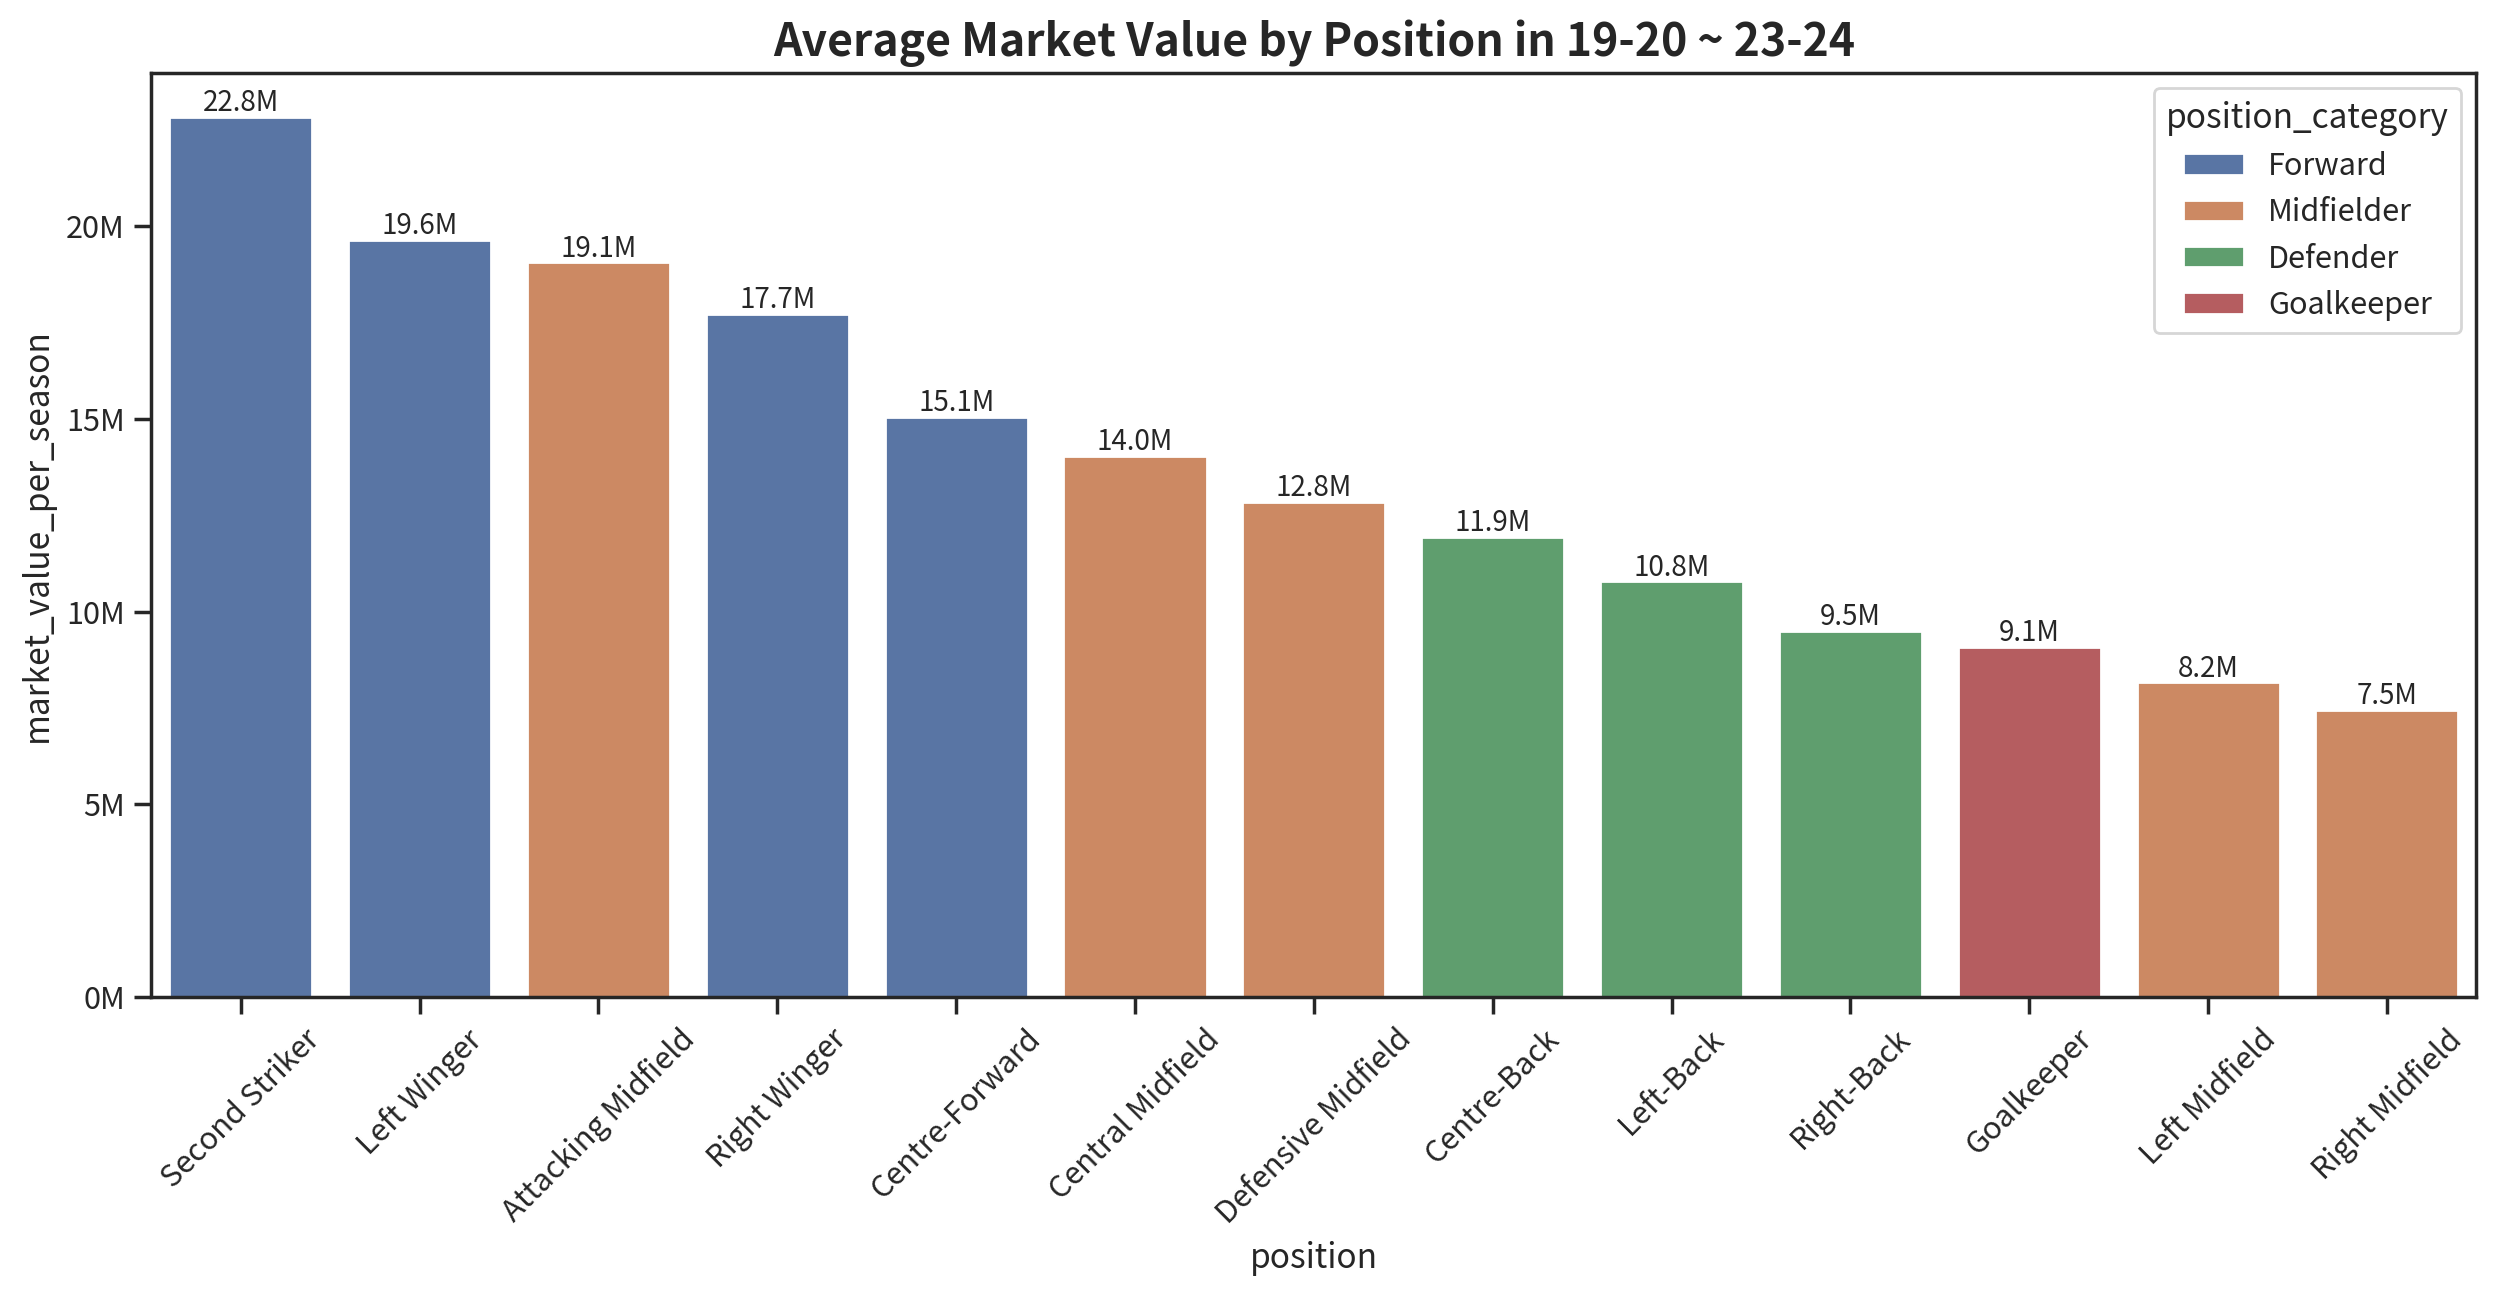

In [79]:
# y축을 M 단위로 표시하기 위한 포맷터 함수
def millions(x, pos):
    """1,000,000 단위로 나누어 M을 추가"""
    return '%1.0fM' % (x * 1e-6)

# 막대 위에 값 표시 함수 (소수점 둘째자리에서 반올림)
def add_value_labels(ax, spacing=5):
    """각 막대 위에 값 표시, 소수점 둘째 자리까지 반올림"""
    for p in ax.patches:
        value = p.get_height()
        if value > 0:  # 값이 0보다 큰 경우만 레이블 추가
            # 소수점 둘째자리에서 반올림한 값 표시
            ax.annotate(f'{round(value*1e-6, 1)}M',
                        (p.get_x() + p.get_width() / 2., value),
                        ha='center', va='center', 
                        xytext=(0, spacing),  # 텍스트를 막대 위로 조금 띄움
                        textcoords='offset points', fontsize=10)

# 그래프 생성
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=value_for_pos, x="position", y="market_value_per_season", hue="position_category")

# x축 레이블 회전
plt.xticks(rotation=45)

# y축 포맷 설정 (M 단위)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

# 그래프 타이틀 설정
plt.title("Average Market Value by Position in 19-20 ~ 23-24", fontsize=16, fontweight="bold")

# 막대 위에 값 추가
add_value_labels(ax)

# 그래프 보여주기
plt.show()

In [80]:
value_for_pos_season = df_copy.groupby(["start_season", "position_category", "position"])["market_value_per_season"].mean().to_frame().sort_values(by="market_value_per_season", ascending=False).reset_index()

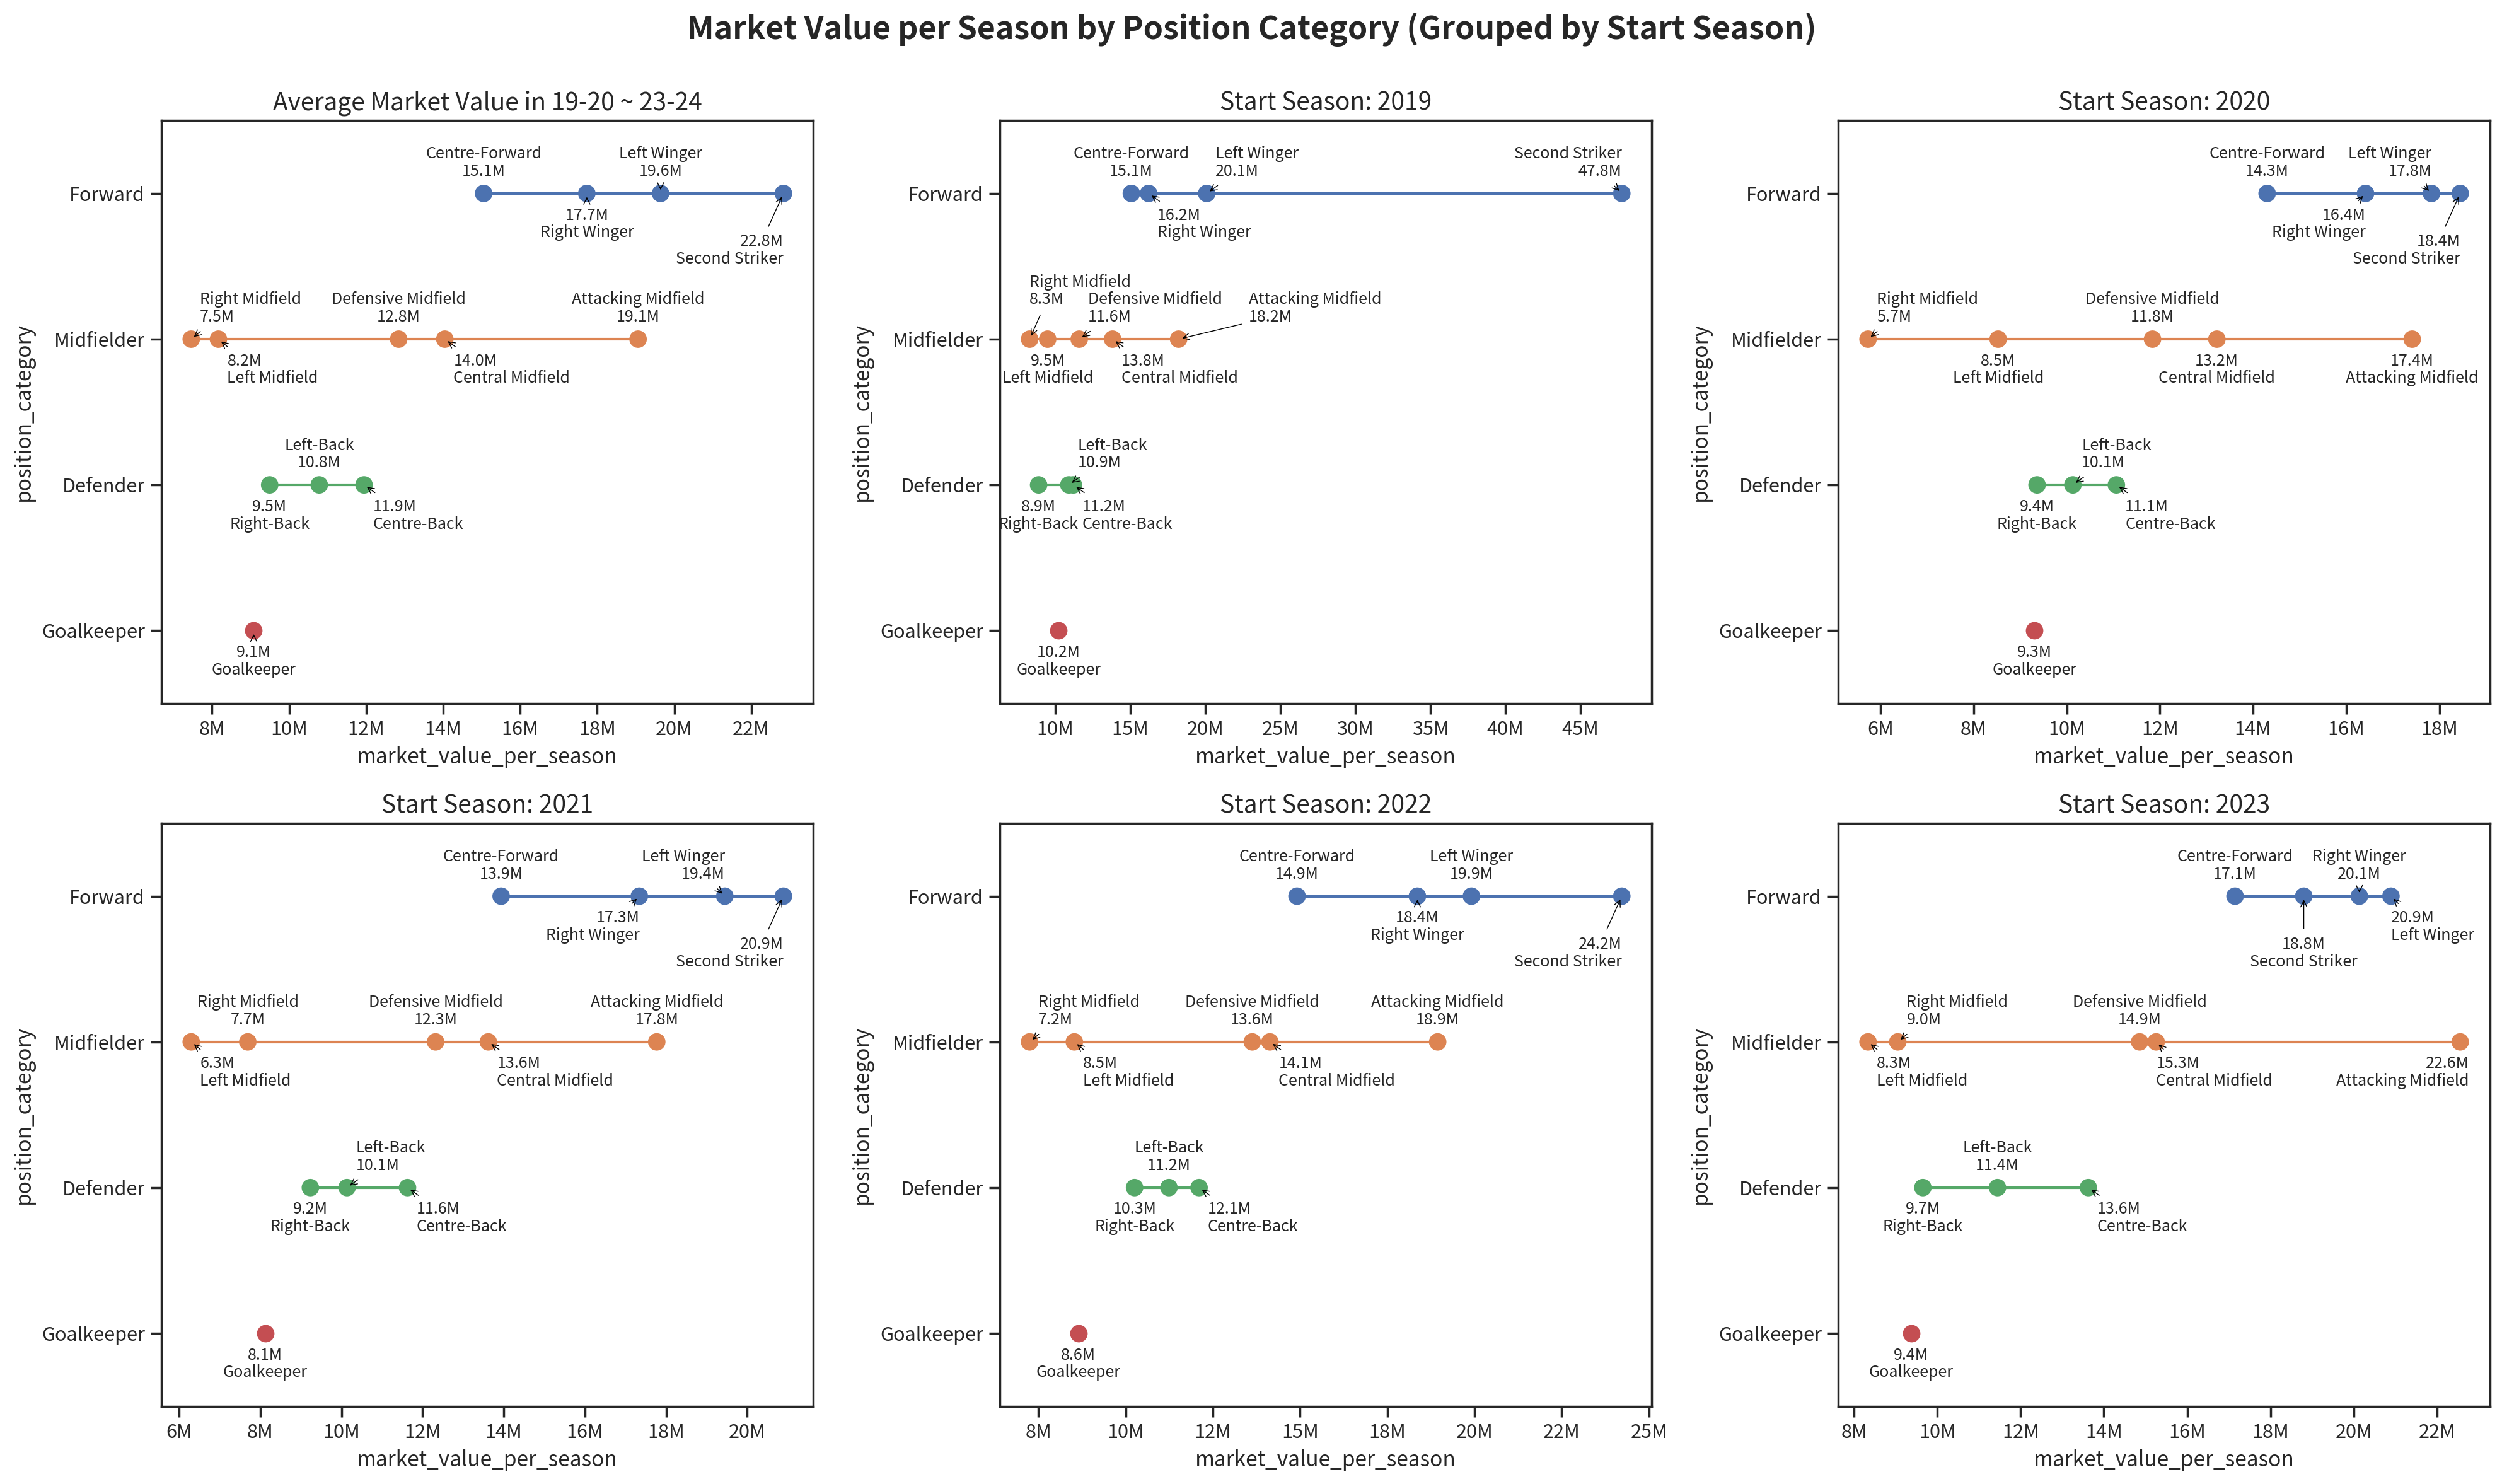

In [82]:
# Subplot을 2x3 형태로 생성
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 12))
axes = axes.flatten()  # 2x3 배열을 1차원 배열로 펼침

# 첫 번째 subplot: Cleveland Dot Plot
ax = axes[0]

# 선을 연결하는 lineplot 추가
sns.lineplot(data=value_for_pos, x="market_value_per_season", y="position_category", 
             hue="position_category", estimator=None, markers="", dashes=False, legend=False, ax=ax)

# 데이터 포인트를 표시하는 stripplot 추가
sns.stripplot(data=value_for_pos, x="market_value_per_season", y="position_category", 
              hue="position_category", jitter=False, marker="o", size=10, ax=ax)

# 각 데이터포인트에 market_value_per_season 및 position 표시
for i in range(value_for_pos.shape[0]):
    x = value_for_pos["market_value_per_season"].iloc[i]
    y = value_for_pos["position_category"].iloc[i]
    market_value = value_for_pos["market_value_per_season"].iloc[i] * 1e-6  # M 단위로 변환
    position = value_for_pos["position"].iloc[i]

    offset_market_value = 10
    offset_position = 20
    text_x = 0
    ha = 'center'
    arrowprops = None

    # elif season == "2023":
    if position in ["Right Midfield"]:
        text_x = 5
        ha = "left"
        arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
    elif position in ["Central Midfield", "Centre-Back", "Left Midfield"]:
        offset_market_value = -15
        offset_position = -25
        ha = "left"
        text_x = 5
        arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
    elif position in ["Right-Back"]:
        offset_market_value = -15
        offset_position = -25
    elif position == "Second Striker":
        ha = "right"
        offset_market_value = -30
        offset_position = -40
        arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
    elif position in ["Right Winger", "Goalkeeper"]:
        offset_market_value = -15
        offset_position = -25
        # ha = "left"
        arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
    elif position in ["Left Winger"]:
        ha = "center"
        arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
    
    # 상단에 market_value_per_season 값 표시
    ax.annotate(f'{market_value:.1f}M', (x, y), textcoords="offset points", xytext=(text_x, offset_market_value), ha=ha, fontsize=9, arrowprops=arrowprops)
    # 하단에 position 값 표시
    ax.annotate(position, (x, y), textcoords="offset points", xytext=(text_x, offset_position), ha=ha, fontsize=9, arrowprops=None)

# x축 포맷 설정 (M 단위)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.0f}M'))

# 그래프 타이틀 설정
ax.set_title("Average Market Value in 19-20 ~ 23-24", fontsize=14)


# 나머지 5개의 subplot: start_season별 데이터 시각화
category_order = ["Forward", "Midfielder", "Defender", "Goalkeeper"]

for i, season in enumerate(sorted(value_for_pos_season["start_season"].unique())[:5]):  # 5개의 season만 표시, 정렬된 순서로
    ax = axes[i + 1]  # 첫 번째 subplot을 사용했으므로 나머지는 i+1부터 시작
    
    # 해당 시즌의 데이터만 필터링하고 market_value_per_season 오름차순 정렬
    season_data = value_for_pos_season[value_for_pos_season["start_season"] == season].sort_values(by="market_value_per_season")
    
    # y축 순서를 category_order로 고정
    season_data["position_category"] = pd.Categorical(season_data["position_category"], categories=category_order, ordered=True)

    # 선을 연결하는 lineplot 추가 (position_category 순서를 고정)
    sns.lineplot(data=season_data, x="market_value_per_season", y="position_category", 
                 hue="position_category", hue_order=category_order, estimator=None, markers="", dashes=False, legend=False, ax=ax)
    
    # 데이터 포인트를 표시하는 stripplot 추가 (position_category 순서를 고정)
    sns.stripplot(data=season_data, x="market_value_per_season", y="position_category", 
                  hue="position_category", hue_order=category_order, jitter=False, marker="o", size=10, ax=ax)

    # 각 데이터포인트에 market_value_per_season 및 position 표시
    for j in range(season_data.shape[0]):
        x = season_data["market_value_per_season"].iloc[j]
        y = season_data["position_category"].iloc[j]
        market_value = season_data["market_value_per_season"].iloc[j] * 1e-6  # M 단위로 변환
        position = season_data["position"].iloc[j]
        
        offset_market_value = 10
        offset_position = 20
        text_x = 0
        ha = 'center'
        arrowprops = None

        if season == "2019":
            if position in ["Left Winger", "Left-Back", "Defensive Midfield"]:
                text_x = 5
                ha = "left"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right Midfield"]:
                ha = "left"
                offset_market_value = 20
                offset_position = 30
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Central Midfield", "Right Winger", "Centre-Back"]:
                offset_market_value = -15
                offset_position = -25
                ha = "left"
                text_x = 5
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Attacking Midfield"]:
                ha = "left"
                text_x = 40
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right-Back", "Left Midfield", "Goalkeeper"]:
                offset_market_value = -15
                offset_position = -25
            elif position in ["Second Striker"]:
                ha = "right"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
        
        elif season == "2020":
            if position in ["Left-Back", "Right Midfield"]:
                text_x = 5
                ha = "left"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Centre-Back"]:
                offset_market_value = -15
                offset_position = -25
                ha = "left"
                text_x = 5
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right-Back", "Left Midfield", "Central Midfield", "Attacking Midfield", "Goalkeeper"]:
                offset_market_value = -15
                offset_position = -25
            elif position == "Second Striker":
                ha = "right"
                offset_market_value = -30
                offset_position = -40
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right Winger"]:
                ha = "right"
                offset_market_value = -15
                offset_position = -25
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Left Winger"]:
                ha = "right"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)

        elif season == "2021":
            if position in ["Left-Back"]:
                text_x = 5
                ha = "left"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Central Midfield", "Centre-Back", "Left Midfield"]:
                offset_market_value = -15
                offset_position = -25
                ha = "left"
                text_x = 5
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right-Back", "Goalkeeper"]:
                offset_market_value = -15
                offset_position = -25
            elif position == "Second Striker":
                ha = "right"
                offset_market_value = -30
                offset_position = -40
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right Winger"]:
                offset_market_value = -15
                offset_position = -25
                ha = "right"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Left Winger"]:
                ha = "right"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)

        elif season == "2022":
            if position in ["Right Midfield"]:
                text_x = 5
                ha = "left"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Central Midfield", "Centre-Back", "Left Midfield"]:
                offset_market_value = -15
                offset_position = -25
                ha = "left"
                text_x = 5
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right-Back", "Goalkeeper"]:
                offset_market_value = -15
                offset_position = -25
            elif position == "Second Striker":
                ha = "right"
                offset_market_value = -30
                offset_position = -40
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right Winger"]:
                offset_market_value = -15
                offset_position = -25
                ha = "center"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)

        elif season == "2023":
            if position in ["Right Midfield"]:
                text_x = 5
                ha = "left"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Centre-Back", "Left Midfield"]:
                offset_market_value = -15
                offset_position = -25
                ha = "left"
                text_x = 5
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right-Back", "Goalkeeper"]:
                offset_market_value = -15
                offset_position = -25
            elif position == "Second Striker":
                ha = "center"
                offset_market_value = -30
                offset_position = -40
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Left Winger", "Central Midfield"]:
                offset_market_value = -15
                offset_position = -25
                ha = "left"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Right Winger"]:
                ha = "center"
                arrowprops=dict(arrowstyle="->", color='black', lw=0.5)
            elif position in ["Attacking Midfield"]:
                offset_market_value = -15
                offset_position = -25
                ha = "right"
                text_x = 5
        
        # 상단에 market_value_per_season 값 표시
        ax.annotate(f'{market_value:.1f}M', (x, y), textcoords="offset points", xytext=(text_x, offset_market_value), ha=ha, fontsize=9, arrowprops=arrowprops)

        # 하단에 position 값 표시
        ax.annotate(position, (x, y), textcoords="offset points", xytext=(text_x, offset_position), ha=ha, fontsize=9, arrowprops=None)

    # x축 포맷 설정 (M 단위)
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x*1e-6:.0f}M'))

    # subplot 제목 설정
    ax.set_title(f'Start Season: {season}', fontsize=14)

# # 남은 빈 subplot은 숨김 처리
# for i in range(5, len(axes)):
#     fig.delaxes(axes[i])

# 전체 그래프 타이틀 설정
fig.suptitle("Market Value per Season by Position Category (Grouped by Start Season)", fontsize=18, fontweight="bold")

# 레이아웃 조정 및 그래프 보여주기
plt.tight_layout(rect=[0, 0, 1, 0.98])  # 타이틀을 위해 여백 추가
plt.show()


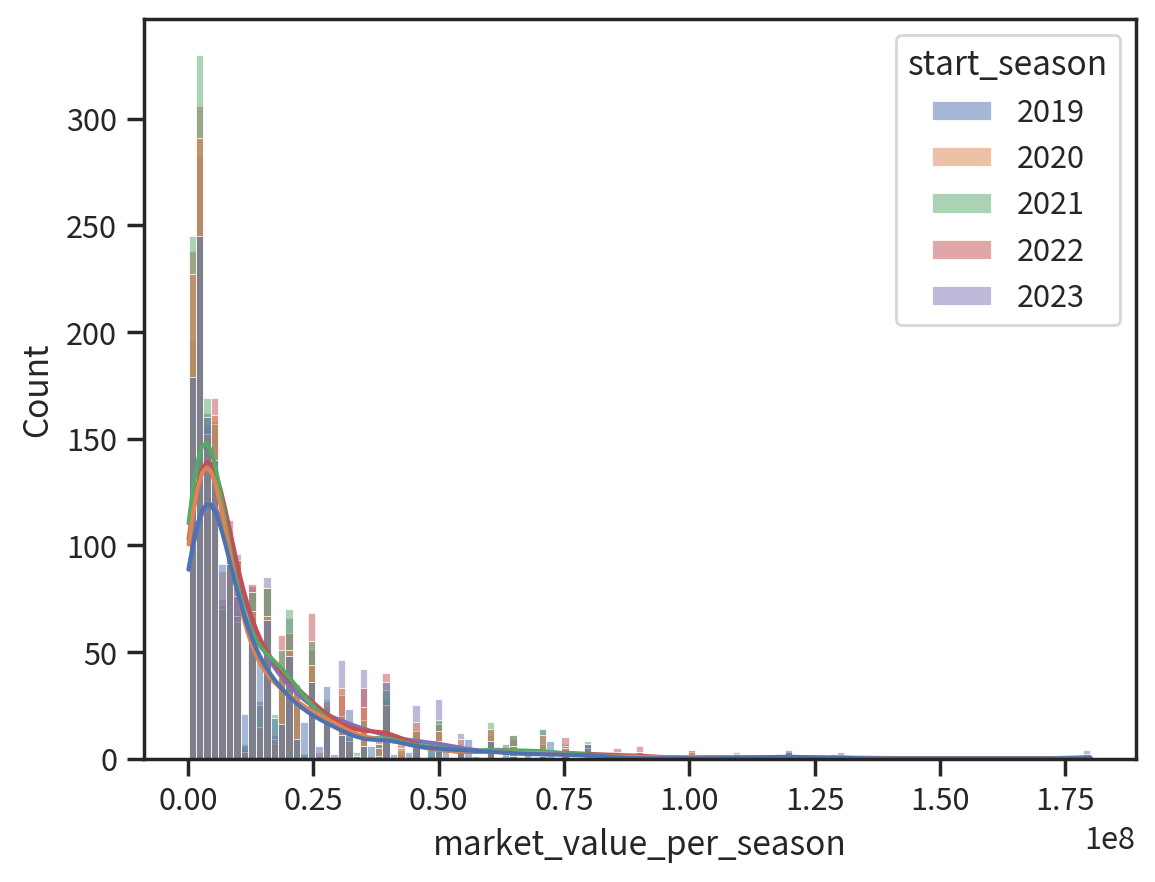

In [84]:
sns.histplot(data=df_copy, x="market_value_per_season", kde=True, hue="start_season")
plt.show()

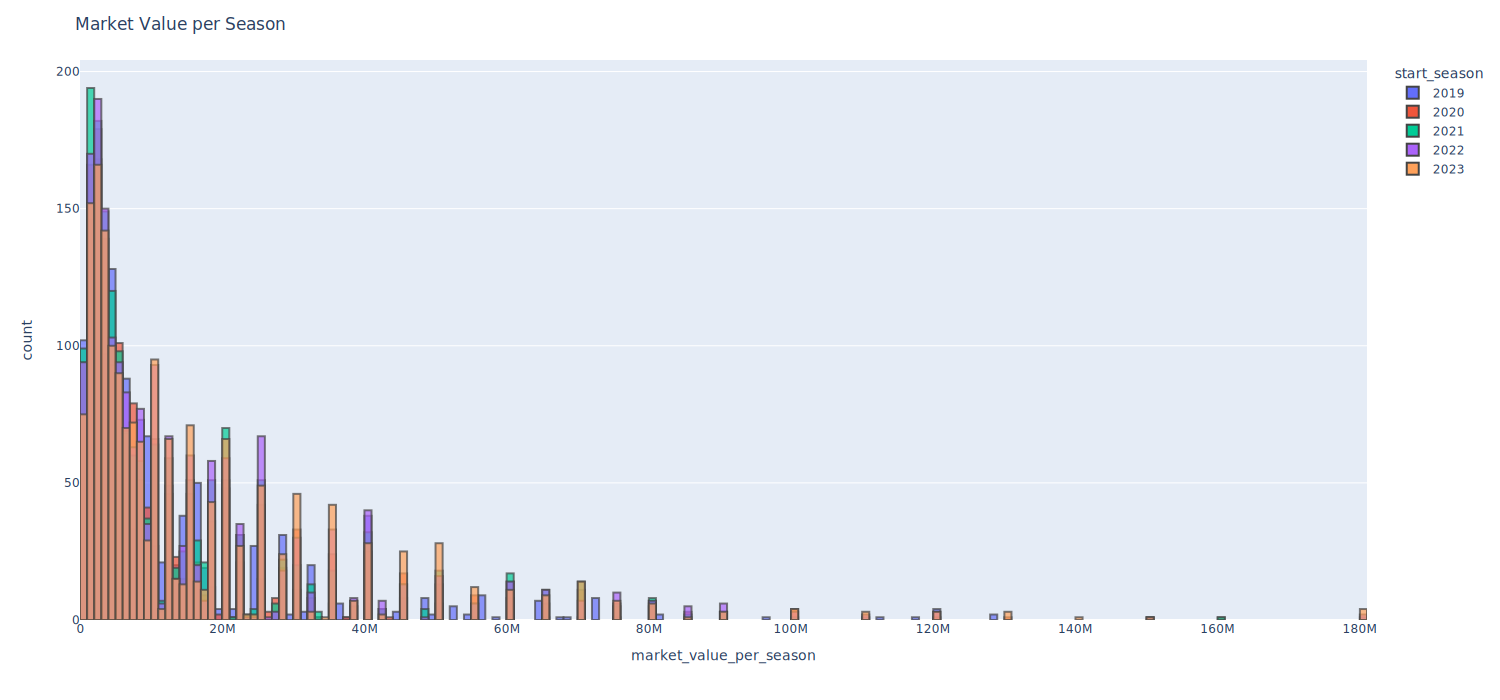

In [203]:
# 시즌별 선수 몸값
fig = px.histogram(data_frame=df_copy, x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay',  title_text="Market Value per Season")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 20M 넘는 선수들로 확인

In [64]:
print("원본 df shape :", df.shape)
print("20M 유로 넘는 선수들 :", df[df.market_value_per_season >= 20000000].shape)

원본 df shape : (9347, 22)
20M 유로 넘는 선수들 : (2063, 22)


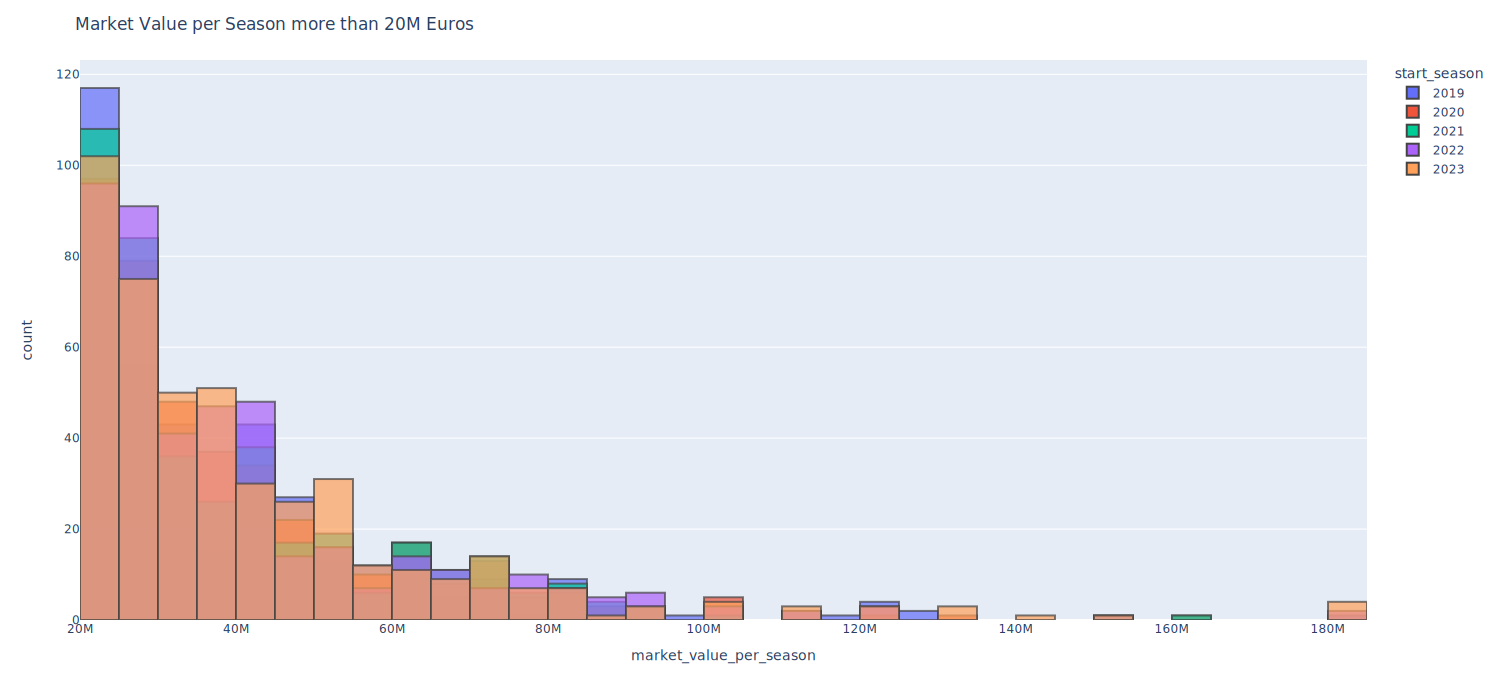

In [65]:
fig = px.histogram(data_frame=df[df.market_value_per_season >= 20000000], x="market_value_per_season", color="start_season",
                   width=1500, height=700)

fig.update_layout(barmode='overlay', title_text="Market Value per Season more than 20M Euros")

fig.update_traces(marker_line_width=2, marker_opacity =0.7)

fig.show()

#### 100M 유로 넘는 선수들 확인

In [66]:
df[df.market_value_per_season>=100000000].head(3)

player_name start_season  yellow_cards  red_cards  goals  assists  \
153    Jadon Sancho         2019           2.0        0.0   17.0     17.0   
590  Erling Haaland         2020           2.0        0.0   27.0      8.0   
637    Jadon Sancho         2020           0.0        0.0    8.0     12.0   

     minutes_played competition_code date_of_birth        position  \
153          2292.0       bundesliga    2000-03-25     Left Winger   
590          2410.0       bundesliga    2000-07-21  Centre-Forward   
637          2071.0       bundesliga    2000-03-25     Left Winger   

     current_club_name  market_value_per_season  country   foot  height_in_cm  \
153  Borussia Dortmund              117000000.0  England  right         180.0   
590    Manchester City              130000000.0   Norway   left         195.0   
637  Borussia Dortmund              100000000.0  England  right         180.0   

            xG         xA  shots  key_passes    xGChain  xGBuildup  age  
153  10.752355  11.467584   52.0        69.0  28.819598  11.866170   20  
590  23.598484   4.035448   92.0        27.0  27.197287   5.896189   21  
637   6.754483   8.243653   52.0        67.0  20.981892  10.953148   21

In [67]:
# 시장가치 100M 유로 넘는 선수들 확인

# 시장가치 100M 유로 넘는 선수들 중, player_name으로 groupby한 선수들의 market_value_per_season 최대값 중복해서 조회
mm = df[df.market_value_per_season>=100000000]
more_than_100 = mm.groupby("player_name", as_index=False).market_value_per_season.max().merge(mm)

# 득점, 어시스트 합산해서 공격포인트 (g+a) 컬럼 생성
more_than_100["g+a"] = more_than_100["goals"] + more_than_100["assists"]
more_than_100.sort_values("start_season", ascending=False).head(15)

player_name  market_value_per_season start_season  yellow_cards  \
0   Aurélien Tchouaméni              100000000.0         2023           6.0   
11        Jamal Musiala              130000000.0         2023           2.0   
27              Rodrygo              110000000.0         2023           2.0   
26                Rodri              130000000.0         2023           8.0   
24           Phil Foden              150000000.0         2023           2.0   
20      Martin Ødegaard              110000000.0         2023           2.0   
18     Lautaro Martínez              110000000.0         2023           5.0   
17         Lamine Yamal              120000000.0         2023           3.0   
1           Bukayo Saka              140000000.0         2023           4.0   
12      Jude Bellingham              180000000.0         2023           5.0   
16        Kylian Mbappé              180000000.0         2023           4.0   
32      Vinicius Junior              180000000.0         2023           7.0   
3     Eduardo Camavinga              100000000.0         2023           9.0   
7         Florian Wirtz              130000000.0         2023           3.0   
6     Federico Valverde              120000000.0         2023           2.0   

    red_cards  goals  assists  minutes_played competition_code date_of_birth  \
0         0.0    3.0      1.0          1986.0           laliga    2000-01-27   
11        0.0   10.0      6.0          1767.0       bundesliga    2003-02-26   
27        0.0   10.0      5.0          2391.0           laliga    2001-01-09   
26        1.0    8.0      9.0          2938.0   premier-league    1996-06-22   
24        0.0   19.0      8.0          2871.0   premier-league    2000-05-28   
20        0.0    8.0     10.0          3104.0   premier-league    1998-12-17   
18        0.0   24.0      6.0          2667.0          serie-a    1997-08-22   
17        0.0    5.0      7.0          2196.0           laliga    2007-07-13   
1         0.0   16.0      9.0          2936.0   premier-league    2001-09-05   
12        1.0   19.0      6.0          2324.0           laliga    2003-06-29   
16        0.0   27.0      7.0          2159.0          ligue-1    1998-12-20   
32        0.0   15.0      6.0          1875.0           laliga    2000-07-12   
3         0.0    0.0      2.0          1823.0           laliga    2002-11-10   
7         0.0   11.0     12.0          2384.0       bundesliga    2003-05-03   
6         0.0    2.0      7.0          2911.0           laliga    1998-07-22   

              position    current_club_name    country   foot  height_in_cm  \
0   Defensive Midfield          Real Madrid     France  right         188.0   
11  Attacking Midfield        Bayern Munich    Germany  right         184.0   
27        Right Winger          Real Madrid     Brazil  right         174.0   
26  Defensive Midfield      Manchester City      Spain  right         191.0   
24        Right Winger      Manchester City    England   left         171.0   
20  Attacking Midfield           Arsenal FC     Norway   left         178.0   
18      Centre-Forward          Inter Milan  Argentina  right         174.0   
17        Right Winger         FC Barcelona      Spain   left         180.0   
1         Right Winger           Arsenal FC    England   left         178.0   
12  Attacking Midfield          Real Madrid    England  right         186.0   
16      Centre-Forward  Paris Saint-Germain     France  right         178.0   
32         Left Winger          Real Madrid     Brazil  right         176.0   
3     Central Midfield          Real Madrid     France   left         182.0   
7   Attacking Midfield  Bayer 04 Leverkusen    Germany  right         177.0   
6     Central Midfield          Real Madrid    Uruguay  right         182.0   

           xG         xA  shots  key_passes    xGChain  xGBuildup  age   g+a  
0    1.128483   1.016306   27.0        10.0  14.342183  13.378328   24   4.0  
11   8.374677   6.257946   58.0        41.0

In [68]:
more_than_100 = more_than_100.sort_values("start_season")

##### Goals, Assists 시각화

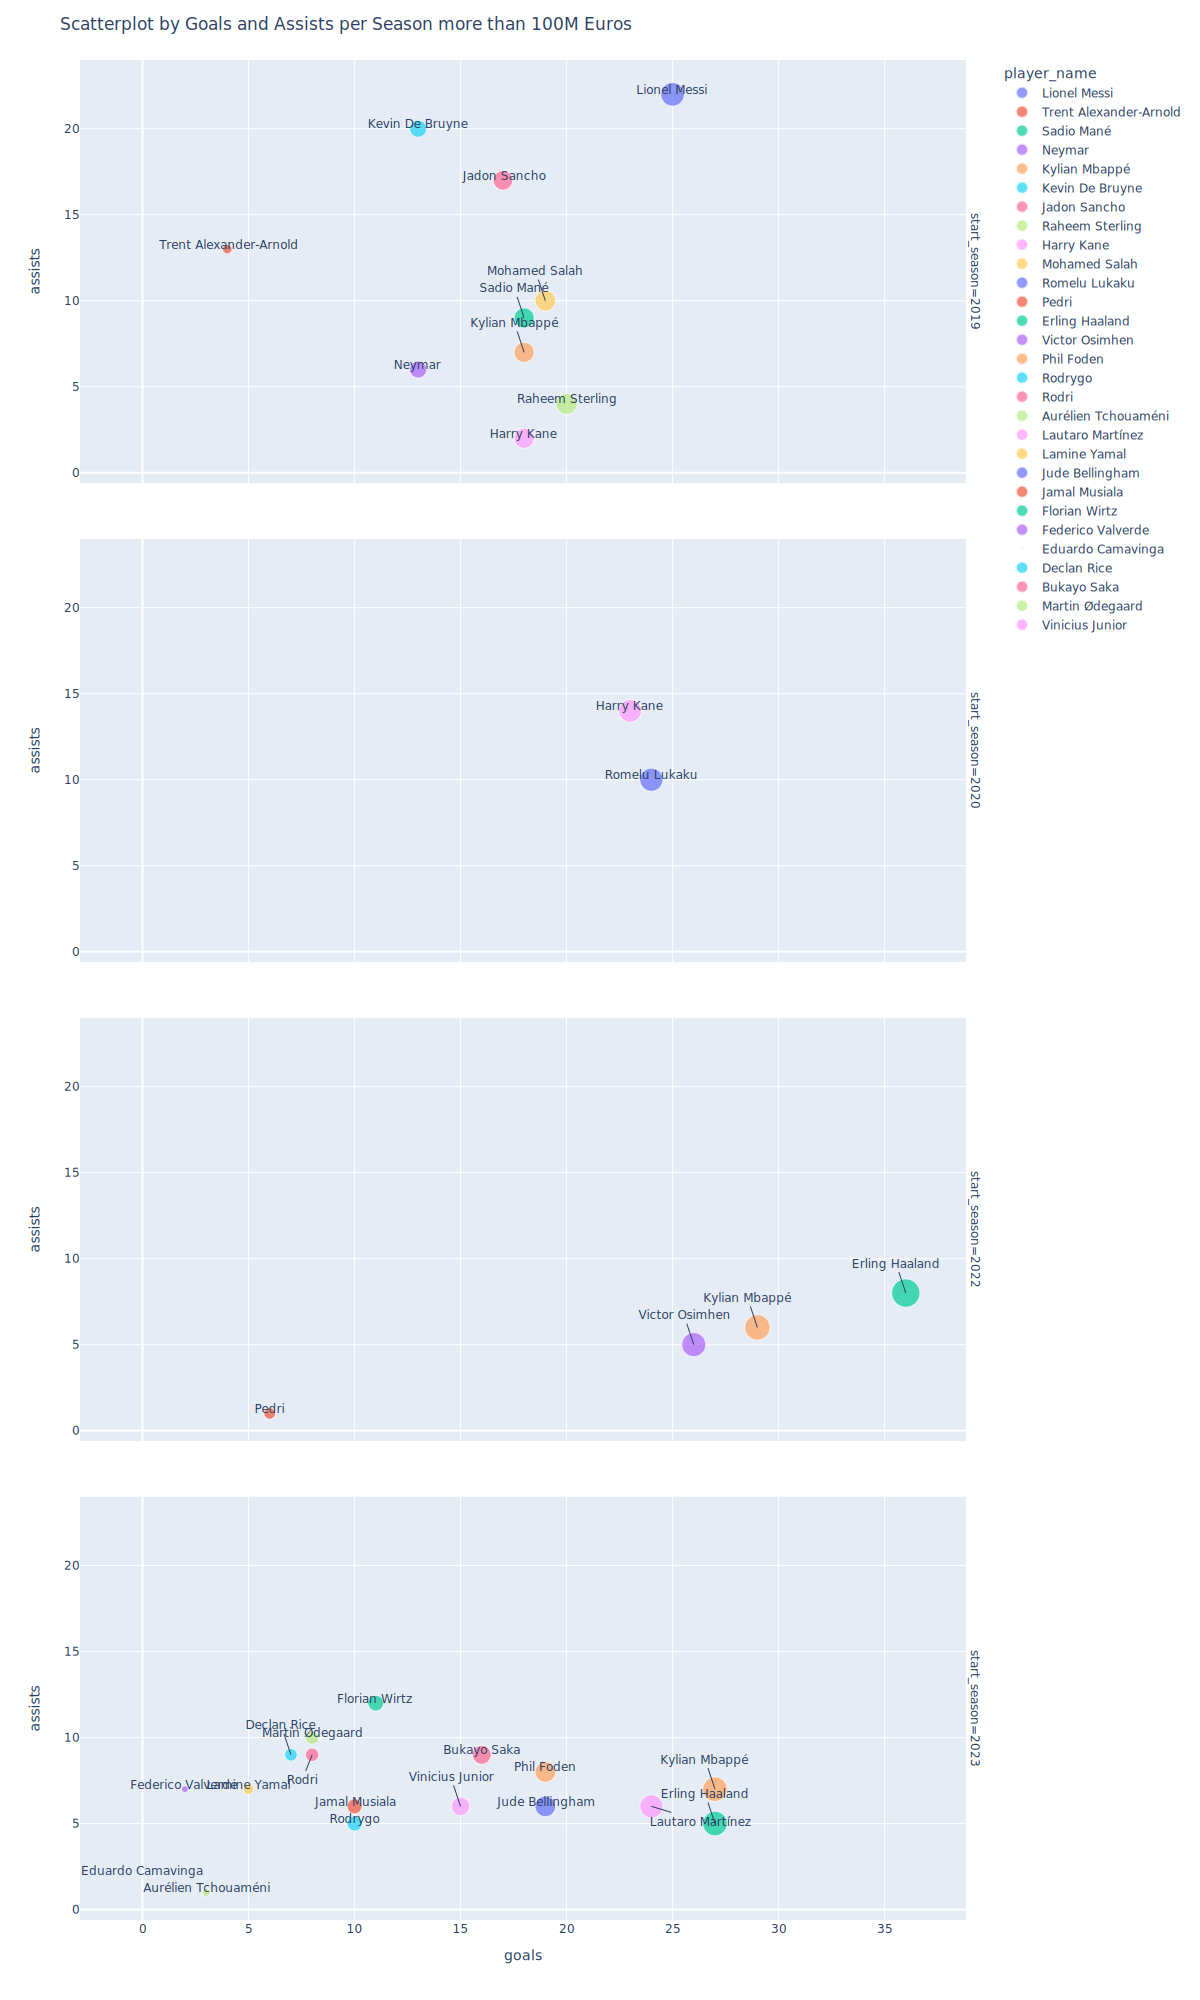

In [69]:
# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="goals", y="assists", color="player_name", 
                 size="goals", facet_row="start_season", 
                #  text="player_name",
                 width=1200, height=2000)

fig.update_layout(title_text="Scatterplot by Goals and Assists per Season more than 100M Euros")
# fig.update_traces(textposition="top right")

overlapped_names = ["Vinicius Junior", "Sadio Mané", "Declan Rice", "Victor Osimhen", 
                    "Mohamed Salah", "Erling Haaland", "Kylian Mbappé"]
                    # "Phil Foden",Rodrygo"]

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri"]:
                                                    # "Jamal Musiala"]:
                                 fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            
            elif seasonal.loc[j, "player_name"] in ["Lautaro Martínez"]:
                                 fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ax=50,
                                    ay=15,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                 
            else:
                fig.add_annotation(x=seasonal.loc[j, "goals"], y=seasonal.loc[j, "assists"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.show()

##### 공격포인트 합산 시각화

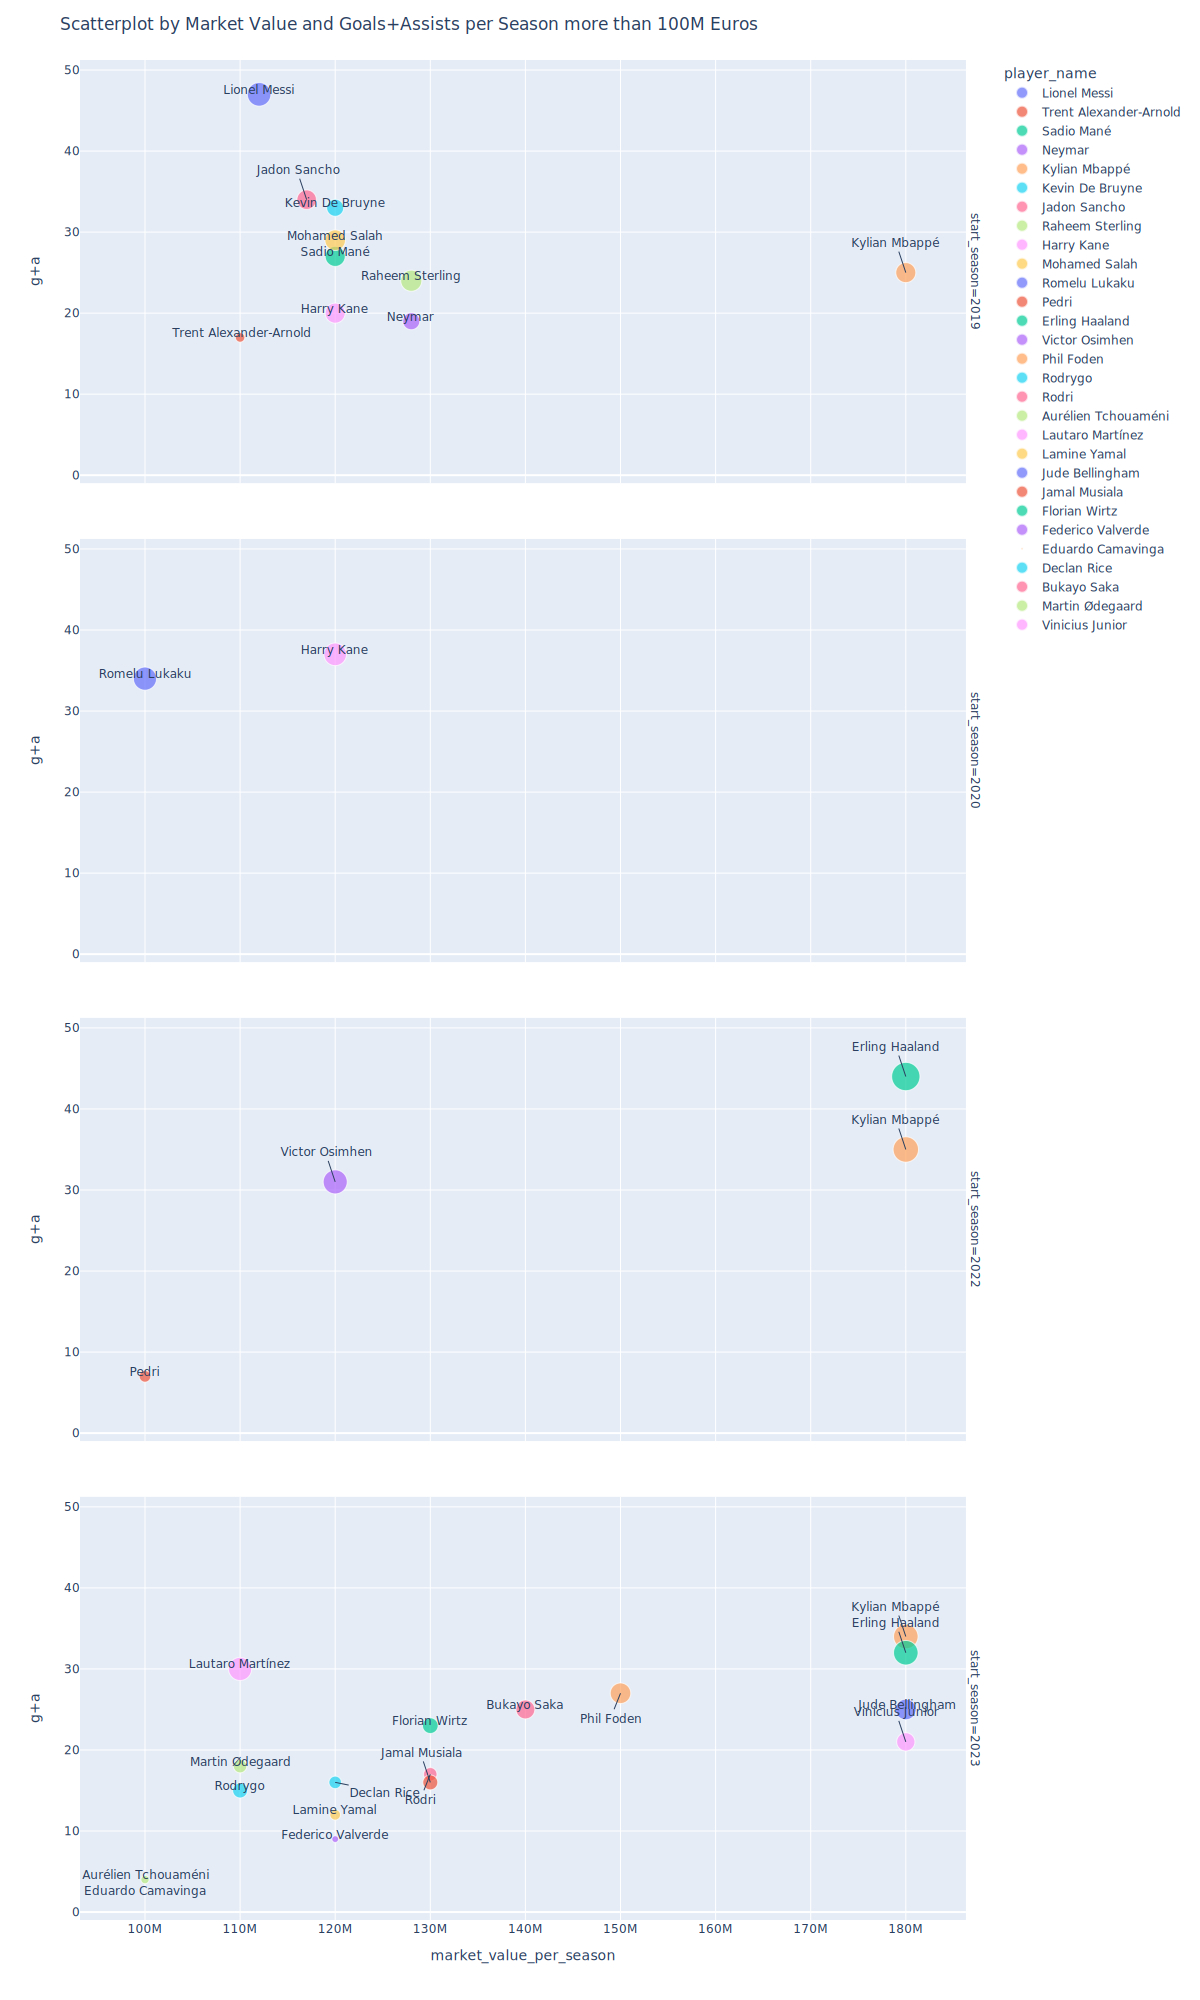

In [70]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="market_value_per_season", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                #  text="player_name",
                 width=1200, height=2000)


overlapped_names = ["Jadon Sancho", "Jamal Musiala", "Victor Osimhen", 
                    "Vinicius Junior", "Erling Haaland", "Kylian Mbappé"]
                    # "Phil Foden",

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri", "Phil Foden"]:
                                                    # "Rodrygo"]:
                                 fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # ax = 25,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            
            elif seasonal.loc[j, "player_name"] == "Declan Rice":
                                 fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ax = 50,
                                    ay=10,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                 
            else:
                fig.add_annotation(x=seasonal.loc[j, "market_value_per_season"], y=seasonal.loc[j, "g+a"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Market Value and Goals+Assists per Season more than 100M Euros")
# fig.update_traces(textposition="top center")
fig.show()

#### 포지션별 평균 market_value_per_season

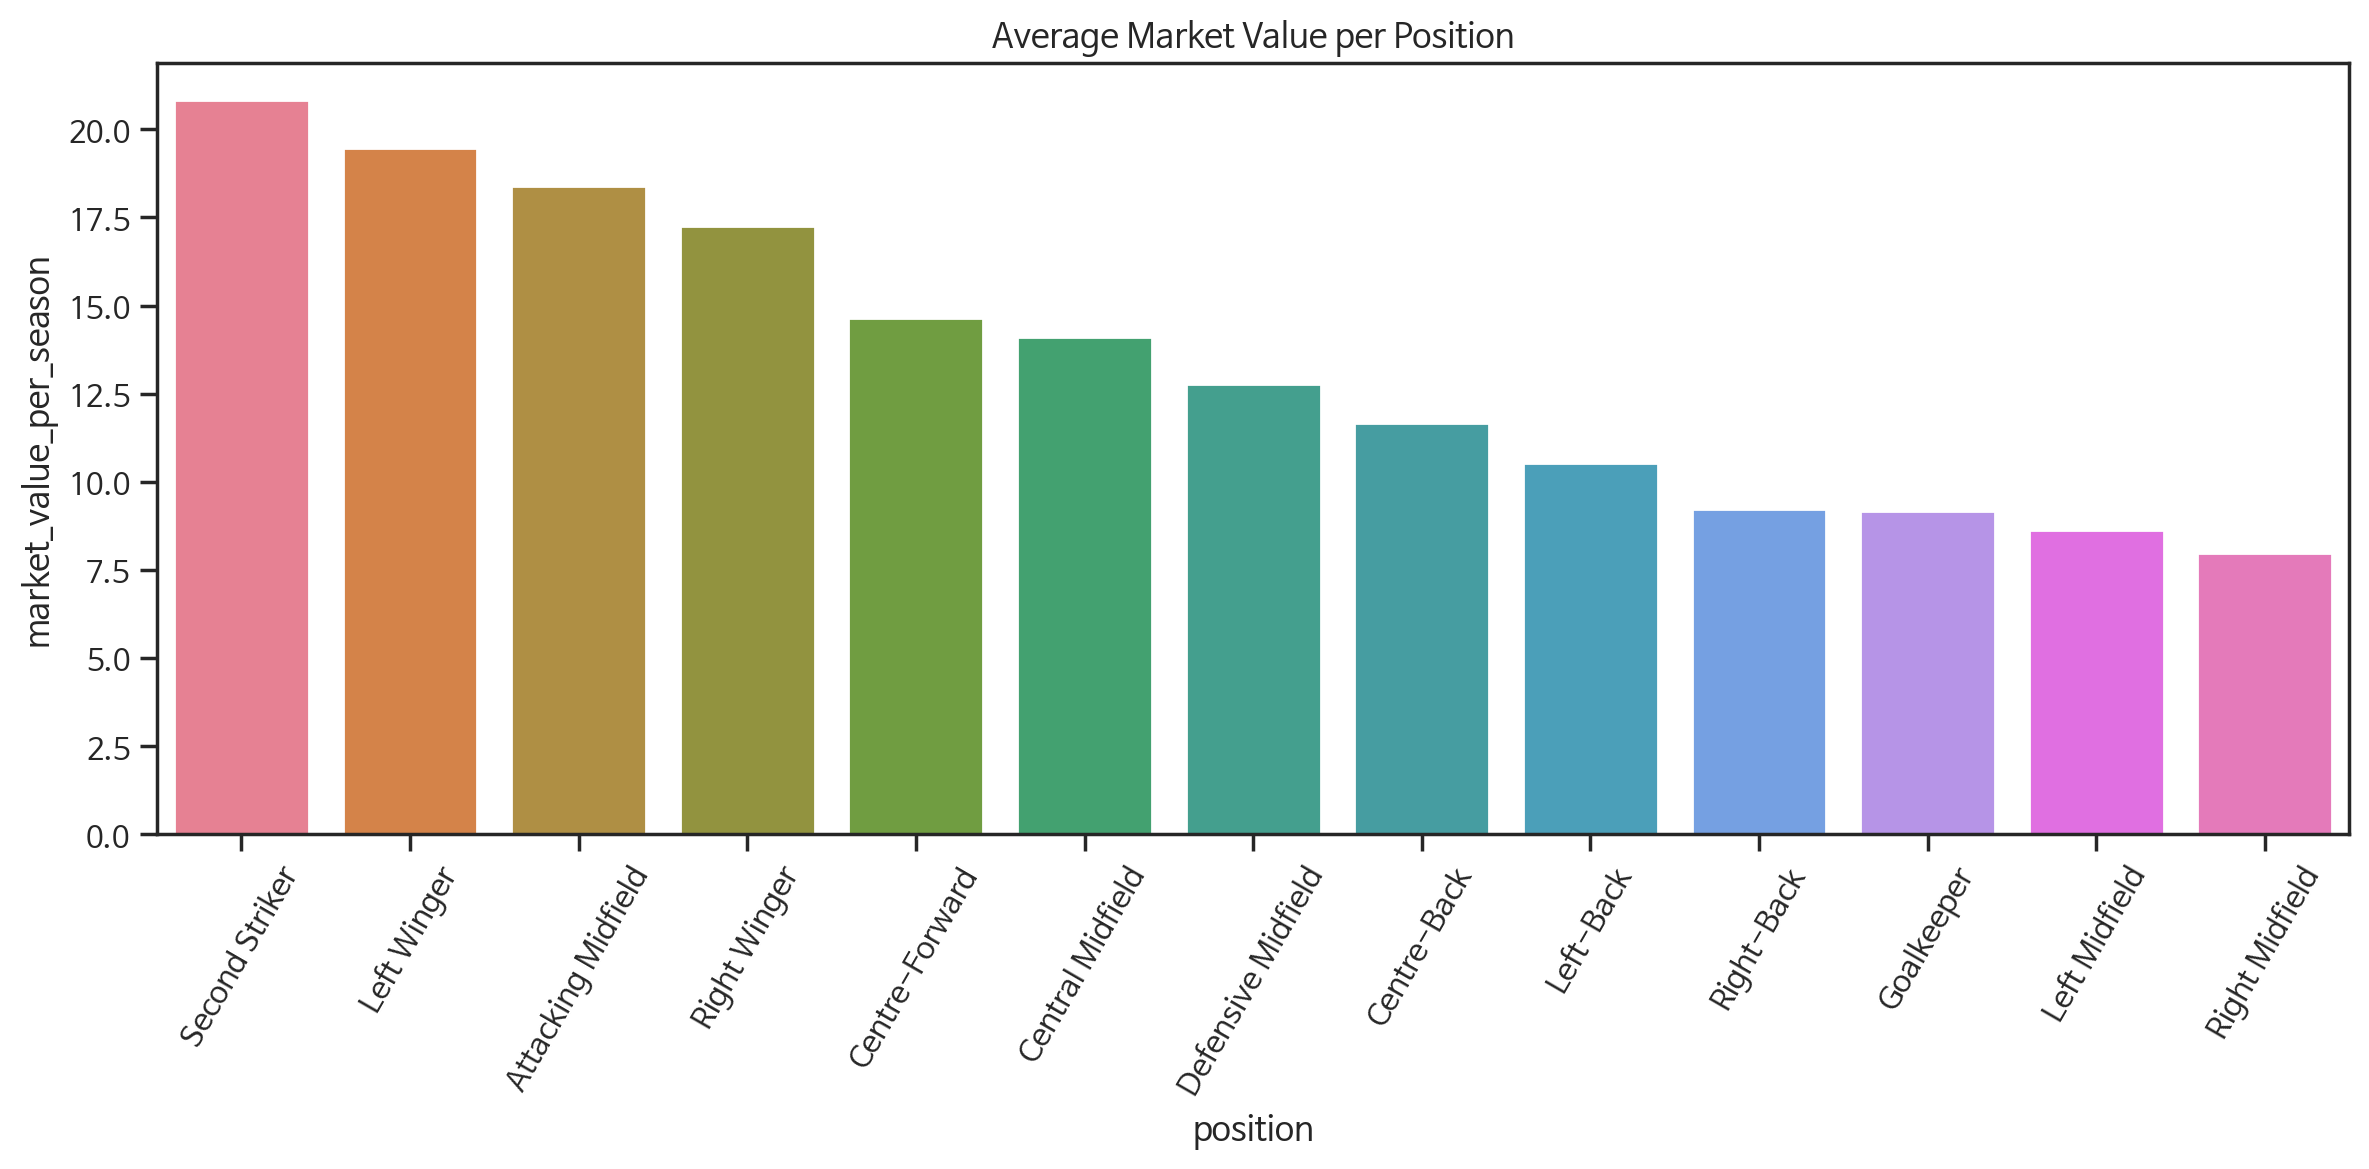

In [71]:
# Left Winger가 가장 평균 몸값이 비싸다
plt.figure(figsize=(12, 6))

per_position = df.groupby("position").mean("market_value_per_season").sort_values("market_value_per_season", ascending=False).reset_index()

g = sns.barplot(data=per_position, x="position", y=per_position["market_value_per_season"]/1000000,
                # dodge=False,
                hue="position")
g.set_xticklabels(g.get_xticklabels(), rotation=60)
plt.title("Average Market Value per Position")
plt.tight_layout()
plt.show()


In [72]:
# Left Winger 몸값 비싼 순위 Top 5
df[df.position=="Left Winger"].sort_values("market_value_per_season", ascending=False).head(5)

player_name start_season  yellow_cards  red_cards  goals  assists  \
10212  Vinicius Junior         2023           7.0        0.0   15.0      6.0   
9686   Vinicius Junior         2022          10.0        1.0   10.0     10.0   
5621   Raheem Sterling         2019           5.0        0.0   20.0      4.0   
10588           Neymar         2019           4.0        0.0   13.0      6.0   
5649        Sadio Mané         2019           3.0        0.0   18.0      9.0   

       minutes_played competition_code date_of_birth     position  \
10212          1875.0           laliga    2000-07-12  Left Winger   
9686           2833.0           laliga    2000-07-12  Left Winger   
5621           2660.0   premier-league    1994-12-08  Left Winger   
10588          1322.0          ligue-1    1992-02-05  Left Winger   
5649           2755.0   premier-league    1992-04-10  Left Winger   

         current_club_name  market_value_per_season  country   foot  \
10212          Real Madrid              180000000.0   Brazil  right   
9686           Real Madrid              150000000.0   Brazil  right   
5621            Chelsea FC              128000000.0  England  right   
10588  Paris Saint-Germain              128000000.0   Brazil  right   
5649         Bayern Munich              120000000.0  Senegal  right   

       height_in_cm         xG        xA  shots  key_passes    xGChain  \
10212         176.0  15.999082  4.433579   78.0        31.0  20.517532   
9686          176.0  10.869106  9.859566   77.0        64.0  25.334139   
5621          170.0  19.799912  7.208590  100.0        48.0  31.442028   
10588         175.0  14.725106  5.246025   70.0        38.0  21.302691   
5649          174.0  14.577481  7.235698   77.0        59.0  25.073198   

       xGBuildup  age  
10212   4.835082   24  
9686    9.522749   23  
5621   10.186004   25  
10588   7.206127   28  
5649    6.767018   28

### `Age` 분석

#### 전체, 20M 유로 이상, 100M 유로 이상 몸값인 선수들끼리 비교

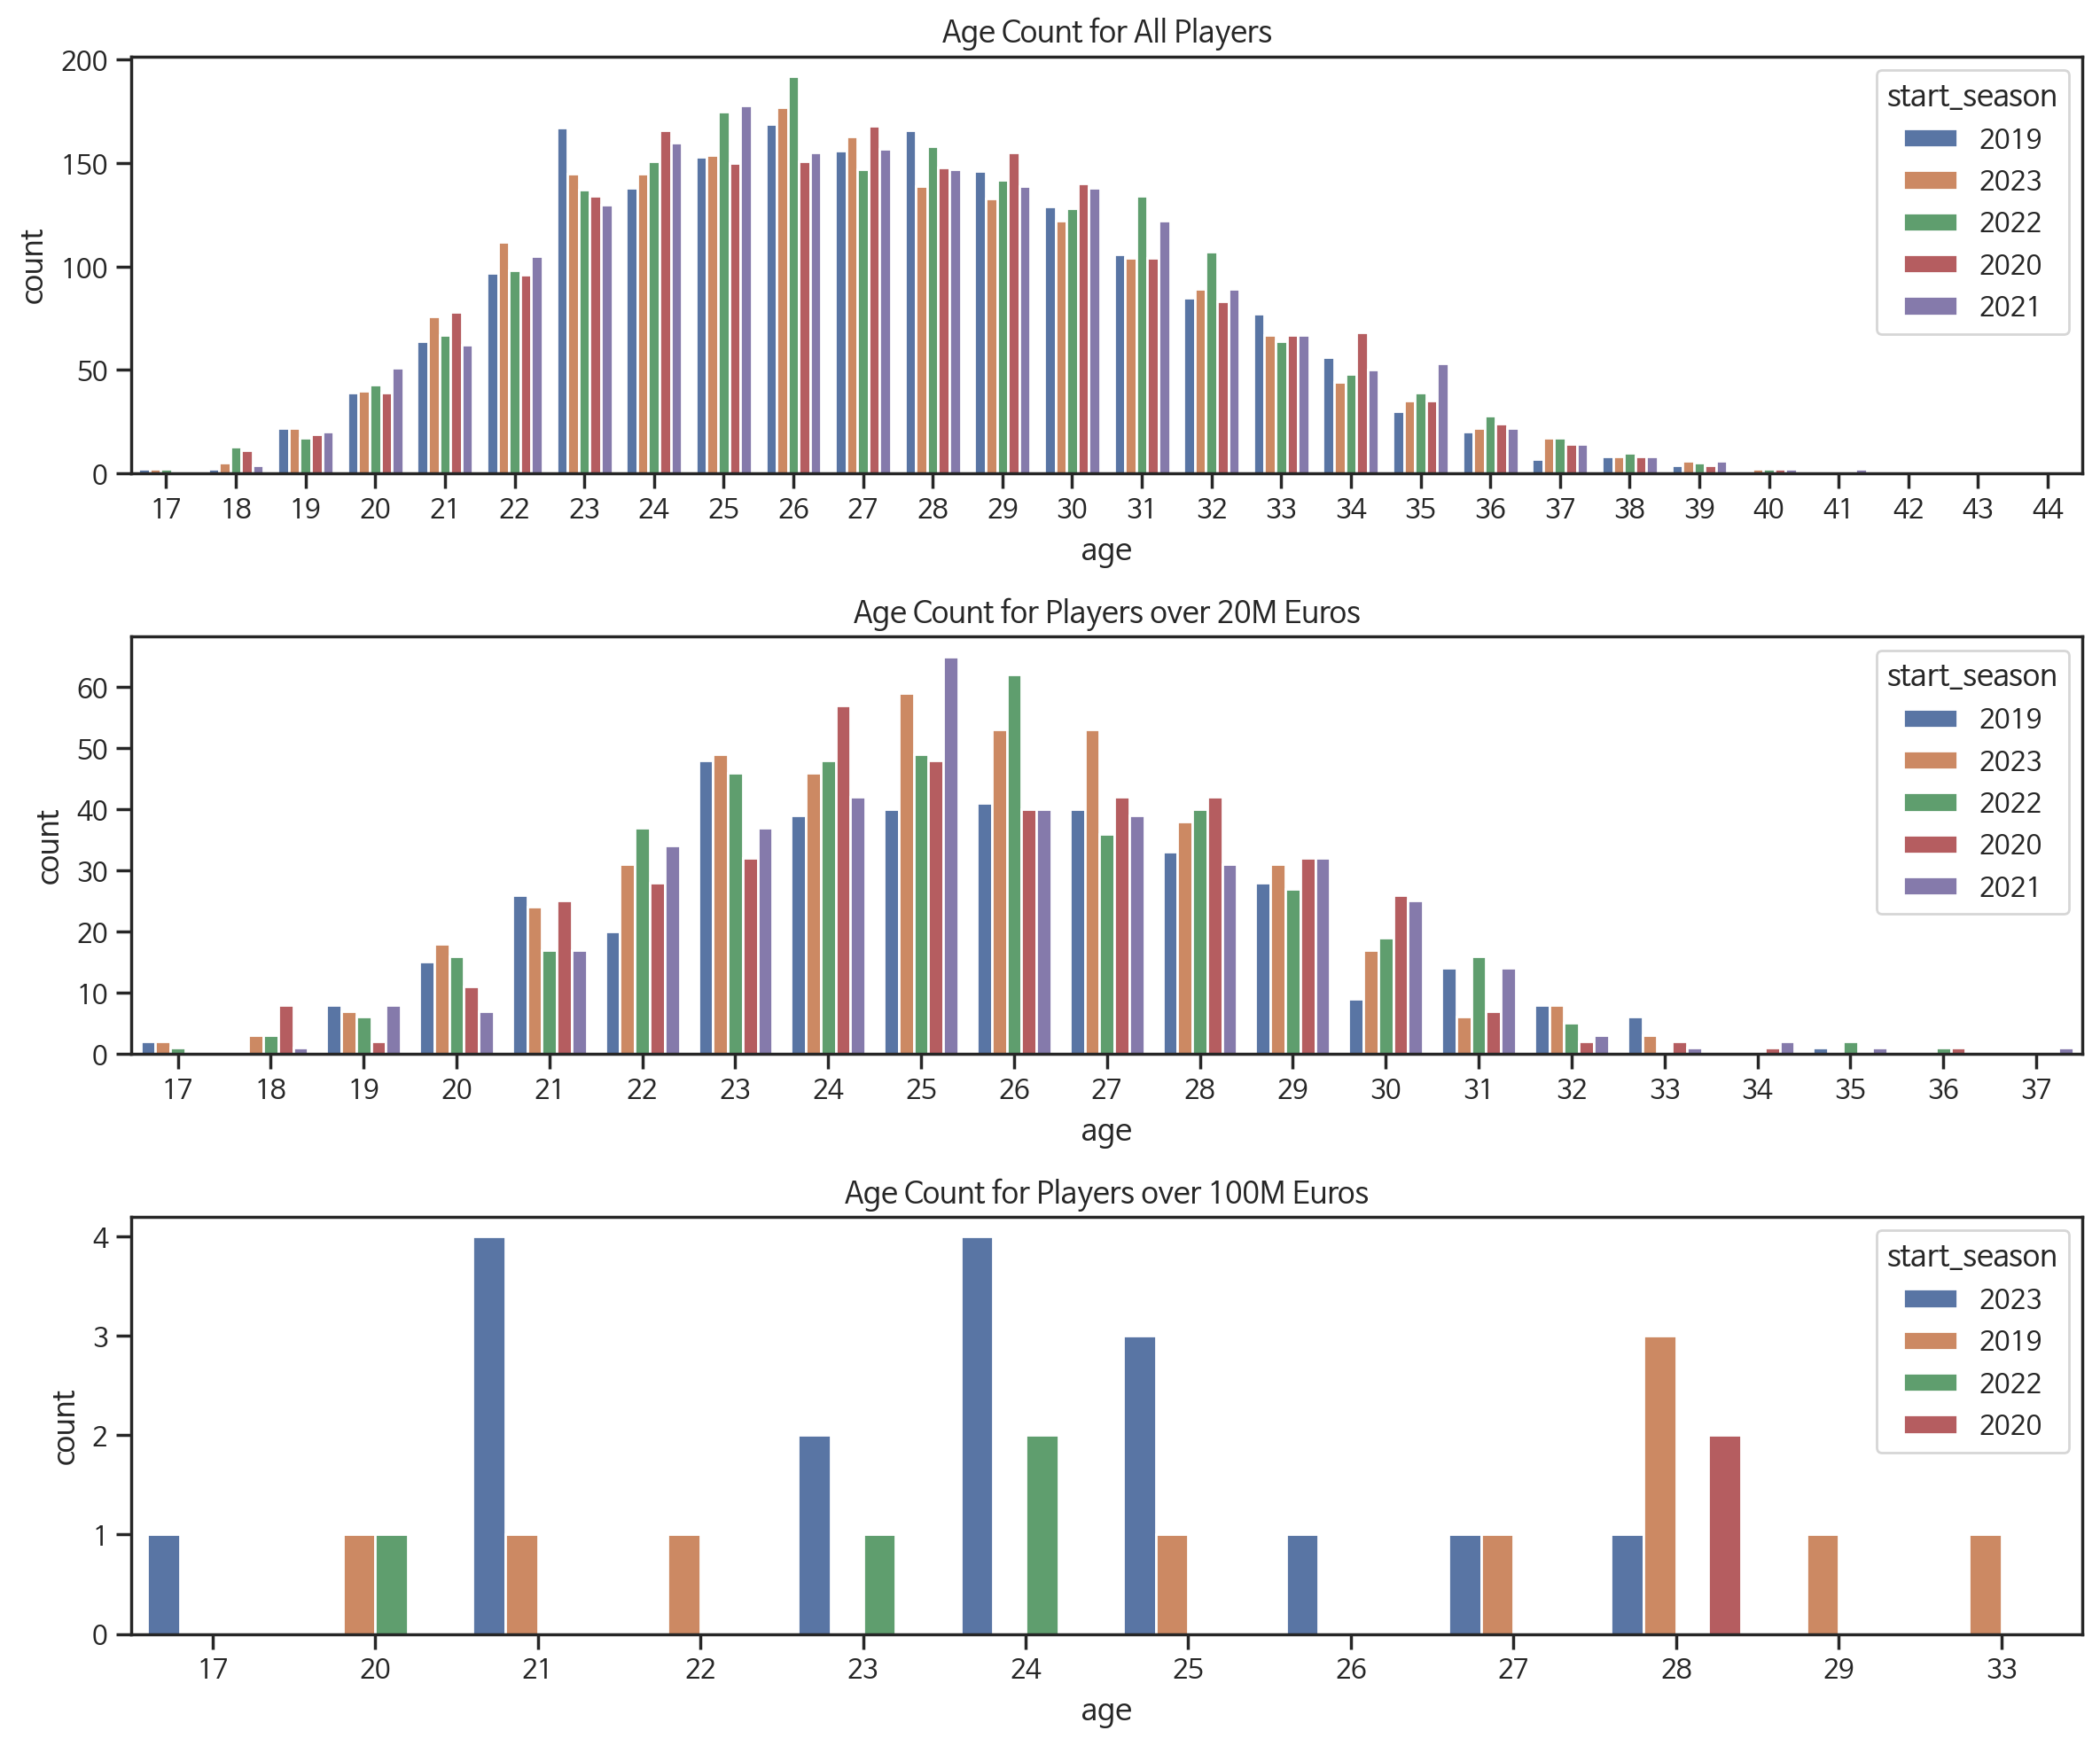

In [73]:
nrows, ncols = 3, 1
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))

hue_order = [2019, 2020, 2021, 2022, 2023]
# flatten()을 통해axes를 1차원 array로 펴줘야 한다
# axes = axes.T.flatten()

g1 = sns.countplot(data=df, x="age", hue="start_season", ax=axes[0])
g2 = sns.countplot(data=df[df.market_value_per_season >= 20000000], x="age", hue="start_season", ax=axes[1])
g3 = sns.countplot(data=more_than_100, x="age", hue="start_season", ax=axes[2])

g1.set_title("Age Count for All Players")
g2.set_title("Age Count for Players over 20M Euros")
g3.set_title("Age Count for Players over 100M Euros")

plt.tight_layout()
plt.show()


##### 100M 유로 넘는 선수들 공격포인트와 `age` 비교

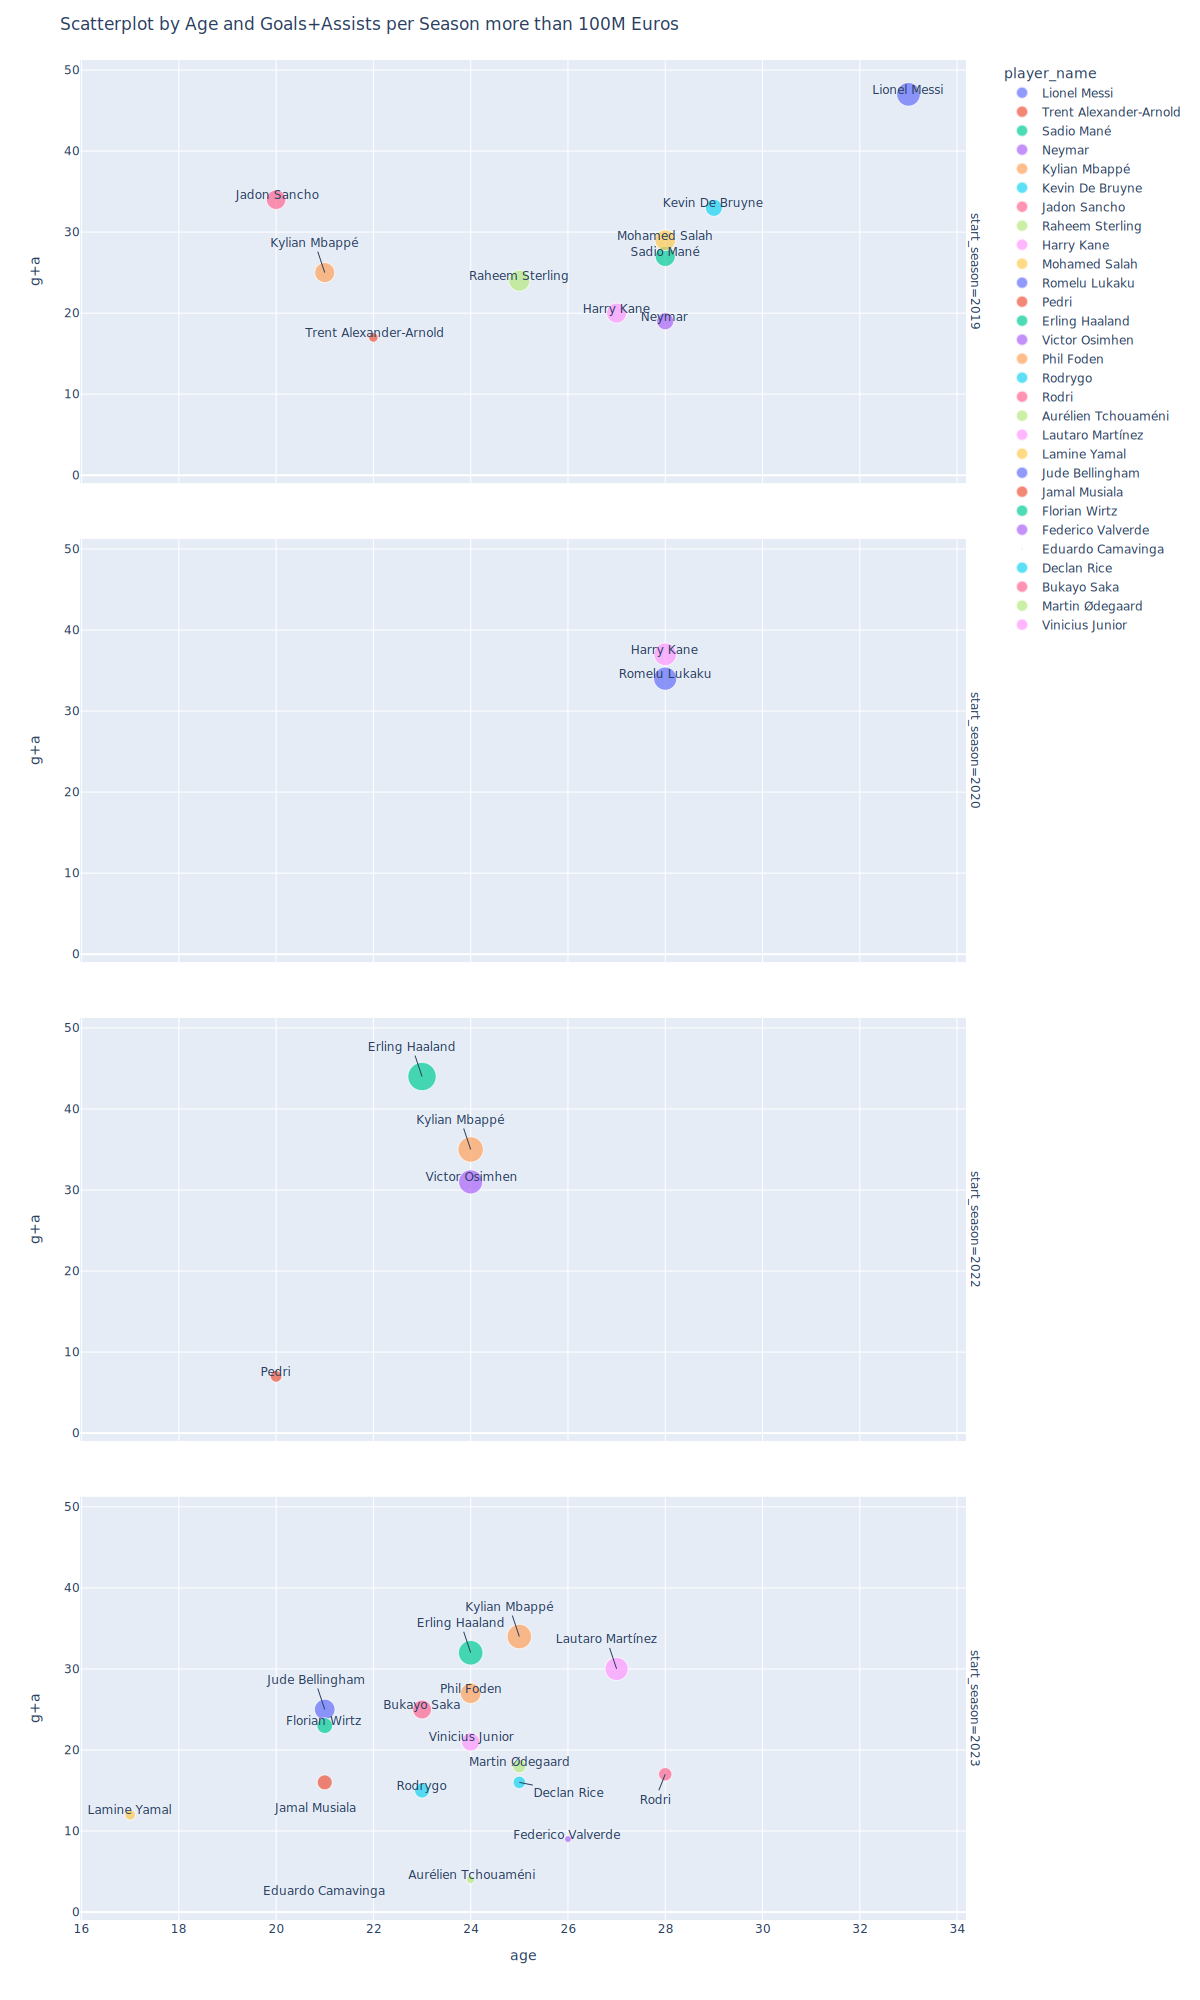

In [74]:
# 득점 + 어시스트 하나로 합친 공격포인트 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="age", y="g+a", color="player_name", 
                 size="goals", facet_row="start_season",
                #  text="player_name",
                 width=1200, height=2000)


overlapped_names = ["Erling Haaland", "Kylian Mbappé", "Lautaro Martínez", "Jude Bellingham"]

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri", "Jamal Musiala"]:
                                 fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # ax = 25,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
            
            elif seasonal.loc[j, "player_name"] in ["Declan Rice"]:
                                 fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ax = 50,
                                    ay=10,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                 
            else:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "g+a"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Age and Goals+Assists per Season more than 100M Euros")
fig.update_traces(textposition="top center")
fig.show()

##### 100M 유로 넘는 선수들 `market_value_per_season`과 `age` 비교

In [75]:
more_than_100

player_name  market_value_per_season start_season  \
19            Lionel Messi              112000000.0         2019   
30  Trent Alexander-Arnold              110000000.0         2019   
29              Sadio Mané              120000000.0         2019   
22                  Neymar              128000000.0         2019   
14           Kylian Mbappé              180000000.0         2019   
13         Kevin De Bruyne              120000000.0         2019   
10            Jadon Sancho              117000000.0         2019   
25         Raheem Sterling              128000000.0         2019   
8               Harry Kane              120000000.0         2019   
21           Mohamed Salah              120000000.0         2019   
9               Harry Kane              120000000.0         2020   
28           Romelu Lukaku              100000000.0         2020   
23                   Pedri              100000000.0         2022   
4           Erling Haaland              180000000.0         2022   
15           Kylian Mbappé              180000000.0         2022   
31          Victor Osimhen              120000000.0         2022   
24              Phil Foden              150000000.0         2023   
27                 Rodrygo              110000000.0         2023   
26                   Rodri              130000000.0         2023   
0      Aurélien Tchouaméni              100000000.0         2023   
16           Kylian Mbappé              180000000.0         2023   
18        Lautaro Martínez              110000000.0         2023   
17            Lamine Yamal              120000000.0         2023   
12         Jude Bellingham              180000000.0         2023   
11           Jamal Musiala              130000000.0         2023   
7            Florian Wirtz              130000000.0         2023   
6        Federico Valverde              120000000.0         2023   
5           Erling Haaland              180000000.0         2023   
3        Eduardo Camavinga              100000000.0         2023   
2              Declan Rice              120000000.0         2023   
1              Bukayo Saka              140000000.0         2023   
20         Martin Ødegaard              110000000.0         2023   
32         Vinicius Junior              180000000.0         2023   

    yellow_cards  red_cards  goals  assists  minutes_played competition_code  \
19           4.0        0.0   25.0     22.0          2880.0           laliga   
30           5.0        0.0    4.0     13.0          3176.0   premier-league   
29           3.0        0.0   18.0      9.0          2755.0   premier-league   
22           4.0        0.0   13.0      6.0          1322.0          ligue-1   
14           0.0        0.0   18.0      7.0          1515.0          ligue-1   
13           3.0        0.0   13.0     20.0          2800.0   premier-league   
10           2.0        0.0   17.0     17.0          2292.0       bundesliga   
25           5.0        0.0   20.0      4.0          2660.0   premier-league   
8            4.0        0.0   18.0      2.0          2590.0   premier-league   
21           1.0        0.0   19.0     10.0          2888.0   premier-league   
9            1.0        0.0   23.0     14.0          3086.0   premier-league   
28           4.0        0.0   24.0     10.0          2978.0          serie-a   
23           2.0        0.0    6.0      1.0          1982.0           laliga   
4            5.0        0.0   36.0      8.0          2777.0   premier-league   
15           6.0        0.0   29.0      6.0          2822.0          ligue-1   
31           4.0        0.0   26.0      5.0          2581.0          serie-a   
24           2.0        0.0   19.0      8.0          2871.0   premier-league   
27           2.0        0.0   10.0      5.0          2391.0           laliga   
26           8.0        1.0    8.0      9.0          2938.0   premier-league   
0            6.0        0.0    3.0      1.0          1986.0           laliga   
16           4.0      

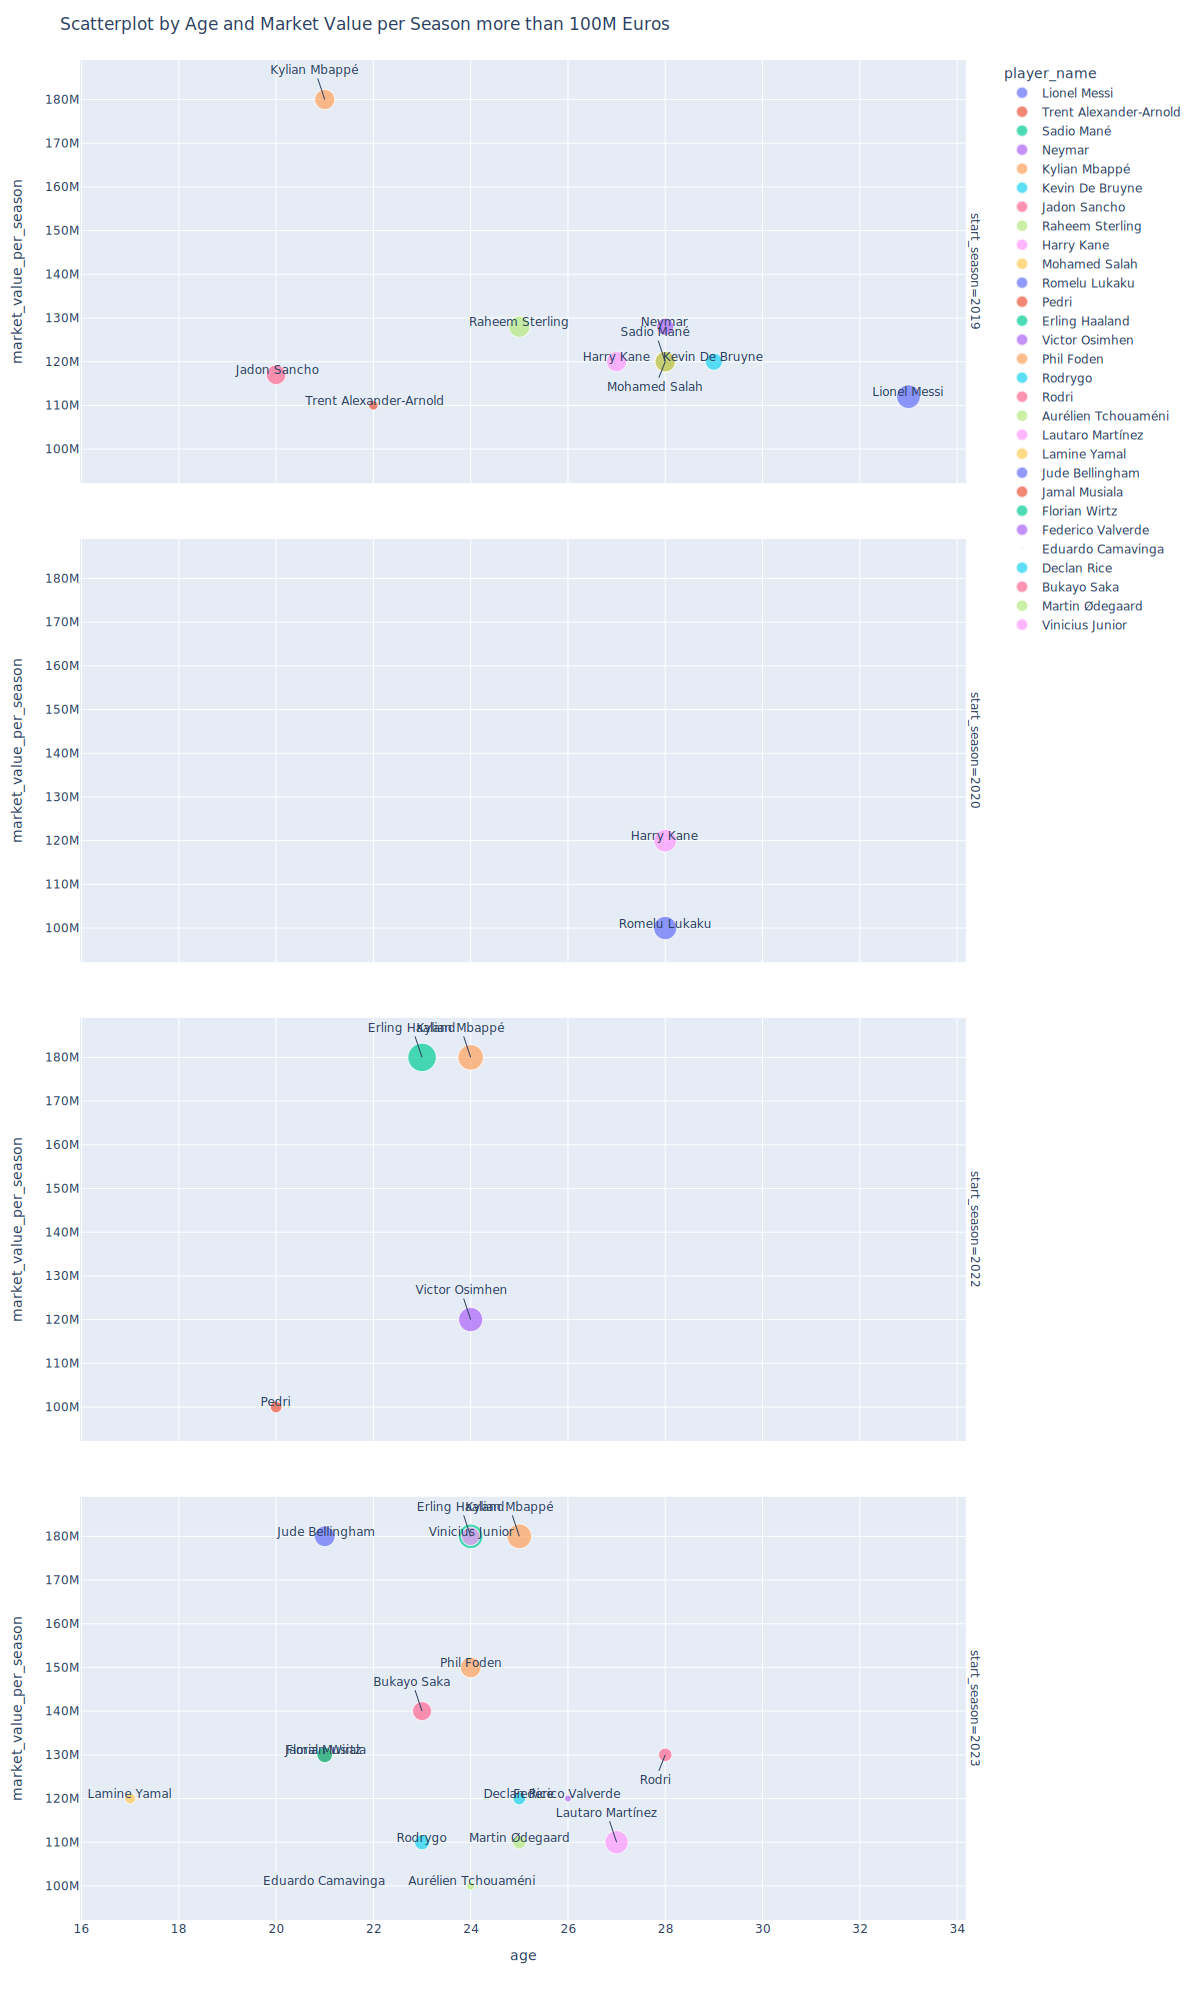

In [76]:
# 나이에 따른 market_value_per_season 시각화

# plotly로 scatterplot 확인
import plotly.express as px

fig = px.scatter(data_frame=more_than_100, x="age", y="market_value_per_season",
                 color="player_name", 
                 size="goals", facet_row="start_season",
                #  text="player_name",
                 width=1200, height=2000)

overlapped_names = ["Victor Osimhen", "Erling Haaland", "Kylian Mbappé", "Lautaro Martínez", "Sadio Mané", "Bukayo Saka"]

for i, season in enumerate(more_than_100["start_season"].unique()):
    seasonal = more_than_100[more_than_100["start_season"] == season].reset_index(drop=True)
    i = (-1)*(i-4)
    # print(seasonal)
    for j in range(seasonal.shape[0]):
        # print(seasonal.loc[j, "goals"])
            if seasonal.loc[j, "player_name"] in overlapped_names:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "market_value_per_season"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    ay=-30,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)
                
            elif seasonal.loc[j, "player_name"] in ["Rodri", "Mohamed Salah"]:
                                 fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "market_value_per_season"],
                                    text=seasonal.loc[j, "player_name"],
                                    # xanchor="left",
                                    # yanchor="bottom",
                                    showarrow=True,
                                    # ax = 25,
                                    ay=25,
                                    # yshift=22,
                                    #    arrowhead=0,
                                    row=i, col=1)

            else:
                fig.add_annotation(x=seasonal.loc[j, "age"], y=seasonal.loc[j, "market_value_per_season"],
                                   text=seasonal.loc[j, "player_name"],
                                   # xanchor="left",
                                   # yanchor="bottom",
                                   showarrow=False,
                                   yshift=5,
                                   #    arrowhead=0,
                                   row=i, col=1)

fig.update_layout(title_text="Scatterplot by Age and Market Value per Season more than 100M Euros")
# fig.update_traces(textposition="top center")
fig.show()

## EDA 정리

- 데이터 특징
    - 다양한 컬럼에서 많은 이상치 존재
        - 그러나 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라지게 나타난다
    - 결론 : 이상치 따로 처리하지 않음

- 상관관계
    - 다중 공선성 체크
    - 상관관계 높은 컬럼들 존재 → 추후 머신러닝 모델링에 따라 추가 제거 고민

- 컬럼별 분석
    - `goals`, `assists`
        - 19세 ~ 35세 까지 분포가 많다
        - 나이에 따라 비슷하게 이상치 존재
        - 시각화 결과
            - 시즌별 (5년간) 득점, 어시스트 특화된 순수들이 대다수
            - 시즌에 따라 간혹, 득점, 어시스트 전부 다 많이 기록하는 선수들 존재한다 (Mbappe, Messi 등)
    - `market_value_per_season`
        - 나이별 몸값은 시즌에 따라 보통 비슷하게 나타난다
            - outlier : 2023 시즌 16세 → Lamine Yamal
        - 몸값 `100M 유로` 넘는 선수들 (고가의 선수)만 따로 한번 더 시각화
            - `goals`, `assists`
                - 몸값 높은 선수들은 보통 득점이 많거나 어시스트가 많다
                    - 간혹 둘 다 높은 선수도 존재
            - `goals` + `assists` 합산한 공격포인트 확인
                - 공격포인트 높은 선수가 비싸다
                - 하지만 비슷한 공격포인트를 기록해도 몸값이 차이나는 선수들 존재
        - 포지션별 몸값은 `Left Winger`가 가장 높다
            - 2번째는 `Second Striker`, 3번째는 `Attacking Midfield`, 마지막은 `Goalkeeper`
    - `age`
        - 시즌별 전체 선수, 몸값 20M 유로 넘는 선수, 몸값 100M 유로 넘는 선수 분포 비교 → 분포 비슷하다
        - 몸값 `100M 유로` 넘는 선수들 (고가의 선수)만 따로 한번 더 시각화
            - `age`, `goals` + `assists` 합산한 공격포인트
                - 시즌별로 나이에 따라 공격포인트가 증가하는 모습을 보임
                - 포지션에 따라 공격포인트가 적을 수도 있음 (ex. Rice, Rodri : Defensive Midfield)
            - `age`, `market_value_per_season`
                - 시간이 지날 수록 나이 어린 선수들이 주로 높은 몸값 기록 (Bellingham, Haaland, Mbappe, Vinicius 등)
                    - Outlier : 1920 시즌 Messi        




## EDA 거친 데이터셋 `csv`로 저장

In [77]:
# 상관관계 높은 컬럼 ("yellow_cards", "red_cards") 삭제한 데이터셋 
df_deleted = df.drop(columns=["yellow_cards", "red_cards"], axis="columns")
df_deleted.head()

player_name start_season  goals  assists  minutes_played  \
0       Aarón Martín         2019    0.0      0.0          1795.0   
1  Abdelhamid Sabiri         2019    4.0      1.0          1035.0   
2      Achraf Hakimi         2019    5.0     10.0          2717.0   
3        Adam Bodzek         2019    0.0      0.0          2018.0   
5      Admir Mehmedi         2019    2.0      2.0          1205.0   

  competition_code date_of_birth            position    current_club_name  \
0       bundesliga    1997-04-22           Left-Back            Genoa CFC   
1       bundesliga    1996-11-28  Attacking Midfield       ACF Fiorentina   
2       bundesliga    1998-11-04          Right-Back  Paris Saint-Germain   
3       bundesliga    1985-09-07  Defensive Midfield   Fortuna Düsseldorf   
5       bundesliga    1991-03-16      Second Striker          Antalyaspor   

   market_value_per_season      country   foot  height_in_cm        xG  \
0               10500000.0        Spain   left         178.0  0.294448   
1                1700000.0      Morocco  right         186.0  3.468877   
2               54000000.0      Morocco  right         181.0  5.067438   
3                 325000.0       Poland  right         184.0  0.697913   
5                8000000.0  Switzerland  right         183.0  1.536662   

         xA  shots  key_passes    xGChain  xGBuildup  age  
0  3.250888    9.0        32.0   3.658402   2.195273   23  
1  0.232751   43.0         7.0   1.644770   0.885899   23  
2  5.510969   38.0        36.0  24.144373  16.293885   21  
3  0.270701    9.0         8.0   2.535295   1.791962   35  
5  2.166826   22.0        19.0   6.112824   3.069346   29

In [78]:
# 상관관계 높은 컬럼 ("yellow_cards", "red_cards") 삭제한 데이터셋을 df_eda.csv로 저장
df_deleted.to_csv("data/df_eda.csv", index=False)

In [79]:
# 컬럼 삭제하지 않은 데이터셋을 df_eda_no_del.csv로 저장
df.to_csv("data/df_eda_no_del.csv", index=False)